# Electricity Demand and Price Forecasting

Importing essential library and packages

In [2]:
#importing python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series
from numpy.random import randn
from pylab import rcParams
from matplotlib import pyplot
from collections import Counter
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder,LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam
import ast

Importing the given dataset i.e. energy_dataset and weather_features

In [3]:
df1=pd.read_excel("energy_dataset.xlsx")
df2=pd.read_excel("weather_features.xlsx")

Converting dataset df1 and df2 into datetime frame

In [4]:
df1['datetime']= pd.to_datetime(df1['datetime'],utc=True)
df2['datetime']= pd.to_datetime(df2['datetime'],utc=True)

Creating a function to calculate mode from the given column

In [5]:
def calculate_mode(data):
    # Use Counter to count occurrences of each string
    counter = Counter(data)

    # Find the maximum count (mode) and get all values with that count
    max_count = max(counter.values())
    mode = [item for item, count in counter.items() if count == max_count]

    # If all items appear the same number of times, return an empty list
    if len(mode) == len(data):
        return []

    return mode

Removing city_name column from our df2 dataset

In [6]:
df2.drop(columns=['city_name'], inplace=True)


Aggregating our df2 (weather_features) dataset and calculating mean and mode accordingly

In [7]:
df2 = df2.groupby(['datetime']).agg({
    'temp': 'mean',           # Mean temperature
    'temp_min': 'mean',       # Minimum temperature
    'temp_max': 'mean',       # Maximum temperature
    'pressure': 'mean',      # Mean pressure
    'humidity': 'mean',      # Mean humidity
    'wind_speed': 'mean',    # Mean wind speed
    'wind_deg': 'mean',      # Mean wind degree
    'rain_1h': 'mean',        # Sum of rain_1h
    'rain_3h': 'mean',        # Sum of rain_3h
    'snow_3h': 'mean',        # Sum of snow_3h
    'clouds_all': 'mean',    # Mean clouds_all
    'weather_id': 'mean',    # Mean weather_id
    'weather_main': lambda x: calculate_mode(x),
    'weather_description': lambda x: calculate_mode(x),
     'weather_icon': lambda x: calculate_mode(x)
    }).reset_index()

Rows and columns of df2 dataset

In [8]:
df2.shape

(35064, 16)

In [9]:
df2.head(10)

datetime        temp    temp_min    temp_max  pressure  \
0 2014-12-31 23:00:00+00:00  272.491463  272.491463  272.491463    1016.4   
1 2015-01-01 00:00:00+00:00  272.512700  272.512700  272.512700    1016.2   
2 2015-01-01 01:00:00+00:00  272.099137  272.099137  272.099137    1016.8   
3 2015-01-01 02:00:00+00:00  272.089469  272.089469  272.089469    1016.6   
4 2015-01-01 03:00:00+00:00  272.145900  272.145900  272.145900    1016.6   
5 2015-01-01 04:00:00+00:00  272.024000  272.024000  272.024000    1017.4   
6 2015-01-01 05:00:00+00:00  272.058400  272.058400  272.058400    1017.4   
7 2015-01-01 06:00:00+00:00  272.346600  272.346600  272.346600    1017.6   
8 2015-01-01 07:00:00+00:00  273.993600  273.993600  273.993600    1018.8   
9 2015-01-01 08:00:00+00:00  274.197200  274.197200  274.197200    1018.8   

   humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  \
0      82.4         2.0     135.2      0.0      0.0      0.0         0.0   
1      82.4         2.0     135.8      0.0      0.0      0.0         0.0   
2      82.0         2.4     119.0      0.0      0.0      0.0         0.0   
3      82.0         2.4     119.2      0.0      0.0      0.0         0.0   
4      82.0         2.4     118.4      0.0      0.0      0.0         0.0   
5      82.6         2.4     174.8      0.0      0.0      0.0         0.0   
6      82.6         2.4     174.4      0.0      0.0      0.0         0.0   
7      82.2         2.4     174.4      0.0      0.0      0.0         0.0   
8      81.2         1.4     248.0      0.0      0.0      0.0         0.0   
9      81.0         1.4     247.8      0.0      0.0      0.0         0.0   

   weather_id weather_main weather_description weather_icon  
0       800.0      [clear]      [sky is clear]        [01n]  
1       800.0      [clear]      [sky is clear]        [01n]  
2       800.0      [clear]      [sky is clear]        [01n]  
3       800.0      [clear]      [sky is clear]        [01n]  
4       800.0      [clear]      [sky is clear]        [01n]  
5       800.0      [clear]      [sky is clear]        [01n]  
6       800.0      [clear]      [sky is clear]        [01n]  
7       800.0      [clear]      [sky is clear]        [01n]  
8       800.0      [clear]      [sky is clear]        [01d]  
9       800.0      [clear]      [sky is clear]        [01d]

Merging of our df1(energy_dataset)  and df2(weather_features) dataset

In [10]:
df1=df1.merge(df2, how='left')
df1.head(5)

datetime  generation biomass  \
0 2014-12-31 23:00:00+00:00               447.0   
1 2015-01-01 00:00:00+00:00               449.0   
2 2015-01-01 01:00:00+00:00               448.0   
3 2015-01-01 02:00:00+00:00               438.0   
4 2015-01-01 03:00:00+00:00               428.0   

   generation fossil brown coal/lignite  generation fossil coal-derived gas  \
0                                 329.0                                 0.0   
1                                 328.0                                 0.0   
2                                 323.0                                 0.0   
3                                 254.0                                 0.0   
4                                 187.0                                 0.0   

   generation fossil gas  generation fossil hard coal  generation fossil oil  \
0                 4844.0                       4821.0                  162.0   
1                 5196.0                       4755.0                  158.0   
2                 4857.0                       4581.0                  157.0   
3                 4314.0                       4131.0                  160.0   
4                 4130.0                       3840.0                  156.0   

   generation fossil oil shale  generation fossil peat  generation geothermal  \
0                          0.0                     0.0                    0.0   
1                          0.0                     0.0                    0.0   
2                          0.0                     0.0                    0.0   
3                          0.0                     0.0                    0.0   
4                          0.0                     0.0                    0.0   

   ...  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  \
0  ...         2.0     135.2      0.0      0.0      0.0         0.0   
1  ...         2.0     135.8      0.0      0.0      0.0         0.0   
2  ...         2.4     119.0      0.0      0.0      0.0         0.0   
3  ...         2.4     119.2      0.0      0.0      0.0         0.0   
4  ...         2.4     118.4      0.0      0.0      0.0         0.0   

   weather_id  weather_main  weather_description  weather_icon  
0       800.0       [clear]       [sky is clear]         [01n]  
1       800.0       [clear]       [sky is clear]         [01n]  
2       800.0       [clear]       [sky is clear]         [01n]  
3       800.0       [clear]       [sky is clear]         [01n]  
4       800.0       [clear]       [sky is clear]         [01n]  

[5 rows x 44 columns]

Rows and columns of the merged dataset df1

In [11]:
df1.shape

(35064, 44)

In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 44 columns):
 #   Column                                       Non-Null Count  Dtype              
---  ------                                       --------------  -----              
 0   datetime                                     35064 non-null  datetime64[ns, UTC]
 1   generation biomass                           35045 non-null  float64            
 2   generation fossil brown coal/lignite         35046 non-null  float64            
 3   generation fossil coal-derived gas           35046 non-null  float64            
 4   generation fossil gas                        35046 non-null  float64            
 5   generation fossil hard coal                  35046 non-null  float64            
 6   generation fossil oil                        35045 non-null  float64            
 7   generation fossil oil shale                  35046 non-null  float64            
 8   generation fossil peat    

# Data Preprocessing

### Null value treatment

Checking if any columns just have null of zero value by summing all the numerical data in that column

In [13]:
# Identify columns where the sum is zero
zero_sum_columns = []

for col in df1.columns:
    if pd.api.types.is_numeric_dtype(df1[col]):
        if df1[col].sum() == 0:
            zero_sum_columns.append(col)

# Print the columns with zero sum
print("Columns with sum equal to zero:")
print(zero_sum_columns)

Columns with sum equal to zero:
['generation fossil coal-derived gas', 'generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 'generation hydro pumped storage aggregated', 'generation marine', 'generation wind offshore', 'forecast wind offshore eday ahead']


Dropping these columns because they contain all null values or all zero value

In [14]:
df1.drop(columns=['generation fossil coal-derived gas','generation fossil oil shale','generation fossil peat','generation geothermal','generation hydro pumped storage aggregated','generation marine','generation wind offshore','forecast wind offshore eday ahead'], inplace=True)
df1.head(5)

datetime  generation biomass  \
0 2014-12-31 23:00:00+00:00               447.0   
1 2015-01-01 00:00:00+00:00               449.0   
2 2015-01-01 01:00:00+00:00               448.0   
3 2015-01-01 02:00:00+00:00               438.0   
4 2015-01-01 03:00:00+00:00               428.0   

   generation fossil brown coal/lignite  generation fossil gas  \
0                                 329.0                 4844.0   
1                                 328.0                 5196.0   
2                                 323.0                 4857.0   
3                                 254.0                 4314.0   
4                                 187.0                 4130.0   

   generation fossil hard coal  generation fossil oil  \
0                       4821.0                  162.0   
1                       4755.0                  158.0   
2                       4581.0                  157.0   
3                       4131.0                  160.0   
4                       3840.0                  156.0   

   generation hydro pumped storage consumption  \
0                                        863.0   
1                                        920.0   
2                                       1164.0   
3                                       1503.0   
4                                       1826.0   

   generation hydro run-of-river and poundage  \
0                                      1051.0   
1                                      1009.0   
2                                       973.0   
3                                       949.0   
4                                       953.0   

   generation hydro water reservoir  generation nuclear  ...  wind_speed  \
0                            1899.0              7096.0  ...         2.0   
1                            1658.0              7096.0  ...         2.0   
2                            1371.0              7099.0  ...         2.4   
3                             779.0              7098.0  ...         2.4   
4                             720.0              7097.0  ...         2.4   

   wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  weather_id  weather_main  \
0     135.2      0.0      0.0      0.0         0.0       800.0       [clear]   
1     135.8      0.0      0.0      0.0         0.0       800.0       [clear]   
2     119.0      0.0      0.0      0.0         0.0       800.0       [clear]   
3     119.2      0.0      0.0      0.0         0.0       800.0       [clear]   
4     118.4      0.0      0.0      0.0         0.0       800.0       [clear]   

   weather_description  weather_icon  
0       [sky is clear]         [01n]  
1       [sky is clear]         [01n]  
2       [sky is clear]         [01n]  
3       [sky is clear]         [01n]  
4       [sky is clear]         [01n]  

[5 rows x 36 columns]

Rows and columns after removing those 6 columns

In [15]:
df1.shape

(35064, 36)

In [16]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 36 columns):
 #   Column                                       Non-Null Count  Dtype              
---  ------                                       --------------  -----              
 0   datetime                                     35064 non-null  datetime64[ns, UTC]
 1   generation biomass                           35045 non-null  float64            
 2   generation fossil brown coal/lignite         35046 non-null  float64            
 3   generation fossil gas                        35046 non-null  float64            
 4   generation fossil hard coal                  35046 non-null  float64            
 5   generation fossil oil                        35045 non-null  float64            
 6   generation hydro pumped storage consumption  35045 non-null  float64            
 7   generation hydro run-of-river and poundage   35045 non-null  float64            
 8   generation hydro water res

To calculate number of null values present in each column of our df1 dataset

In [17]:
null_counts = df1.isnull().sum()

# Print columns with null values, if any
if null_counts.sum() == 0:
    print("No null values found in df1.")
else:
    print("Columns with null values in df1:")
    print(null_counts[null_counts > 0])

Columns with null values in df1:
generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
total load actual                              36
dtype: int64


Filling these null values with backward fill (bfill())

In [18]:
# Fill null values with bfill
df1 = df1.bfill()

# Check for null values again
columns_with_null = df1.isnull().sum()

# Print columns with remaining null values
print("Columns with remaining null values:\n", columns_with_null[columns_with_null > 0])


Columns with remaining null values:
 Series([], dtype: int64)


To verify whether we filled all those null values with bfil() or not

In [19]:
null_counts = df1.isnull().sum()

# Print columns with null values, if any
if null_counts.sum() == 0:
    print("No null values found in df1.")
else:
    print("Columns with null values in df1:")
    print(null_counts[null_counts > 0])

No null values found in df1.


### Outliers Treatment

Using the IQR (Interquartile Range) method to detect outliers, it defines outliers as values that are below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR, where Q1 and Q3 are the 25th and 75th percentiles, respectively.

In [20]:
def detect_outliers_count(df):
    outliers_count = {}
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
            outliers_count[col] = outlier_mask.sum()
    return outliers_count

outliers_count = detect_outliers_count(df1)

# Print count of outliers
for col, count in outliers_count.items():
    print(f"Number of outliers in column '{col}': {count}")

Number of outliers in column 'generation biomass': 87
Number of outliers in column 'generation fossil brown coal/lignite': 0
Number of outliers in column 'generation fossil gas': 2185
Number of outliers in column 'generation fossil hard coal': 0
Number of outliers in column 'generation fossil oil': 246
Number of outliers in column 'generation hydro pumped storage consumption': 3763
Number of outliers in column 'generation hydro run-of-river and poundage': 0
Number of outliers in column 'generation hydro water reservoir': 341
Number of outliers in column 'generation nuclear': 79
Number of outliers in column 'generation other': 1267
Number of outliers in column 'generation other renewable': 5
Number of outliers in column 'generation solar': 0
Number of outliers in column 'generation waste': 328
Number of outliers in column 'generation wind onshore': 375
Number of outliers in column 'forecast solar day ahead': 0
Number of outliers in column 'forecast wind onshore day ahead': 436
Number of

Using Upper bound and lower Bound capping technique to handle these outliers.

In [21]:
def treat_outliers(df):
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df[col] = df[col].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)
    return df

df1_treated = treat_outliers(df1)

# Check if outliers are treated
outliers_count = detect_outliers_count(df1_treated)

# Print count of outliers after treatment
for col, count in outliers_count.items():
    print(f"Number of outliers in column '{col}' after treatment: {count}")

Number of outliers in column 'generation biomass' after treatment: 0
Number of outliers in column 'generation fossil brown coal/lignite' after treatment: 0
Number of outliers in column 'generation fossil gas' after treatment: 0
Number of outliers in column 'generation fossil hard coal' after treatment: 0
Number of outliers in column 'generation fossil oil' after treatment: 0
Number of outliers in column 'generation hydro pumped storage consumption' after treatment: 0
Number of outliers in column 'generation hydro run-of-river and poundage' after treatment: 0
Number of outliers in column 'generation hydro water reservoir' after treatment: 0
Number of outliers in column 'generation nuclear' after treatment: 0
Number of outliers in column 'generation other' after treatment: 0
Number of outliers in column 'generation other renewable' after treatment: 0
Number of outliers in column 'generation solar' after treatment: 0
Number of outliers in column 'generation waste' after treatment: 0
Numbe

## Feature engineering

Converting the df1 dataset datetime column into datetime and having mentioned date and time format

In [22]:
df1['datetime'] = pd.to_datetime(df1['datetime'], format='%Y/%m/%d %H:%M:%S',errors='coerce')

Based on the datetime column creating some new columns as shown below

In [23]:
# Create new columns
df1['hour'] = df1['datetime'].dt.hour
df1['month'] = df1['datetime'].dt.month
df1['day'] = df1['datetime'].dt.day
df1['weekday'] = df1['datetime'].dt.day_name()
df1['is_weekend'] = df1['datetime'].dt.weekday >= 5

In [24]:
df1.head(5)

datetime  generation biomass  \
0 2014-12-31 23:00:00+00:00               447.0   
1 2015-01-01 00:00:00+00:00               449.0   
2 2015-01-01 01:00:00+00:00               448.0   
3 2015-01-01 02:00:00+00:00               438.0   
4 2015-01-01 03:00:00+00:00               428.0   

   generation fossil brown coal/lignite  generation fossil gas  \
0                                 329.0                 4844.0   
1                                 328.0                 5196.0   
2                                 323.0                 4857.0   
3                                 254.0                 4314.0   
4                                 187.0                 4130.0   

   generation fossil hard coal  generation fossil oil  \
0                       4821.0                  162.5   
1                       4755.0                  162.5   
2                       4581.0                  162.5   
3                       4131.0                  162.5   
4                       3840.0                  162.5   

   generation hydro pumped storage consumption  \
0                                        863.0   
1                                        920.0   
2                                       1164.0   
3                                       1503.0   
4                                       1540.0   

   generation hydro run-of-river and poundage  \
0                                      1051.0   
1                                      1009.0   
2                                       973.0   
3                                       949.0   
4                                       953.0   

   generation hydro water reservoir  generation nuclear  ...  clouds_all  \
0                            1899.0              7096.0  ...         0.0   
1                            1658.0              7096.0  ...         0.0   
2                            1371.0              7099.0  ...         0.0   
3                             779.0              7098.0  ...         0.0   
4                             720.0              7097.0  ...         0.0   

   weather_id  weather_main  weather_description  weather_icon  hour  month  \
0       800.0       [clear]       [sky is clear]         [01n]    23     12   
1       800.0       [clear]       [sky is clear]         [01n]     0      1   
2       800.0       [clear]       [sky is clear]         [01n]     1      1   
3       800.0       [clear]       [sky is clear]         [01n]     2      1   
4       800.0       [clear]       [sky is clear]         [01n]     3      1   

   day    weekday  is_weekend  
0   31  Wednesday       False  
1    1   Thursday       False  
2    1   Thursday       False  
3    1   Thursday       False  
4    1   Thursday       False  

[5 rows x 41 columns]

In [25]:
string_columns = df1.select_dtypes(include=['object']).columns

# Print the columns with string values
print("Columns with string values:")
for col in string_columns:
    print(col)

Columns with string values:
weather_main
weather_description
weather_icon
weekday


1.find out unique values 2.create one hot encoding from weather main to is weekend or 3. label encoding weekday to 7 column(if too many columns)

In [26]:
df1['weather_main'].head()

0    [clear]
1    [clear]
2    [clear]
3    [clear]
4    [clear]
Name: weather_main, dtype: object

### Label Encoding

In [27]:
# Ensure the column is treated as strings
df1['weather_main'] = df1['weather_main'].astype(str)
# Initialize an empty set to store unique weather conditions
unique_conditions = set()

# Iterate through the list of weather descriptions
for item in df1['weather_main']:
    # Convert the string representation of list to an actual list
    conditions = ast.literal_eval(item)
    # Update the set with conditions from the current list
    unique_conditions.update(conditions)

# Convert the set back to a list and sort it for better readability
unique_conditions = sorted(unique_conditions)

# Print the unique weather conditions
print(unique_conditions)

['clear', 'clouds', 'drizzle', 'fog', 'haze', 'mist', 'rain', 'snow', 'thunderstorm']


In [28]:
# Ensure the column is treated as strings
df1['weather_main'] = df1['weather_main'].astype(str)

# # Retrieve unique values from the column
# unique_values = df1['weather_main'].unique()

# # Print the unique values
# print(f"Unique values in the column 'column_name':")
# print(unique_values)
df1 = pd.DataFrame(df1)

# Define the weather conditions
weather_conditions = ['clear', 'clouds', 'drizzle', 'fog', 'haze', 'mist', 'rain', 'snow', 'thunderstorm']

# Initialize new columns with 0
for condition in weather_conditions:
    df1[condition] = 0

# Function to encode the weather conditions
def encode_weather_conditions(row, conditions_list):
    if isinstance(row, str):  # Check if the row value is a string
        conditions = eval(row)
        for condition in conditions:
            if condition in conditions_list:
                row_dict[condition] = 1
    return row_dict

# Apply the function to each row
for idx, row in df1.iterrows():
    row_dict = {condition: 0 for condition in weather_conditions}  # Reset for each row
    row_dict = encode_weather_conditions(row['weather_main'], weather_conditions)
    for condition in weather_conditions:
        df1.at[idx, condition] = row_dict[condition]

# Columns to display
columns_to_display = ['weather_main'] + weather_conditions

# Display the selected columns
print(df1[columns_to_display].sample(4))

              weather_main  clear  clouds  drizzle  fog  haze  mist  rain  \
22075           ['clouds']      0       1        0    0     0     0     0   
14970  ['clear', 'clouds']      1       1        0    0     0     0     0   
3203   ['clouds', 'clear']      1       1        0    0     0     0     0   
25620            ['clear']      1       0        0    0     0     0     0   

       snow  thunderstorm  
22075     0             0  
14970     0             0  
3203      0             0  
25620     0             0  


In [29]:
df1 = df1.drop(columns=['weather_main'])

In [30]:
# Ensure the column is treated as strings
df1['weather_description'] = df1['weather_description'].astype(str)
# Initialize an empty set to store unique weather conditions
unique_conditions = set()

# Iterate through the list of weather descriptions
for item in df1['weather_description']:
    # Convert the string representation of list to an actual list
    conditions = ast.literal_eval(item)
    # Update the set with conditions from the current list
    unique_conditions.update(conditions)

# Convert the set back to a list and sort it for better readability
unique_conditions = sorted(unique_conditions)

# Print the unique weather conditions
print(unique_conditions)

['broken clouds', 'drizzle', 'few clouds', 'fog', 'haze', 'heavy intensity rain', 'light intensity drizzle', 'light intensity shower rain', 'light rain', 'light snow', 'mist', 'moderate rain', 'overcast clouds', 'proximity shower rain', 'proximity thunderstorm', 'scattered clouds', 'shower rain', 'sky is clear', 'snow', 'thunderstorm']


In [31]:
df1['weather_description'] = df1['weather_description'].astype(str)
# Define the weather descriptions
weather_descriptions = ['broken clouds', 'drizzle', 'few clouds', 'fog', 'haze', 'heavy intensity rain',
                        'light intensity drizzle', 'light intensity shower rain', 'light rain', 'light snow',
                        'mist', 'moderate rain', 'overcast clouds', 'proximity shower rain',
                        'proximity thunderstorm', 'scattered clouds', 'shower rain', 'sky is clear',
                        'snow', 'thunderstorm']

# Initialize new columns with 0
for description in weather_descriptions:
    df1[description] = 0

# Function to encode the weather descriptions
def encode_weather_descriptions(row):
    if isinstance(row['weather_description'], str):
        try:
            descriptions = eval(row['weather_description'])
            for description in descriptions:
                if description in weather_descriptions:
                    row[description] = 1
        except:
            pass
    return row

# Apply the function to each row
df1 = df1.apply(encode_weather_descriptions, axis=1)

# Columns to display
columns_to_display = ['weather_description'] + weather_descriptions

# Display the selected columns
print(df1[columns_to_display].head(2))

  weather_description  broken clouds  drizzle  few clouds  fog  haze  \
0    ['sky is clear']              0        0           0    0     0   
1    ['sky is clear']              0        0           0    0     0   

   heavy intensity rain  light intensity drizzle  light intensity shower rain  \
0                     0                        0                            0   
1                     0                        0                            0   

   light rain  ...  mist  moderate rain  overcast clouds  \
0           0  ...     0              0                0   
1           0  ...     0              0                0   

   proximity shower rain  proximity thunderstorm  scattered clouds  \
0                      0                       0                 0   
1                      0                       0                 0   

   shower rain  sky is clear  snow  thunderstorm  
0            0             1     0             0  
1            0             1     0           

In [32]:
df1 = df1.drop(columns=['weather_description'])

In [33]:
df1['weather_icon'] = df1['weather_icon'].astype(str)
# Initialize an empty set to store unique weather conditions
unique_conditions = set()

# Iterate through the list of weather descriptions
for item in df1['weather_icon']:
    # Convert the string representation of list to an actual list
    conditions = ast.literal_eval(item)
    # Update the set with conditions from the current list
    unique_conditions.update(conditions)

# Convert all elements to strings before sorting
unique_conditions = sorted(map(str, unique_conditions))

# Print the unique weather conditions
print(unique_conditions)

['01d', '01n', '02d', '02n', '03d', '03n', '04d', '04n', '09d', '09n', '1', '10', '10d', '10n', '11d', '11n', '13d', '13n', '2', '3', '4', '50d', '50n']


In [34]:
df1 = pd.DataFrame(df1)
# Ensure the column is treated as strings
df1['weather_icon'] = df1['weather_icon'].astype(str)

# List of unique weather icons to create columns for
weather_icons = ['01d', '01n', '02d', '02n', '03d', '03n', '04d', '04n', '09d', '09n', '1', '10', '10d', '10n', '11d', '11n', '13d', '13n', '2', '3', '4', '50d', '50n']

# Initialize new columns with 0
for icon in weather_icons:
    df1[icon] = 0

# Function to encode the weather descriptions
def encode_weather_icons(row):
    if isinstance(row['weather_icon'], str):
        try:
            icons = eval(row['weather_icon'])
            for icon in icons:
                if icon in weather_icons:
                    row[icon] = 1
        except:
            pass
    return row

# Apply the function to each row
df1 = df1.apply(encode_weather_icons, axis=1)

# Columns to display
columns_to_display = ['weather_icon'] + weather_icons

# Display the selected columns
print(df1[columns_to_display].head(2))

  weather_icon  01d  01n  02d  02n  03d  03n  04d  04n  09d  ...  10n  11d  \
0      ['01n']    0    1    0    0    0    0    0    0    0  ...    0    0   
1      ['01n']    0    1    0    0    0    0    0    0    0  ...    0    0   

   11n  13d  13n  2  3  4  50d  50n  
0    0    0    0  0  0  0    0    0  
1    0    0    0  0  0  0    0    0  

[2 rows x 24 columns]


In [35]:
df1 = df1.drop(columns=['weather_icon'])

In [36]:
# Ensure the column is treated as strings
df1['weekday'] = df1['weekday'].astype(str)

# Retrieve unique values from the column
unique_values = df1['weekday'].unique()

# Print the unique values
print(f"Unique values in the column 'column_name':")
print(unique_values)

Unique values in the column 'column_name':
['Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday' 'Monday' 'Tuesday']


In [37]:
# Ensure the column is treated as strings
df1['weekday'] = df1['weekday'].astype(str)
# List of weekdays
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Initialize columns with 0
for day in weekdays:
    df1[day] = 0

# Function to update the weekday columns
def update_weekdays(row):
    if row['weekday'] in weekdays:
        row[row['weekday']] = 1
    return row

# Apply the function to each row in the dataframe
df1 = df1.apply(update_weekdays, axis=1)

# Columns to display
columns_to_display = ['weekday'] + weekdays

# Display the selected columns
print(df1[columns_to_display].head(2))

     weekday  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
0  Wednesday       0        0          1         0       0         0       0
1   Thursday       0        0          0         1       0         0       0


In [38]:
df1.columns

Index(['datetime', 'generation biomass',
       'generation fossil brown coal/lignite', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all',
       'weather_id', 'hour', 'month', 'day', 'weekday', 'is_weekend', 'clear',
       'clouds', 'drizzle', 'fog', 'haze', 'mist', 'rain', 'snow',
       'thunderstorm', 'broken clouds', 'few clouds', 'heavy intensity rain'

Creating categorical or cyclical features to capture hourly demand fluctuations (e.g., peak hours, off-peak hours).

### Peak, Normal and Off- Peak Hours

Considering peak hours as those with the top 25% of energy demand and off-peak hours as those with the bottom 25% of energy demand.

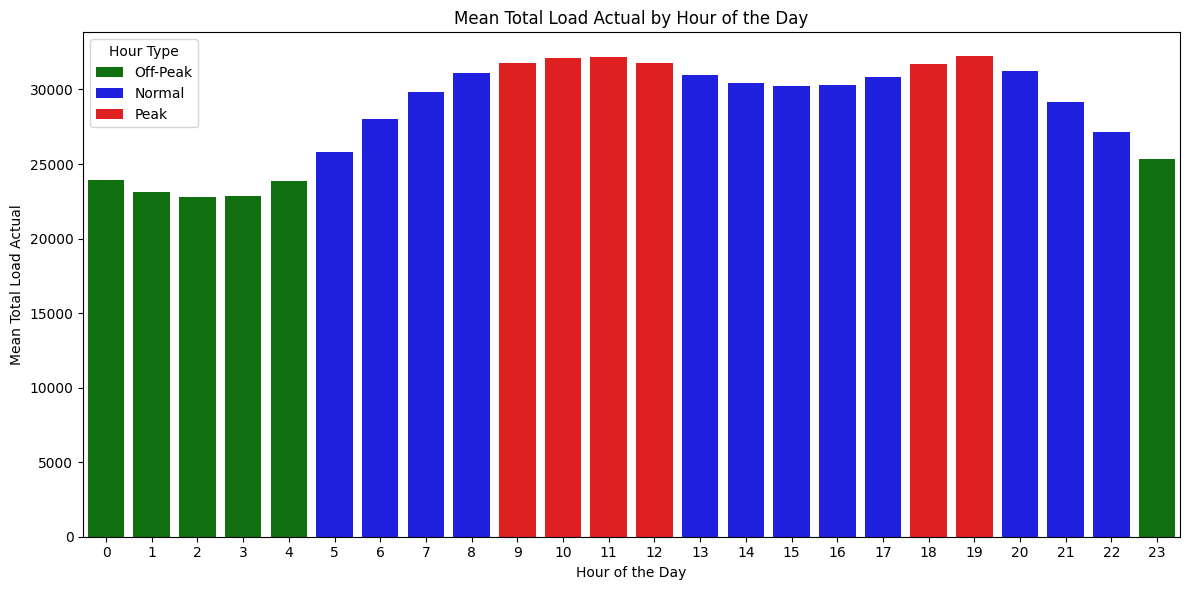

In [39]:
# Calculate the mean 'total load actual' for each hour
hourly_mean_load = df1.groupby('hour')['total load actual'].mean().reset_index()

# Determine thresholds for peak and off-peak hours
quantiles = hourly_mean_load['total load actual'].quantile([0.25, 0.75])
off_peak_threshold = quantiles[0.25]
peak_threshold = quantiles[0.75]

# Classify each hour
hourly_mean_load['hour_type'] = np.where(hourly_mean_load['total load actual'] >= peak_threshold, 'Peak',
                                         np.where(hourly_mean_load['total load actual'] <= off_peak_threshold, 'Off-Peak', 'Normal'))

# Plotting the bar plot with different colors for peak, off-peak, and normal hours
plt.figure(figsize=(12, 6))
sns.barplot(x='hour', y='total load actual', hue='hour_type', data=hourly_mean_load, palette={'Peak': 'red', 'Off-Peak': 'green', 'Normal': 'blue'})
plt.title('Mean Total Load Actual by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Total Load Actual')
plt.xticks(rotation=0)
plt.legend(title='Hour Type')
plt.tight_layout()
plt.show()

Peak hours : 9 to 12 and 18-19
Off-Peak hours : 0 to 4 and 23

In [40]:
# Define peak, off-peak, and normal hours
peak_hours = [9, 10, 11, 12, 18, 19]
off_peak_hours = [0, 1, 2, 3, 4, 23]
normal_hours = [5, 6, 7, 8, 13, 14, 15, 16, 17, 20, 21, 22]

# Create new columns and mark 1 based on the hour type
hourly_mean_load['Peak'] = np.where(hourly_mean_load['hour'].isin(peak_hours), 1, 0)
hourly_mean_load['Off-Peak'] = np.where(hourly_mean_load['hour'].isin(off_peak_hours), 1, 0)
hourly_mean_load['Normal'] = np.where(hourly_mean_load['hour'].isin(normal_hours), 1, 0)

# Display the updated dataframe with the new columns
print(hourly_mean_load.head(2))

   hour  total load actual hour_type  Peak  Off-Peak  Normal
0     0       23951.776865  Off-Peak     0         1       0
1     1       23147.889802  Off-Peak     0         1       0


In [41]:
# Merge hourly_mean_load with df1 on 'hour' column
df1 = df1.merge(hourly_mean_load[['hour', 'Peak', 'Off-Peak', 'Normal']], on='hour', how='left')

# Display the updated df1 dataset
print(df1.head())

                   datetime  generation biomass  \
0 2014-12-31 23:00:00+00:00               447.0   
1 2015-01-01 00:00:00+00:00               449.0   
2 2015-01-01 01:00:00+00:00               448.0   
3 2015-01-01 02:00:00+00:00               438.0   
4 2015-01-01 03:00:00+00:00               428.0   

   generation fossil brown coal/lignite  generation fossil gas  \
0                                 329.0                 4844.0   
1                                 328.0                 5196.0   
2                                 323.0                 4857.0   
3                                 254.0                 4314.0   
4                                 187.0                 4130.0   

   generation fossil hard coal  generation fossil oil  \
0                       4821.0                  162.5   
1                       4755.0                  162.5   
2                       4581.0                  162.5   
3                       4131.0                  162.5   
4          

In [42]:
df1.columns

Index(['datetime', 'generation biomass',
       'generation fossil brown coal/lignite', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all',
       'weather_id', 'hour', 'month', 'day', 'weekday', 'is_weekend', 'clear',
       'clouds', 'drizzle', 'fog', 'haze', 'mist', 'rain', 'snow',
       'thunderstorm', 'broken clouds', 'few clouds', 'heavy intensity rain'

### Encoding season in a binary way

Mapping each month to its corresponding season and creating a new season column

In [43]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'

# Apply the function to create a new column 'season'
df1['season'] = df1['month'].apply(get_season)

# Display the first few rows to verify the new columns
print(df1[['datetime', 'month', 'season']].head())

                   datetime  month  season
0 2014-12-31 23:00:00+00:00     12  winter
1 2015-01-01 00:00:00+00:00      1  winter
2 2015-01-01 01:00:00+00:00      1  winter
3 2015-01-01 02:00:00+00:00      1  winter
4 2015-01-01 03:00:00+00:00      1  winter


In [44]:
# Create new columns for each season and initialize them with 0
df1['winter'] = 0
df1['spring'] = 0
df1['summer'] = 0
df1['fall'] = 0

# Mark 1 against the corresponding season column
df1.loc[df1['season'] == 'winter', 'winter'] = 1
df1.loc[df1['season'] == 'spring', 'spring'] = 1
df1.loc[df1['season'] == 'summer', 'summer'] = 1
df1.loc[df1['season'] == 'fall', 'fall'] = 1

# Display the updated df1 dataset
print(df1.head(2))

                   datetime  generation biomass  \
0 2014-12-31 23:00:00+00:00               447.0   
1 2015-01-01 00:00:00+00:00               449.0   

   generation fossil brown coal/lignite  generation fossil gas  \
0                                 329.0                 4844.0   
1                                 328.0                 5196.0   

   generation fossil hard coal  generation fossil oil  \
0                       4821.0                  162.5   
1                       4755.0                  162.5   

   generation hydro pumped storage consumption  \
0                                        863.0   
1                                        920.0   

   generation hydro run-of-river and poundage  \
0                                      1051.0   
1                                      1009.0   

   generation hydro water reservoir  generation nuclear  ...  Saturday  \
0                            1899.0              7096.0  ...         0   
1                           

In [45]:
df1 = df1.drop(columns=['season'])

In [46]:
df1.columns

Index(['datetime', 'generation biomass',
       'generation fossil brown coal/lignite', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all',
       'weather_id', 'hour', 'month', 'day', 'weekday', 'is_weekend', 'clear',
       'clouds', 'drizzle', 'fog', 'haze', 'mist', 'rain', 'snow',
       'thunderstorm', 'broken clouds', 'few clouds', 'heavy intensity rain'

In [47]:
df1['is_weekend'].head()

0    False
1    False
2    False
3    False
4    False
Name: is_weekend, dtype: bool

In [48]:
# Convert boolean values to integers (0 for False, 1 for True)
df1['is_weekend'] = df1['is_weekend'].astype(int)

# Display the updated df1 dataset
print(df1['is_weekend'].head())

0    0
1    0
2    0
3    0
4    0
Name: is_weekend, dtype: int64


In [49]:
# Assuming df1 is your DataFrame
columns_with_strings = df1.select_dtypes(include=['object']).columns.tolist()

# Display columns with string values
print("Columns with string values:")
print(columns_with_strings)

Columns with string values:
['weekday']


# Data visualization

In [57]:
df1.columns

Index(['datetime', 'generation biomass',
       'generation fossil brown coal/lignite', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all',
       'weather_id', 'hour', 'month', 'day', 'weekday', 'is_weekend', 'clear',
       'clouds', 'drizzle', 'fog', 'haze', 'mist', 'rain', 'snow',
       'thunderstorm', 'broken clouds', 'few clouds', 'heavy intensity rain'

Plotting time series of energy demand (total load actual) and weather variables (temperature, pressure, humidity) over time can help identify trends and seasonal patterns.

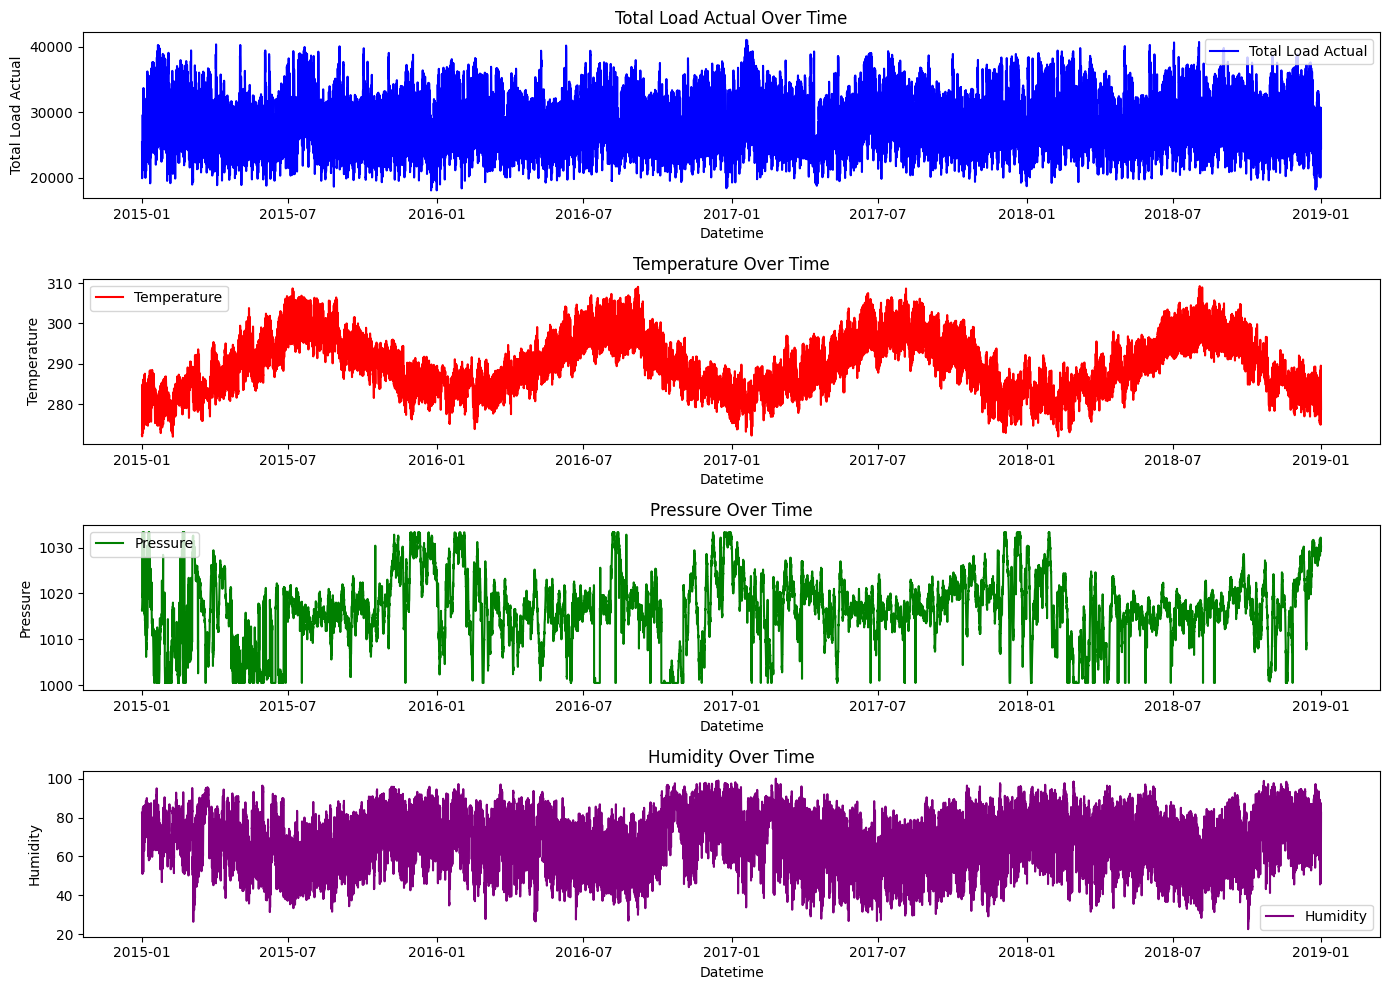

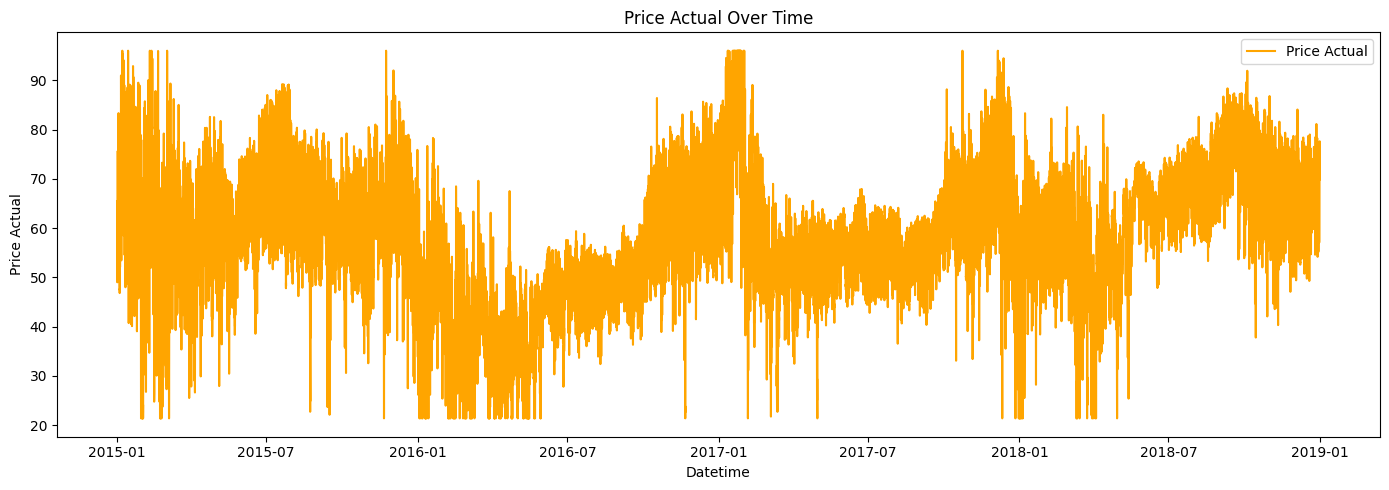

In [58]:
# Plot time series of total load actual
plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(df1['datetime'], df1['total load actual'], label='Total Load Actual', color='blue')
plt.title('Total Load Actual Over Time')
plt.xlabel('Datetime')
plt.ylabel('Total Load Actual')
plt.legend()

# Plot time series of temperature
plt.subplot(4, 1, 2)
plt.plot(df1['datetime'], df1['temp'], label='Temperature', color='red')
plt.title('Temperature Over Time')
plt.xlabel('Datetime')
plt.ylabel('Temperature')
plt.legend()

# Plot time series of pressure
plt.subplot(4, 1, 3)
plt.plot(df1['datetime'], df1['pressure'], label='Pressure', color='green')
plt.title('Pressure Over Time')
plt.xlabel('Datetime')
plt.ylabel('Pressure')
plt.legend()

# Plot time series of humidity
plt.subplot(4, 1, 4)
plt.plot(df1['datetime'], df1['humidity'], label='Humidity', color='purple')
plt.title('Humidity Over Time')
plt.xlabel('Datetime')
plt.ylabel('Humidity')
plt.legend()

plt.tight_layout()
plt.show()

# Plot time series of price actual
plt.figure(figsize=(14, 5))
plt.plot(df1['datetime'], df1['price actual'], label='Price Actual', color='orange')
plt.title('Price Actual Over Time')
plt.xlabel('Datetime')
plt.ylabel('Price Actual')
plt.legend()

plt.tight_layout()
plt.show()

aggregate at month level and weekdays/weekend only year by year and quater as well and days of the week

In [59]:
df1_monthly = df1.groupby('month').agg({
    'total load actual': 'mean',
    'temp': 'mean',
    'pressure': 'mean',
    'humidity': 'mean',
    'price actual': 'mean'
}).reset_index()


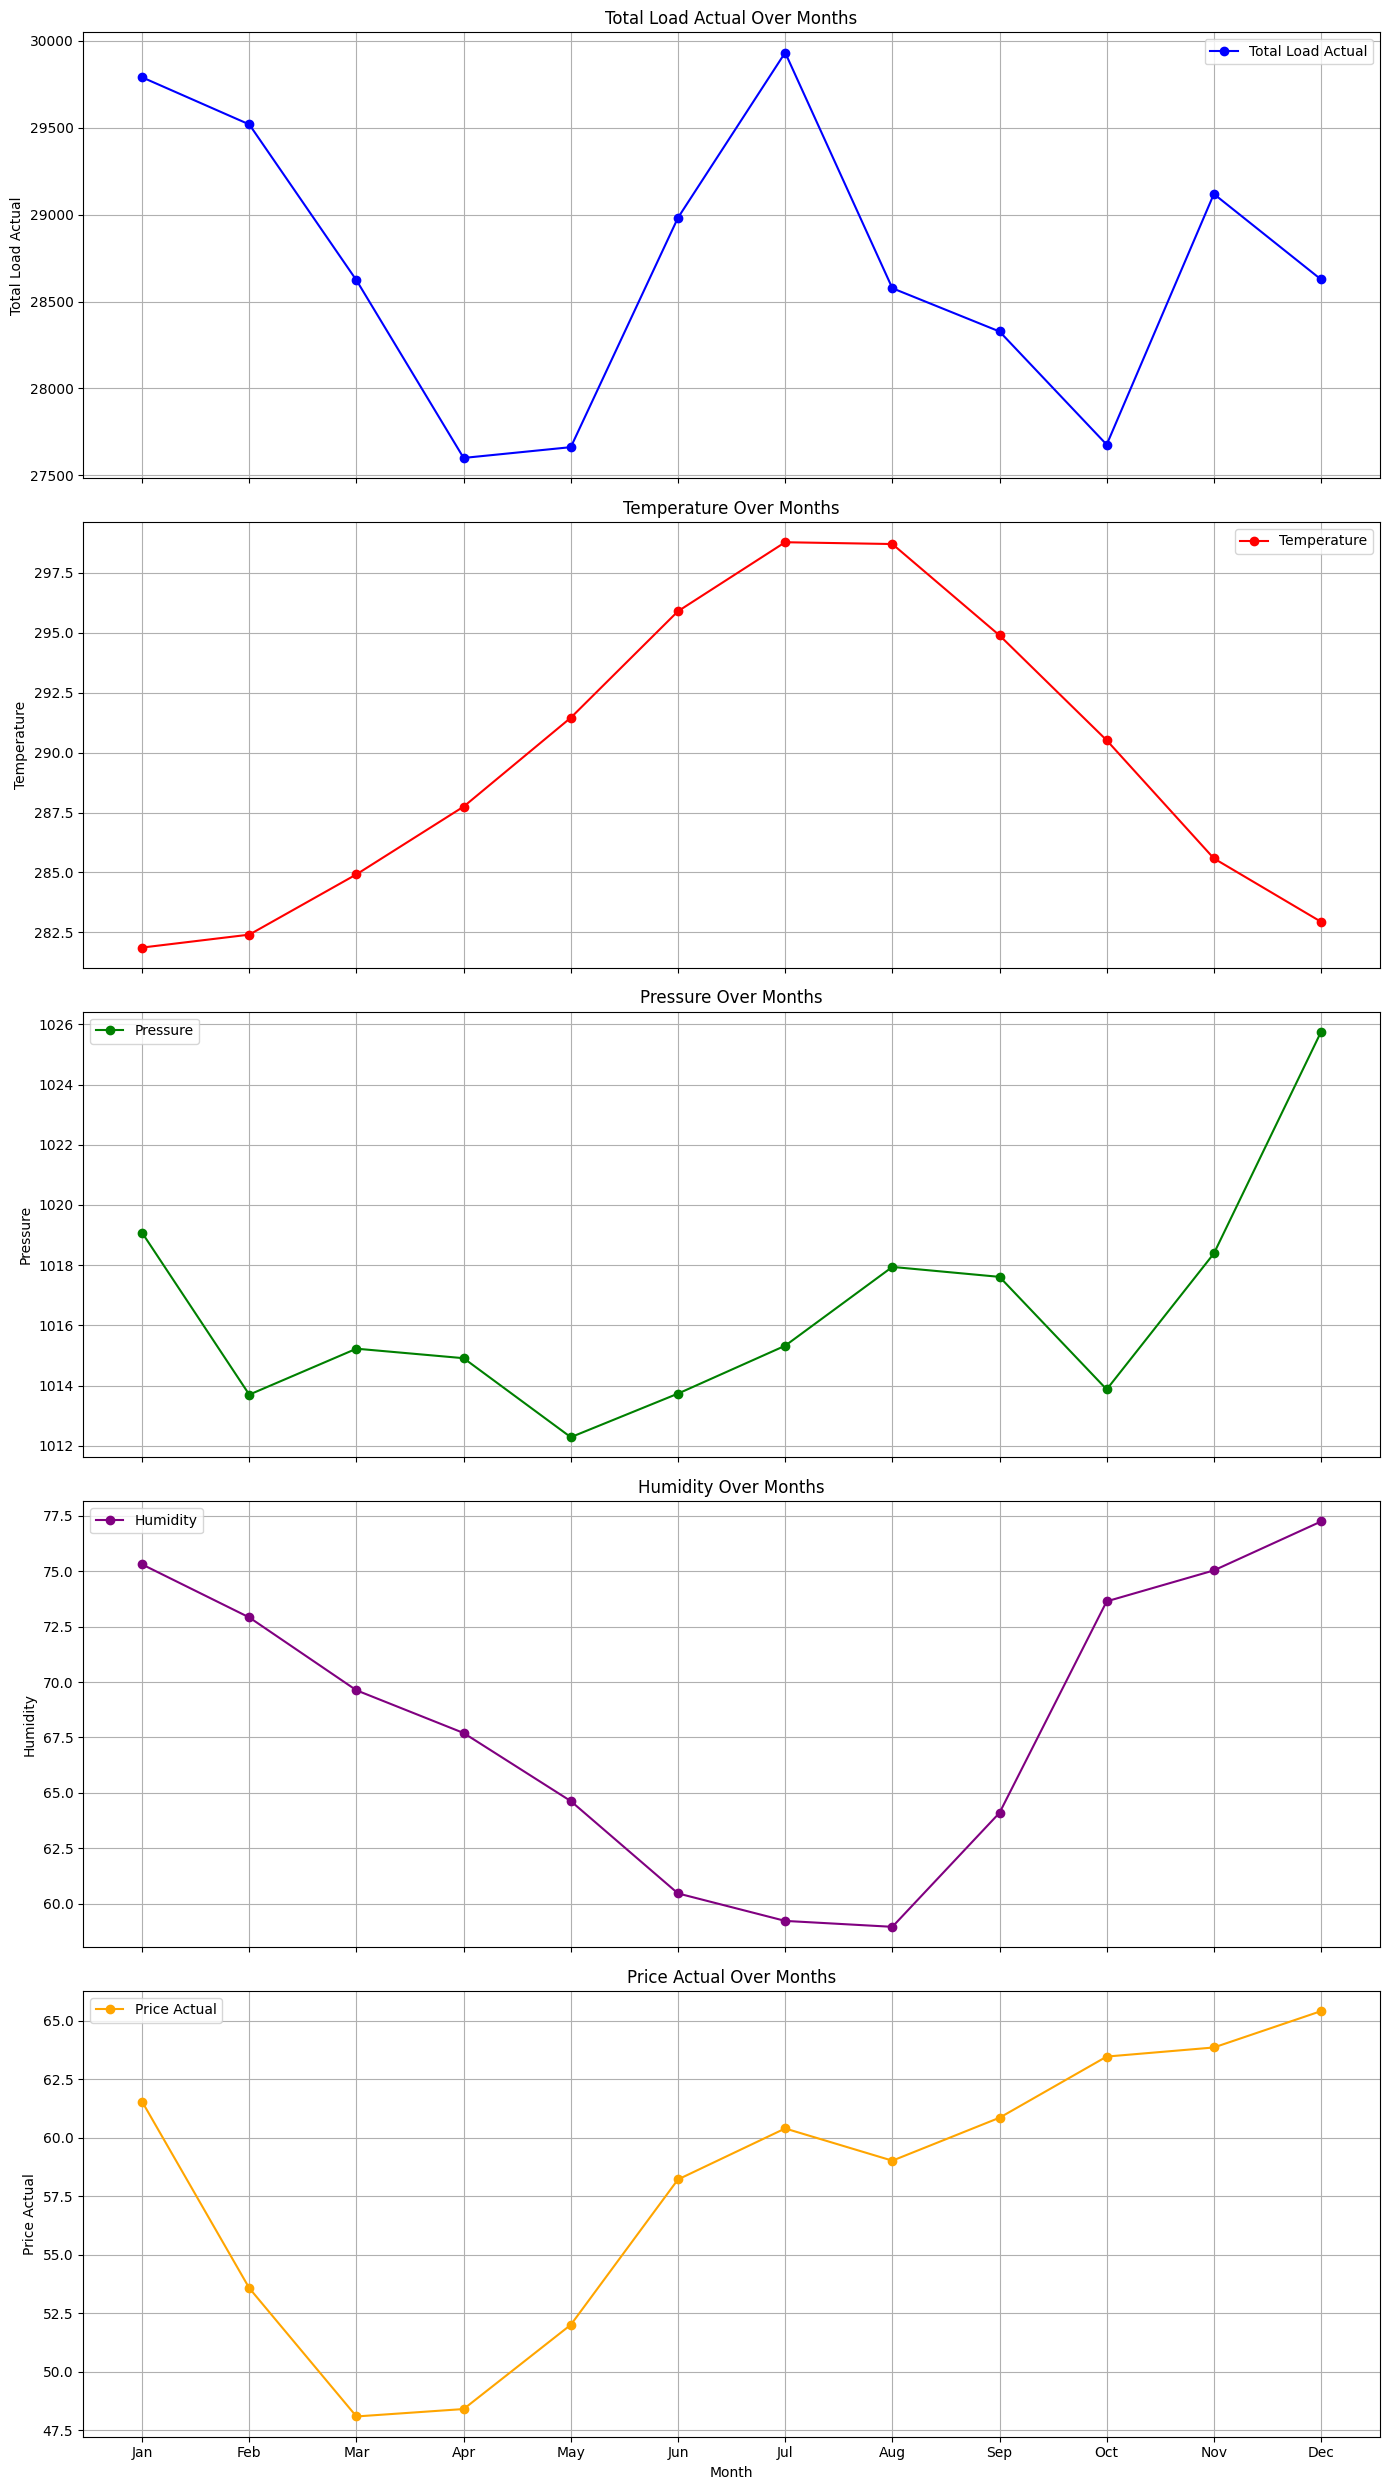

In [60]:
# Create a figure with subplots
fig, axes = plt.subplots(5, 1, figsize=(14, 25), sharex=True)

# Plot total load actual
axes[0].plot(df1_monthly['month'], df1_monthly['total load actual'], label='Total Load Actual', marker='o', color='blue')
axes[0].set_ylabel('Total Load Actual')
axes[0].set_title('Total Load Actual Over Months')
axes[0].grid(True)
axes[0].legend()
axes[0].set_xticks(range(1, 13))
axes[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Plot temperature
axes[1].plot(df1_monthly['month'], df1_monthly['temp'], label='Temperature', marker='o', color='red')
axes[1].set_ylabel('Temperature')
axes[1].set_title('Temperature Over Months')
axes[1].grid(True)
axes[1].legend()
axes[1].set_xticks(range(1, 13))
axes[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Plot pressure
axes[2].plot(df1_monthly['month'], df1_monthly['pressure'], label='Pressure', marker='o', color='green')
axes[2].set_ylabel('Pressure')
axes[2].set_title('Pressure Over Months')
axes[2].grid(True)
axes[2].legend()
axes[2].set_xticks(range(1, 13))
axes[2].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Plot humidity
axes[3].plot(df1_monthly['month'], df1_monthly['humidity'], label='Humidity', marker='o', color='purple')
axes[3].set_ylabel('Humidity')
axes[3].set_title('Humidity Over Months')
axes[3].grid(True)
axes[3].legend()
axes[3].set_xticks(range(1, 13))
axes[3].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Plot price actual
axes[4].plot(df1_monthly['month'], df1_monthly['price actual'], label='Price Actual', marker='o', color='orange')
axes[4].set_ylabel('Price Actual')
axes[4].set_title('Price Actual Over Months')
axes[4].set_xlabel('Month')
axes[4].grid(True)
axes[4].legend()
axes[4].set_xticks(range(1, 13))
axes[4].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()

(-1.0999999741362518,
 1.0999999546811714,
 -1.099999978334342,
 1.0999999988900542)

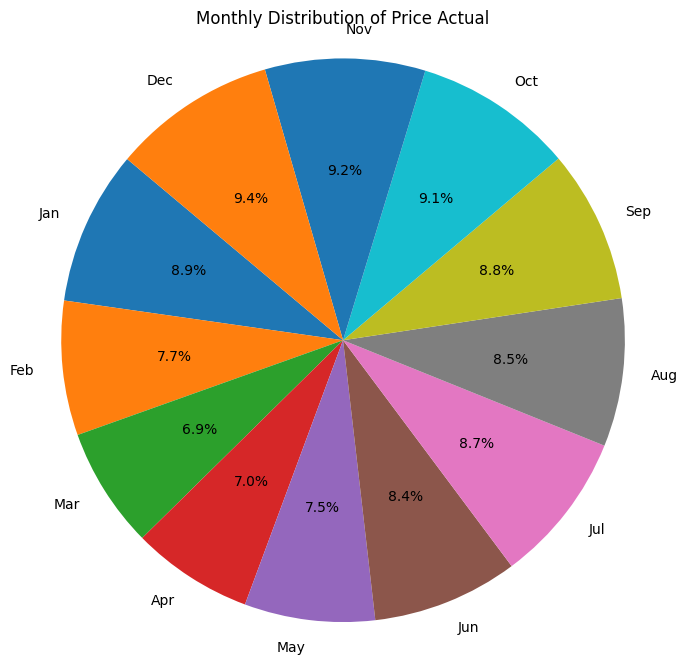

In [61]:
# Labels for the pie chart
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Data for the pie chart (using mean total load actual)
data = df1_monthly['price actual']

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(data, labels=labels, autopct='%0.001f%%', startangle=140)
plt.title('Monthly Distribution of Price Actual')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

Visualizing the distribution of continuous variables like temperature, pressure, humidity, and energy demand to understand their ranges and central tendencies

Comparing the distributions of energy demand across different months to understand variability and potential outliers

Scatter Plot: Energy Demand vs. Temperature

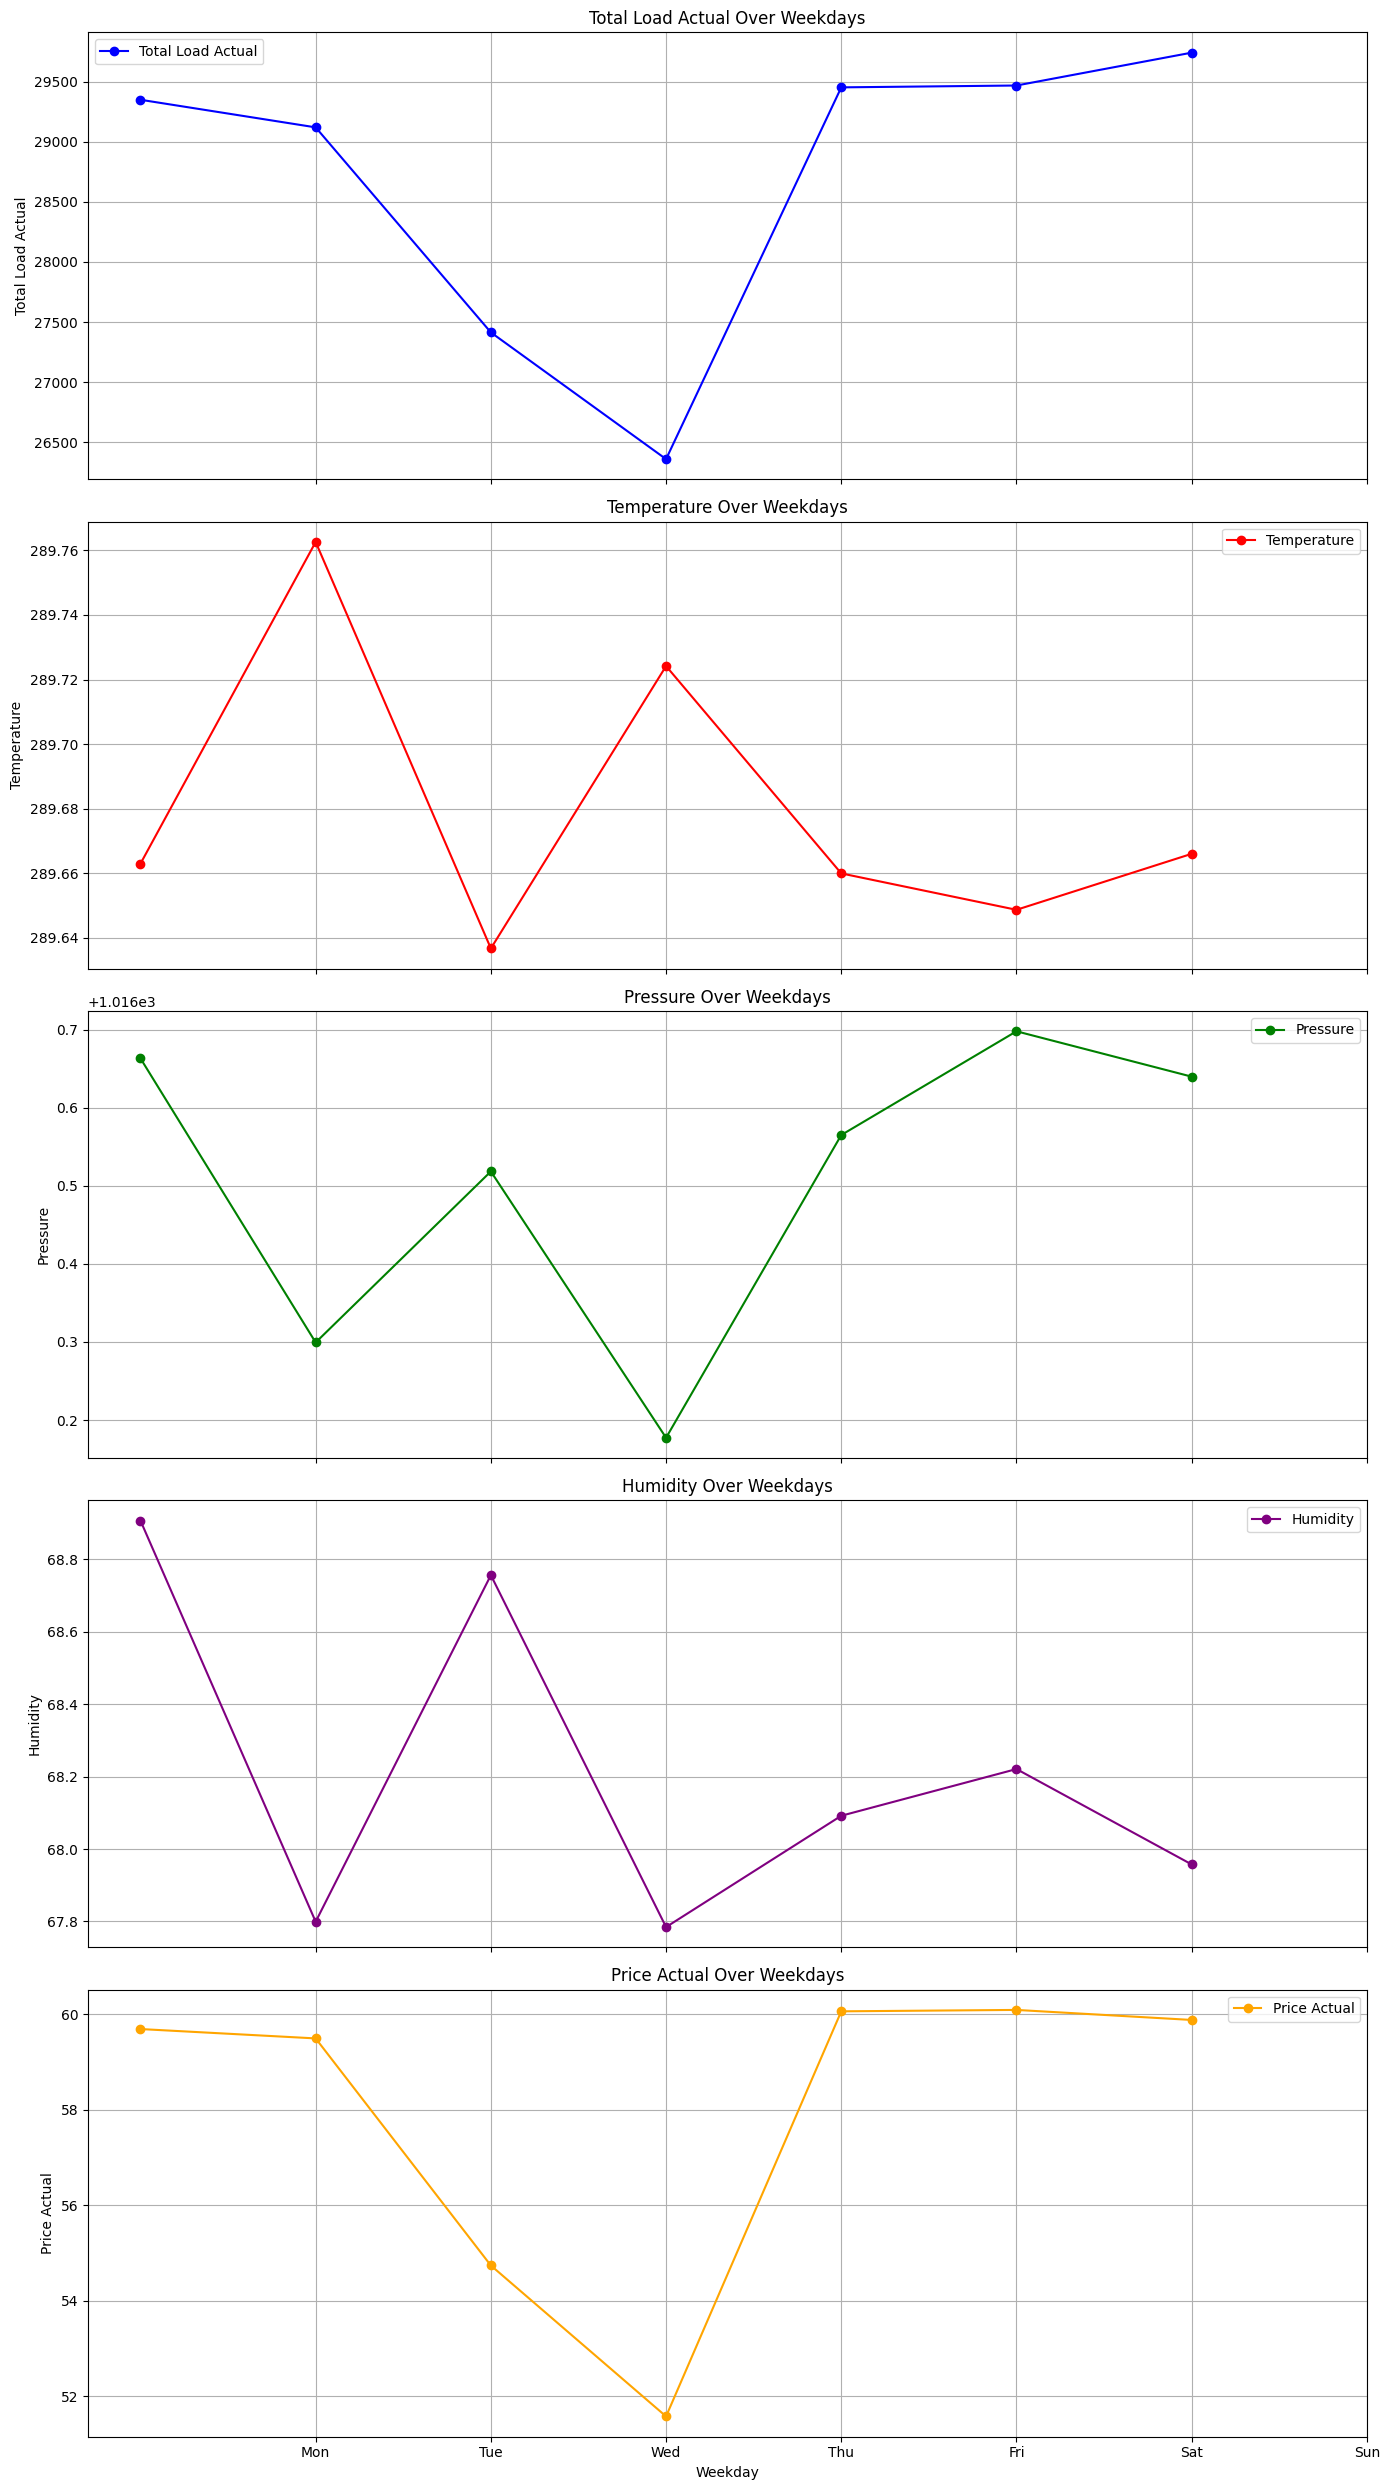

In [62]:
df1_weekly = df1.groupby('weekday').agg({
    'total load actual': 'mean',
    'temp': 'mean',
    'pressure': 'mean',
    'humidity': 'mean',
    'price actual': 'mean'
}).reset_index()
# Create a figure with subplots
fig, axes = plt.subplots(5, 1, figsize=(14, 25), sharex=True)

# Weekday names for labeling
weekday_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Plot total load actual
axes[0].plot(df1_weekly['weekday'], df1_weekly['total load actual'], label='Total Load Actual', marker='o', color='blue')
axes[0].set_ylabel('Total Load Actual')
axes[0].set_title('Total Load Actual Over Weekdays')
axes[0].grid(True)
axes[0].legend()
axes[0].set_xticks(range(1, 8))
axes[0].set_xticklabels(weekday_names)

# Plot temperature
axes[1].plot(df1_weekly['weekday'], df1_weekly['temp'], label='Temperature', marker='o', color='red')
axes[1].set_ylabel('Temperature')
axes[1].set_title('Temperature Over Weekdays')
axes[1].grid(True)
axes[1].legend()
axes[1].set_xticks(range(1, 8))
axes[1].set_xticklabels(weekday_names)

# Plot pressure
axes[2].plot(df1_weekly['weekday'], df1_weekly['pressure'], label='Pressure', marker='o', color='green')
axes[2].set_ylabel('Pressure')
axes[2].set_title('Pressure Over Weekdays')
axes[2].grid(True)
axes[2].legend()
axes[2].set_xticks(range(1, 8))
axes[2].set_xticklabels(weekday_names)

# Plot humidity
axes[3].plot(df1_weekly['weekday'], df1_weekly['humidity'], label='Humidity', marker='o', color='purple')
axes[3].set_ylabel('Humidity')
axes[3].set_title('Humidity Over Weekdays')
axes[3].grid(True)
axes[3].legend()
axes[3].set_xticks(range(1, 8))
axes[3].set_xticklabels(weekday_names)

# Plot price actual
axes[4].plot(df1_weekly['weekday'], df1_weekly['price actual'], label='Price Actual', marker='o', color='orange')
axes[4].set_ylabel('Price Actual')
axes[4].set_title('Price Actual Over Weekdays')
axes[4].set_xlabel('Weekday')
axes[4].grid(True)
axes[4].legend()
axes[4].set_xticks(range(1, 8))
axes[4].set_xticklabels(weekday_names)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()

In [63]:
df1.columns

Index(['datetime', 'generation biomass',
       'generation fossil brown coal/lignite', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all',
       'weather_id', 'hour', 'month', 'day', 'weekday', 'is_weekend', 'clear',
       'clouds', 'drizzle', 'fog', 'haze', 'mist', 'rain', 'snow',
       'thunderstorm', 'broken clouds', 'few clouds', 'heavy intensity rain'

Heatmap: Correlation between Weather Variables and Energy Demand

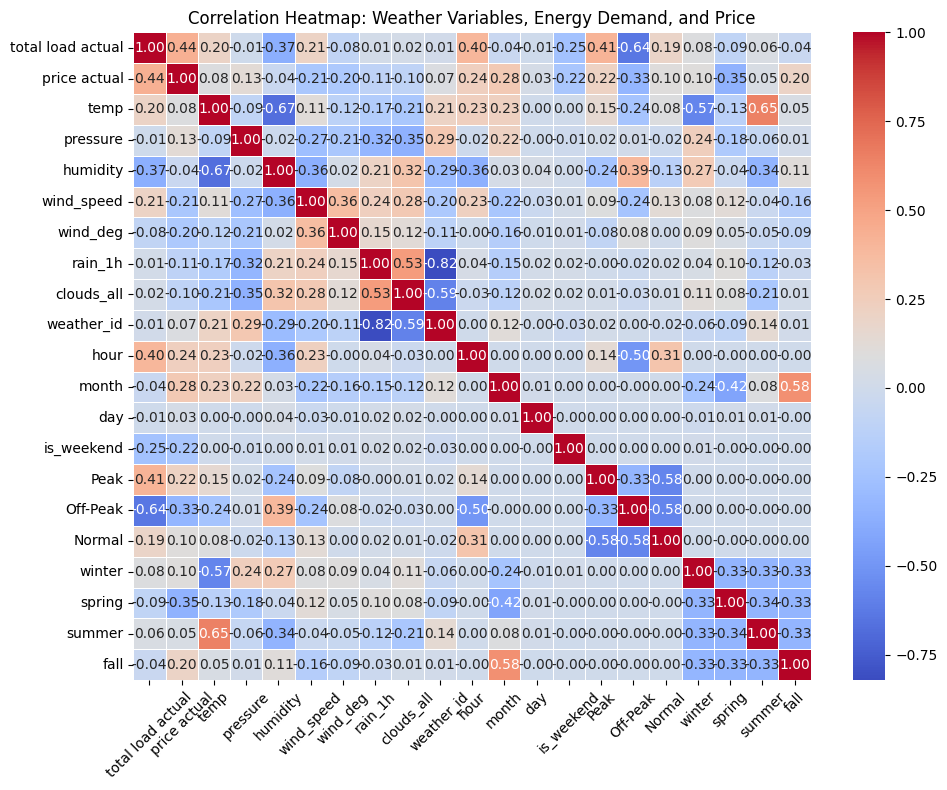

In [64]:
# List of columns to exclude
exclude_columns = [
    'datetime', 'generation biomass',
       'generation fossil brown coal/lignite', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage','weekday','rain_3h', 'snow_3h','temp_min', 'temp_max',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar','total load forecast','price day ahead',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
         'clear',
       'clouds', 'drizzle', 'fog', 'haze', 'mist', 'rain', 'snow',
       'thunderstorm', 'broken clouds', 'few clouds', 'heavy intensity rain',
       'light intensity drizzle', 'light intensity shower rain', 'light rain',
       'light snow', 'moderate rain', 'overcast clouds',
       'proximity shower rain', 'proximity thunderstorm', 'scattered clouds',
       'shower rain', 'sky is clear', '01d', '01n', '02d', '02n', '03d', '03n',
       '04d', '04n', '09d', '09n', '1', '10', '10d', '10n', '11d', '11n',
       '13d', '13n', '2', '3', '4', '50d', '50n', 'Monday', 'Tuesday',
       'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
]

# Selecting numeric columns only and excluding the specified columns
numeric_columns = df1.select_dtypes(include=[np.number]).columns
numeric_columns = [col for col in numeric_columns if col not in exclude_columns]

# Calculate the correlation matrix for the selected numeric columns
corr_matrix = df1[numeric_columns].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap: Weather Variables, Energy Demand, and Price')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

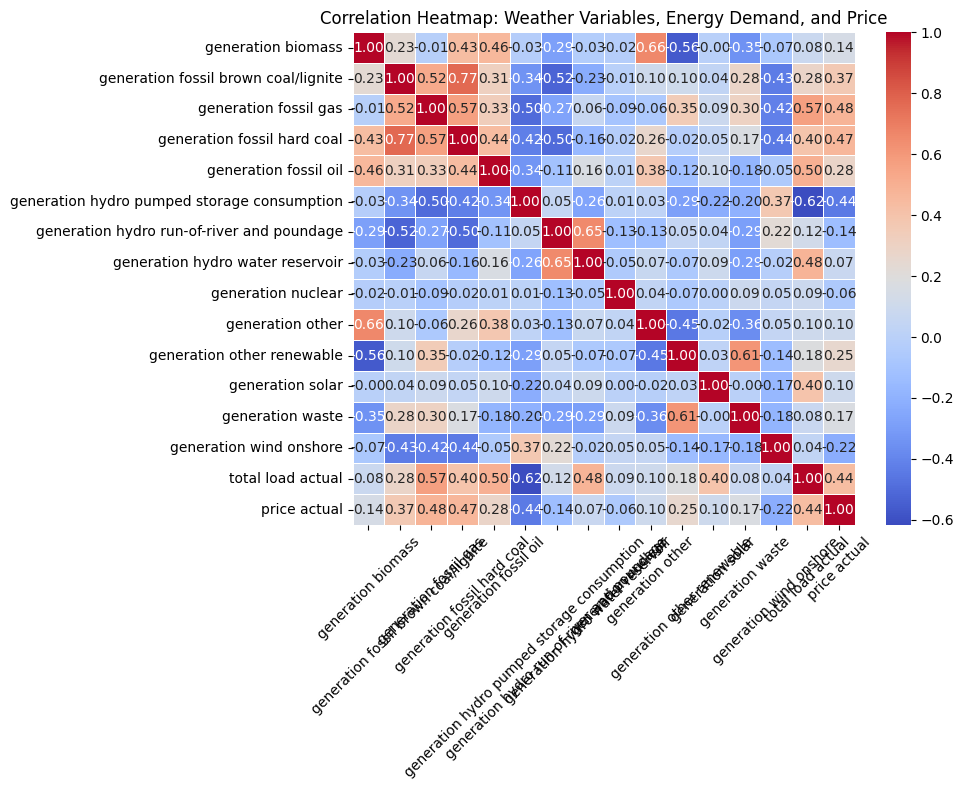

In [65]:
# List of columns to exclude
exclude_columns = [
    'datetime',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast',  'price day ahead',
       'temp', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all',
       'weather_id', 'hour', 'month', 'day', 'weekday', 'is_weekend', 'clear',
       'clouds', 'drizzle', 'fog', 'haze', 'mist', 'rain', 'snow',
       'thunderstorm', 'broken clouds', 'few clouds', 'heavy intensity rain',
       'light intensity drizzle', 'light intensity shower rain', 'light rain',
       'light snow', 'moderate rain', 'overcast clouds',
       'proximity shower rain', 'proximity thunderstorm', 'scattered clouds',
       'shower rain', 'sky is clear', '01d', '01n', '02d', '02n', '03d', '03n',
       '04d', '04n', '09d', '09n', '1', '10', '10d', '10n', '11d', '11n',
       '13d', '13n', '2', '3', '4', '50d', '50n', 'Monday', 'Tuesday',
       'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Peak',
       'Off-Peak', 'Normal', 'winter', 'spring', 'summer', 'fall'

]

# Selecting numeric columns only and excluding the specified columns
numeric_columns = df1.select_dtypes(include=[np.number]).columns
numeric_columns = [col for col in numeric_columns if col not in exclude_columns]

# Calculate the correlation matrix for the selected numeric columns
corr_matrix = df1[numeric_columns].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap: Weather Variables, Energy Demand, and Price')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

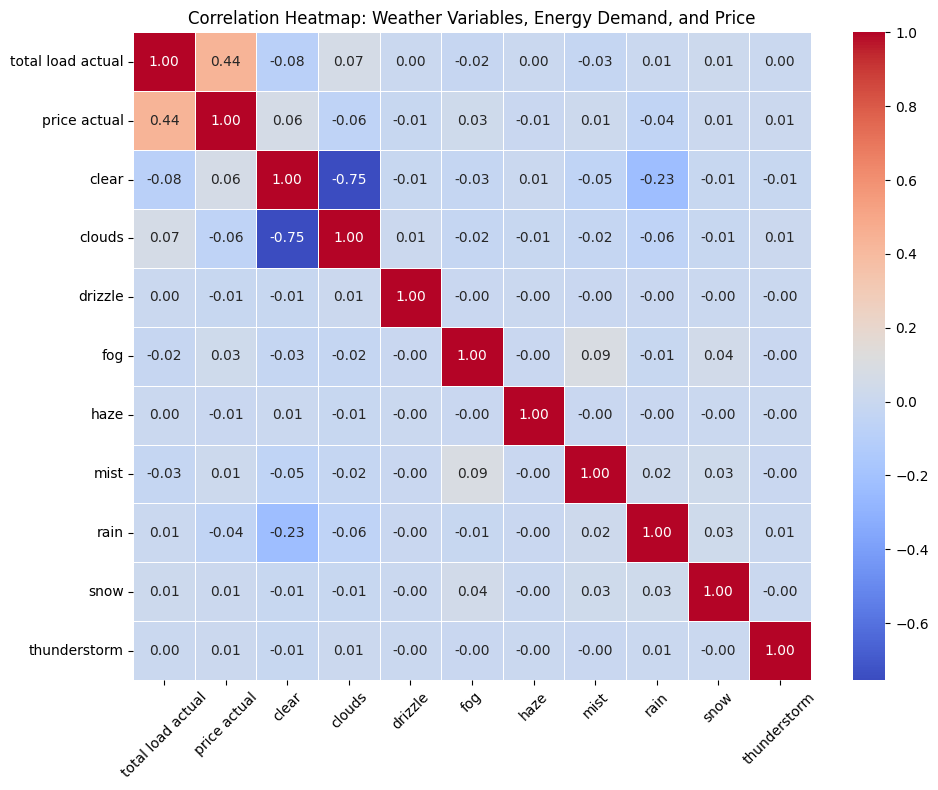

In [66]:
# List of columns to exclude
exclude_columns = [
    'datetime', 'generation biomass',
       'generation fossil brown coal/lignite', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast',  'price day ahead',
       'temp', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all',
       'weather_id', 'hour', 'month', 'day', 'weekday', 'is_weekend', 'broken clouds', 'few clouds', 'heavy intensity rain',
       'light intensity drizzle', 'light intensity shower rain', 'light rain',
       'light snow', 'moderate rain', 'overcast clouds',
       'proximity shower rain', 'proximity thunderstorm', 'scattered clouds',
       'shower rain', 'sky is clear', '01d', '01n', '02d', '02n', '03d', '03n',
       '04d', '04n', '09d', '09n', '1', '10', '10d', '10n', '11d', '11n',
       '13d', '13n', '2', '3', '4', '50d', '50n', 'Monday', 'Tuesday',
       'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Peak',
       'Off-Peak', 'Normal', 'winter', 'spring', 'summer', 'fall'

]

# Selecting numeric columns only and excluding the specified columns
numeric_columns = df1.select_dtypes(include=[np.number]).columns
numeric_columns = [col for col in numeric_columns if col not in exclude_columns]

# Calculate the correlation matrix for the selected numeric columns
corr_matrix = df1[numeric_columns].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap: Weather Variables, Energy Demand, and Price')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

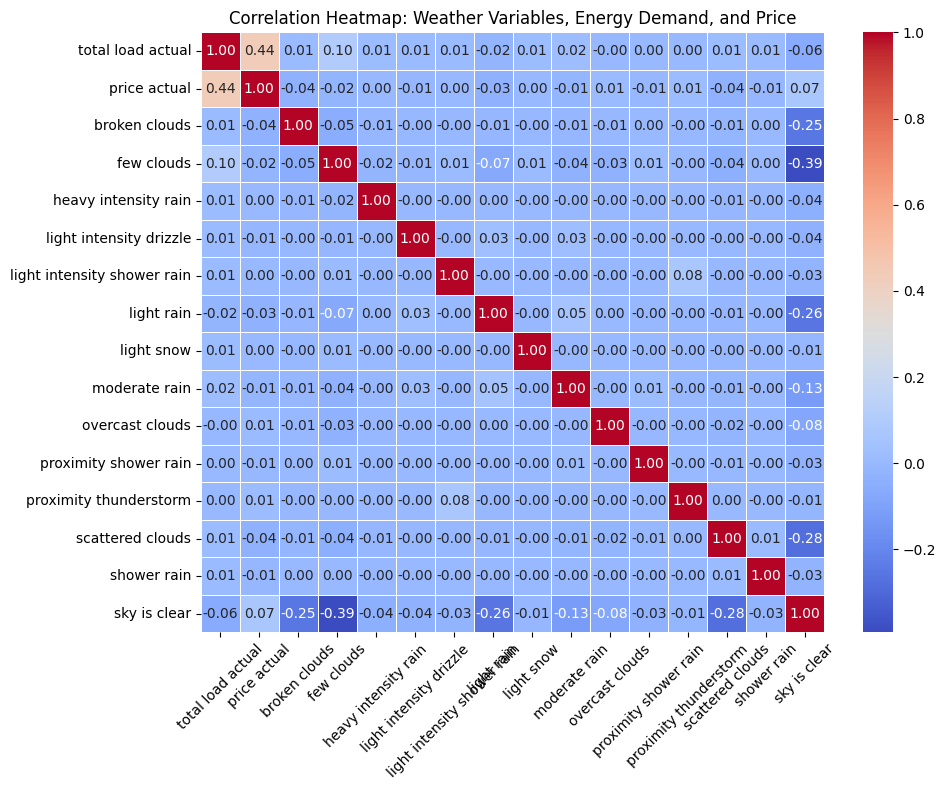

In [67]:
# List of columns to exclude
exclude_columns = [
    'datetime', 'generation biomass',
       'generation fossil brown coal/lignite', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast',  'price day ahead',
        'temp', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all',
       'weather_id', 'hour', 'month', 'day', 'weekday', 'is_weekend', 'clear',
       'clouds', 'drizzle', 'fog', 'haze', 'mist', 'rain', 'snow',
       'thunderstorm',  '01d', '01n', '02d', '02n', '03d', '03n',
       '04d', '04n', '09d', '09n', '1', '10', '10d', '10n', '11d', '11n',
       '13d', '13n', '2', '3', '4', '50d', '50n', 'Monday', 'Tuesday',
       'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Peak',
       'Off-Peak', 'Normal', 'winter', 'spring', 'summer', 'fall'

]

# Selecting numeric columns only and excluding the specified columns
numeric_columns = df1.select_dtypes(include=[np.number]).columns
numeric_columns = [col for col in numeric_columns if col not in exclude_columns]

# Calculate the correlation matrix for the selected numeric columns
corr_matrix = df1[numeric_columns].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap: Weather Variables, Energy Demand, and Price')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

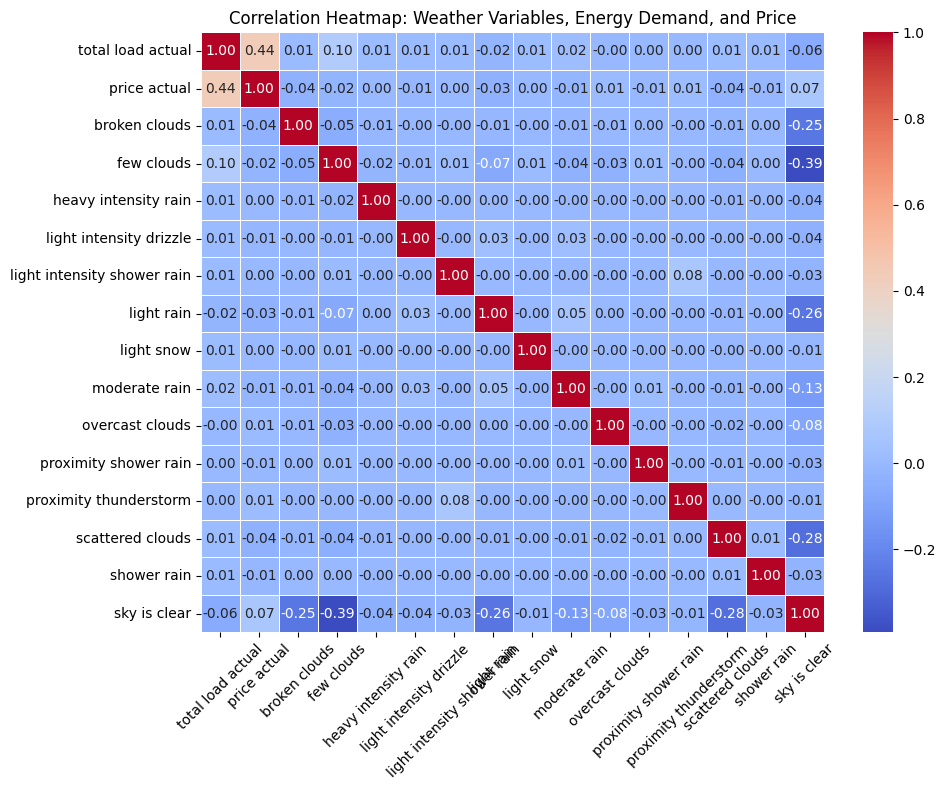

In [68]:
# List of columns to exclude
exclude_columns = [
    'datetime', 'generation biomass',
       'generation fossil brown coal/lignite', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'price day ahead',
       'temp', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all',
       'weather_id', 'hour', 'month', 'day', 'weekday', 'is_weekend', 'clear',
       'clouds', 'drizzle', 'fog', 'haze', 'mist', 'rain', 'snow',
       'thunderstorm',  '01d', '01n', '02d', '02n', '03d', '03n',
       '04d', '04n', '09d', '09n', '1', '10', '10d', '10n', '11d', '11n',
       '13d', '13n', '2', '3', '4', '50d', '50n', 'Monday', 'Tuesday',
       'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Peak',
       'Off-Peak', 'Normal', 'winter', 'spring', 'summer', 'fall'

]

# Selecting numeric columns only and excluding the specified columns
numeric_columns = df1.select_dtypes(include=[np.number]).columns
numeric_columns = [col for col in numeric_columns if col not in exclude_columns]

# Calculate the correlation matrix for the selected numeric columns
corr_matrix = df1[numeric_columns].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap: Weather Variables, Energy Demand, and Price')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

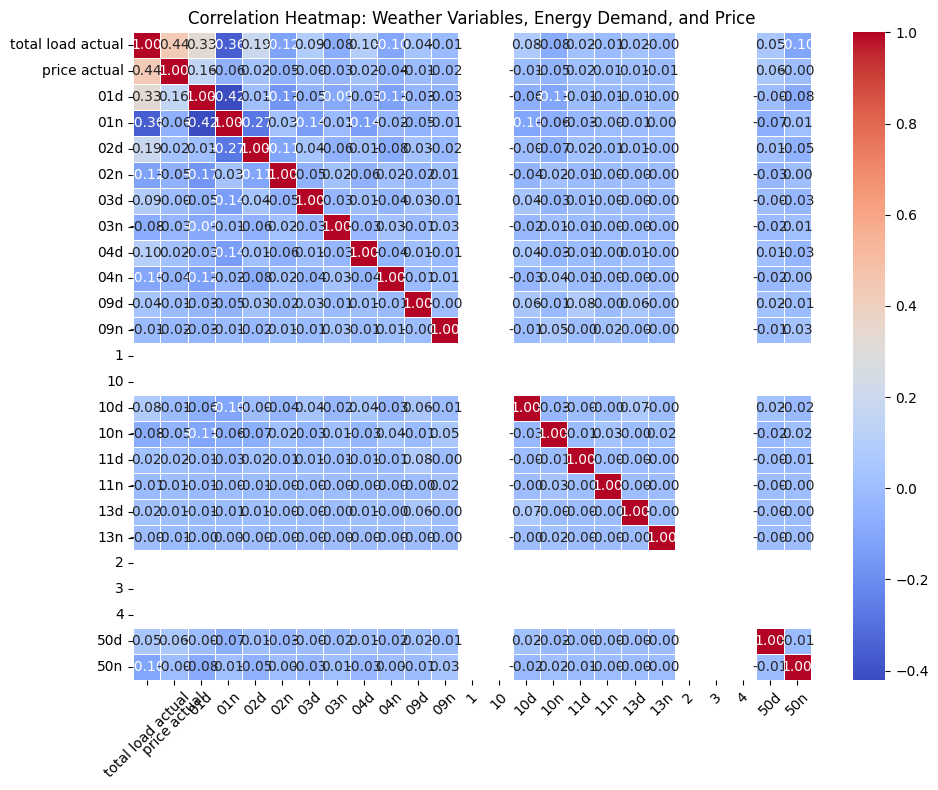

In [69]:
# List of columns to exclude
exclude_columns = [
    'datetime', 'generation biomass',
       'generation fossil brown coal/lignite', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'price day ahead',
        'temp', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all',
       'weather_id', 'hour', 'month', 'day', 'weekday', 'is_weekend', 'clear',
       'clouds', 'drizzle', 'fog', 'haze', 'mist', 'rain', 'snow',
       'thunderstorm', 'broken clouds', 'few clouds', 'heavy intensity rain',
       'light intensity drizzle', 'light intensity shower rain', 'light rain',
       'light snow', 'moderate rain', 'overcast clouds',
       'proximity shower rain', 'proximity thunderstorm', 'scattered clouds',
       'shower rain', 'sky is clear', 'Monday', 'Tuesday',
       'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Peak',
       'Off-Peak', 'Normal', 'winter', 'spring', 'summer', 'fall'

]

# Selecting numeric columns only and excluding the specified columns
numeric_columns = df1.select_dtypes(include=[np.number]).columns
numeric_columns = [col for col in numeric_columns if col not in exclude_columns]

# Calculate the correlation matrix for the selected numeric columns
corr_matrix = df1[numeric_columns].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap: Weather Variables, Energy Demand, and Price')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

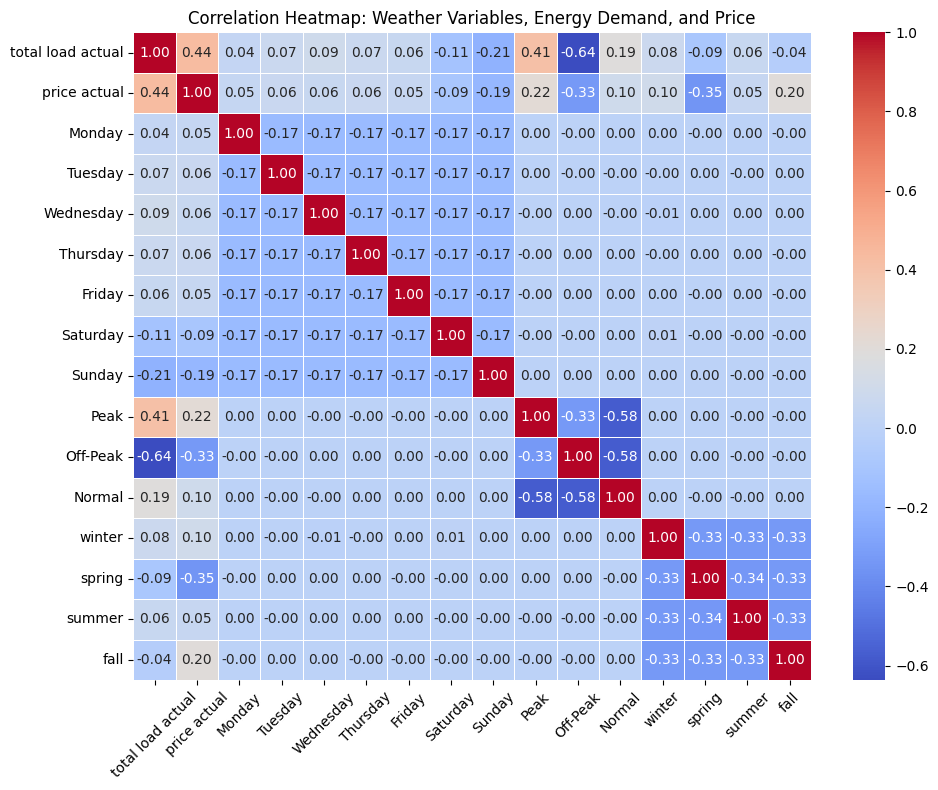

In [70]:
# List of columns to exclude
exclude_columns = [
    'datetime', 'generation biomass',
       'generation fossil brown coal/lignite', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'price day ahead',
        'temp', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all',
       'weather_id', 'hour', 'month', 'day', 'weekday', 'is_weekend', 'clear',
       'clouds', 'drizzle', 'fog', 'haze', 'mist', 'rain', 'snow',
       'thunderstorm', 'broken clouds', 'few clouds', 'heavy intensity rain',
       'light intensity drizzle', 'light intensity shower rain', 'light rain',
       'light snow', 'moderate rain', 'overcast clouds',
       'proximity shower rain', 'proximity thunderstorm', 'scattered clouds',
       'shower rain', 'sky is clear', '01d', '01n', '02d', '02n', '03d', '03n',
       '04d', '04n', '09d', '09n', '1', '10', '10d', '10n', '11d', '11n',
       '13d', '13n', '2', '3', '4', '50d', '50n'
]

# Selecting numeric columns only and excluding the specified columns
numeric_columns = df1.select_dtypes(include=[np.number]).columns
numeric_columns = [col for col in numeric_columns if col not in exclude_columns]

# Calculate the correlation matrix for the selected numeric columns
corr_matrix = df1[numeric_columns].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap: Weather Variables, Energy Demand, and Price')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Comparing average energy demand or weather variables across different categories (e.g., weekdays vs weekends, different months

Bar Chart: Average Energy Demand Across Different Months

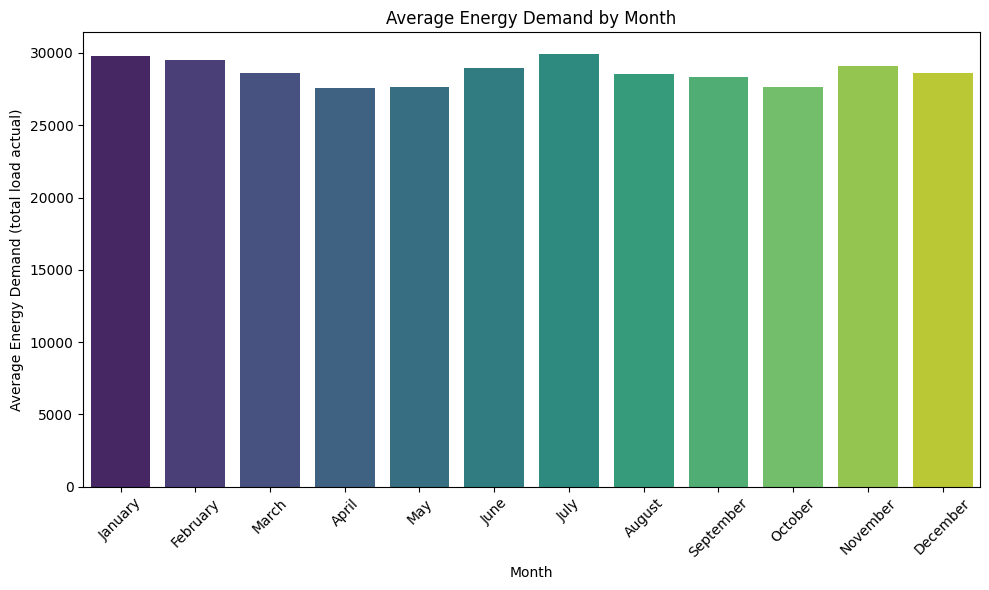

In [71]:
# Ensure that the 'month' column in df1 is a numeric representation of the months
# Create a mapping from numeric month to month name
month_name_mapping = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
                      7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}

# Apply the mapping to convert numeric month to month name
df1['month_name'] = df1['month'].map(month_name_mapping)

# Calculate average energy demand (total load actual) by month
avg_demand_by_month = df1.groupby('month_name')['total load actual'].mean().reset_index()

# Ensure the months are in the correct order
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
avg_demand_by_month['month_name'] = pd.Categorical(avg_demand_by_month['month_name'], categories=months_order, ordered=True)
avg_demand_by_month = avg_demand_by_month.sort_values('month_name')

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='month_name', y='total load actual', data=avg_demand_by_month, hue='month_name', dodge=False, palette='viridis')
plt.title('Average Energy Demand by Month')
plt.xlabel('Month')
plt.ylabel('Average Energy Demand (total load actual)')
plt.xticks(rotation=45)
plt.legend([],[], frameon=False)  # Remove legend
plt.tight_layout()
plt.show()

Bar Chart: Average Temperature Across Weekdays vs Weekends

In [72]:
df1['weekday'].sample(5)

23600       Sunday
20657    Wednesday
15001     Saturday
7092        Friday
11042      Tuesday
Name: weekday, dtype: object

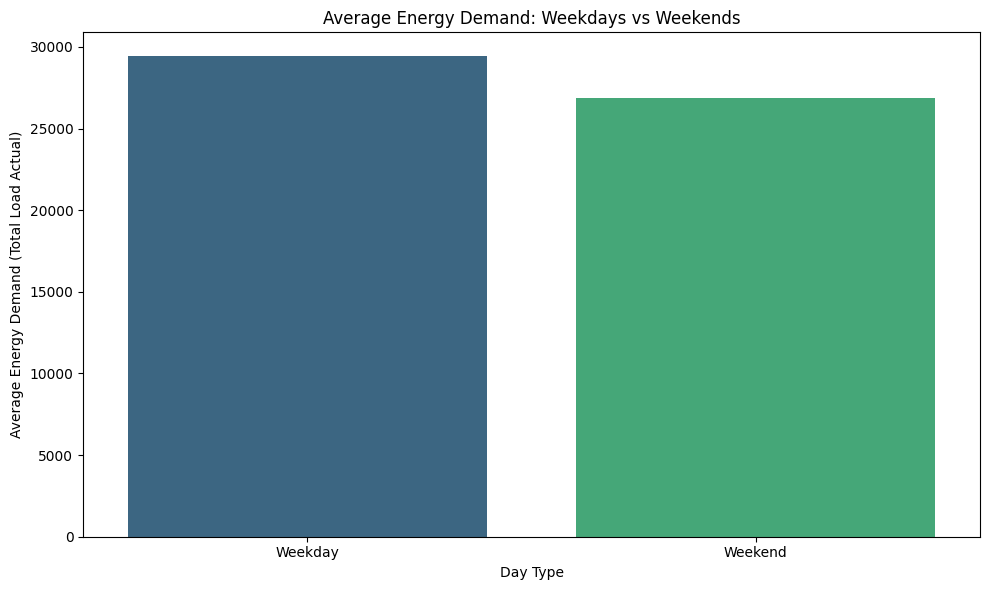

In [73]:
# Assuming df1 contains datetime and total load actual columns
df1['weekday'] = df1['datetime'].dt.dayofweek

# Function to classify weekdays and weekends
def classify_day(day):
    return 'Weekend' if day >= 5 else 'Weekday'

# Apply the function to create a new column 'day_type'
df1['day_type'] = df1['weekday'].apply(classify_day)

# Calculate the mean total load actual for weekdays and weekends
avg_demand_by_day_type = df1.groupby('day_type')['total load actual'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='day_type', y='total load actual', hue='day_type', data=avg_demand_by_day_type, dodge=False, palette='viridis')
plt.title('Average Energy Demand: Weekdays vs Weekends')
plt.xlabel('Day Type')
plt.ylabel('Average Energy Demand (Total Load Actual)')
plt.legend([],[], frameon=False)  # Remove legend
plt.tight_layout()
plt.show()

from time vs pressure plot we can observe there is an outlier which causes very sharp increase of pressure value at that time only hence we have to treat that

In [74]:
# Define features excluding 'total load actual'
features = df1.columns.tolist()

# Splitting data into train (75%) and temp (25%)
train_temp, test = train_test_split(df1, test_size=0.25, random_state=42)

# Splitting temp into validation (15%) and test (10%)
train, validation = train_test_split(train_temp, test_size=0.6, random_state=42)

# Checking the dimensions of the data
print(f'Train dataset shape: {train.shape}')
print(f'Validation dataset shape: {validation.shape}')
print(f'Test dataset shape: {test.shape}')


Train dataset shape: (10519, 100)
Validation dataset shape: (15779, 100)
Test dataset shape: (8766, 100)


In [75]:
# Assuming df1 is your DataFrame
columns_with_strings = df1.select_dtypes(include=['object']).columns.tolist()

# Display columns with string values
print("Columns with string values:")
print(columns_with_strings)

Columns with string values:
['month_name', 'day_type']


In [76]:
df1.columns

Index(['datetime', 'generation biomass',
       'generation fossil brown coal/lignite', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all',
       'weather_id', 'hour', 'month', 'day', 'weekday', 'is_weekend', 'clear',
       'clouds', 'drizzle', 'fog', 'haze', 'mist', 'rain', 'snow',
       'thunderstorm', 'broken clouds', 'few clouds', 'heavy intensity rain'

# Modelling

Feature for Load Consumption Prediction

In [77]:
# Selecting features and target
load_features = ['datetime', 'generation biomass',
       'generation fossil brown coal/lignite', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all',
       'weather_id', 'hour', 'month', 'day', 'weekday', 'is_weekend', 'clear',
       'clouds', 'drizzle', 'fog', 'haze', 'mist', 'rain', 'snow',
       'thunderstorm', 'broken clouds', 'few clouds', 'heavy intensity rain',
       'light intensity drizzle', 'light intensity shower rain', 'light rain',
       'light snow', 'moderate rain', 'overcast clouds',
       'proximity shower rain', 'proximity thunderstorm', 'scattered clouds',
       'shower rain', 'sky is clear', '01d', '01n', '02d', '02n', '03d', '03n',
       '04d', '04n', '09d', '09n', '1', '10', '10d', '10n', '11d', '11n',
       '13d', '13n', '2', '3', '4', '50d', '50n', 'Monday', 'Tuesday',
       'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Peak',
       'Off-Peak', 'Normal', 'winter', 'spring', 'summer', 'fall',
       'month_name', 'day_type'
]

# Removing the specified columns
excl_load_features = [
    'total load forecast','total load actual','datetime', 'price day ahead','clear','weekday',
       'clouds', 'drizzle', 'fog', 'haze', 'mist', 'rain', 'snow',
       'thunderstorm', 'broken clouds', 'few clouds', 'heavy intensity rain',
       'light intensity drizzle', 'light intensity shower rain', 'light rain',
       'light snow', 'moderate rain', 'overcast clouds',
       'proximity shower rain', 'proximity thunderstorm', 'scattered clouds',
       'shower rain', 'sky is clear', '01d', '01n', '02d', '02n', '03d', '03n',
       '04d', '04n', '09d', '09n', '1', '10', '10d', '10n', '11d', '11n',
       '13d', '13n', '2', '3', '4', '50d', '50n', 'Monday', 'Tuesday',
       'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Normal', 'winter', 'spring', 'summer', 'fall',
       'month_name', 'day_type'
]

Feature for Price Prediction

In [78]:
# Selecting features and target
price_features = ['datetime', 'generation biomass',
       'generation fossil brown coal/lignite', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all',
       'weather_id', 'hour', 'month', 'day', 'weekday', 'is_weekend', 'clear',
       'clouds', 'drizzle', 'fog', 'haze', 'mist', 'rain', 'snow',
       'thunderstorm', 'broken clouds', 'few clouds', 'heavy intensity rain',
       'light intensity drizzle', 'light intensity shower rain', 'light rain',
       'light snow', 'moderate rain', 'overcast clouds',
       'proximity shower rain', 'proximity thunderstorm', 'scattered clouds',
       'shower rain', 'sky is clear', '01d', '01n', '02d', '02n', '03d', '03n',
       '04d', '04n', '09d', '09n', '1', '10', '10d', '10n', '11d', '11n',
       '13d', '13n', '2', '3', '4', '50d', '50n', 'Monday', 'Tuesday',
       'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Peak',
       'Off-Peak', 'Normal', 'winter', 'spring', 'summer', 'fall',
       'month_name', 'day_type'
]

# Removing the specified columns
excl_price_features = [ 'total load forecast','datetime', 'price day ahead','clear','weekday','price actual',
       'clouds', 'drizzle', 'fog', 'haze', 'mist', 'rain', 'snow',
       'thunderstorm', 'broken clouds', 'few clouds', 'heavy intensity rain',
       'light intensity drizzle', 'light intensity shower rain', 'light rain',
       'light snow', 'moderate rain', 'overcast clouds',
       'proximity shower rain', 'proximity thunderstorm', 'scattered clouds',
       'shower rain', 'sky is clear', '01d', '01n', '02d', '02n', '03d', '03n',
       '04d', '04n', '09d', '09n', '1', '10', '10d', '10n', '11d', '11n',
       '13d', '13n', '2', '3', '4', '50d', '50n', 'Monday', 'Tuesday',
       'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Normal', 'winter', 'spring', 'summer', 'fall',
       'month_name', 'day_type'
]

### Linear Regression Model

#### Total load actual prediction

In [79]:
load_features = [load_feature for load_feature in load_features if load_feature not in excl_load_features]

# Using previously split train, validation, and test sets
X_train = train[load_features]
X_validation = validation[load_features]
X_test = test[load_features]

y_train = train['total load actual']
y_validation = validation['total load actual']
y_test = test['total load actual']

# Drop rows with missing values
X_train = X_train.dropna()
X_validation = X_validation.dropna()
X_test = X_test.dropna()

# Re-align y to match X after dropping rows with missing values
y_train = y_train.loc[X_train.index]
y_validation = y_validation.loc[X_validation.index]
y_test = y_test.loc[X_test.index]

# Remove non-numeric columns from X
X_train_numeric = X_train.select_dtypes(include=[np.number])
X_validation_numeric = X_validation.select_dtypes(include=[np.number])
X_test_numeric = X_test.select_dtypes(include=[np.number])

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_validation_scaled = scaler.transform(X_validation_numeric)
X_test_scaled = scaler.transform(X_test_numeric)

# Initialize linear regression model
model = LinearRegression()

# Train the model on training data
model.fit(X_train_scaled, y_train)

# Predicting on the validation set
y_pred_validation = model.predict(X_validation_scaled)

# Model evaluation on validation set
mse_validation = mean_squared_error(y_validation, y_pred_validation)
r2_validation = r2_score(y_validation, y_pred_validation)
mape_validation = mean_absolute_percentage_error(y_validation, y_pred_validation)
mae_validation = mean_absolute_error(y_validation, y_pred_validation)

# Calculate adjusted R-squared for validation set
n_val = X_validation_scaled.shape[0]  # number of observations
k_val = X_validation_scaled.shape[1]  # number of predictors
adjusted_r2_validation = 1 - (1 - r2_validation) * (n_val - 1) / (n_val - k_val - 1)

# Print validation results
print("\nFor Load Prediction")
print("\nValidation Results:")
print(f'Mean Squared Error (MSE): {mse_validation:.2f}')
print(f'R-squared (R2): {r2_validation:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_validation:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_validation:.2f}')
print(f'Mean Absolute Error (MAE): {mae_validation:.2f}')

# Predicting on the test set
y_pred_test = model.predict(X_test_scaled)

# Model evaluation on test set
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

# Calculate adjusted R-squared for test set
n_test = X_test_scaled.shape[0]  # number of observations
k_test = X_test_scaled.shape[1]  # number of predictors
adjusted_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - k_test - 1)

# Print test results
print("\nTest Results:")
print(f'Mean Squared Error (MSE): {mse_test:.2f}')
print(f'R-squared (R2): {r2_test:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_test:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_test:.2f}')
print(f'Mean Absolute Error (MAE): {mae_test:.2f}')


For Load Prediction

Validation Results:
Mean Squared Error (MSE): 1630655.82
R-squared (R2): 0.92
Adjusted R-squared: 0.92
Mean Absolute Percentage Error (MAPE): 0.04
Mean Absolute Error (MAE): 994.92

Test Results:
Mean Squared Error (MSE): 1595417.25
R-squared (R2): 0.92
Adjusted R-squared: 0.92
Mean Absolute Percentage Error (MAPE): 0.04
Mean Absolute Error (MAE): 987.65


<ipython-input-80-1fa2f3f3ad1a>:23: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_combined_filtered = df_combined_filtered.groupby(df_combined_filtered['datetime'].dt.to_period('M')).agg({


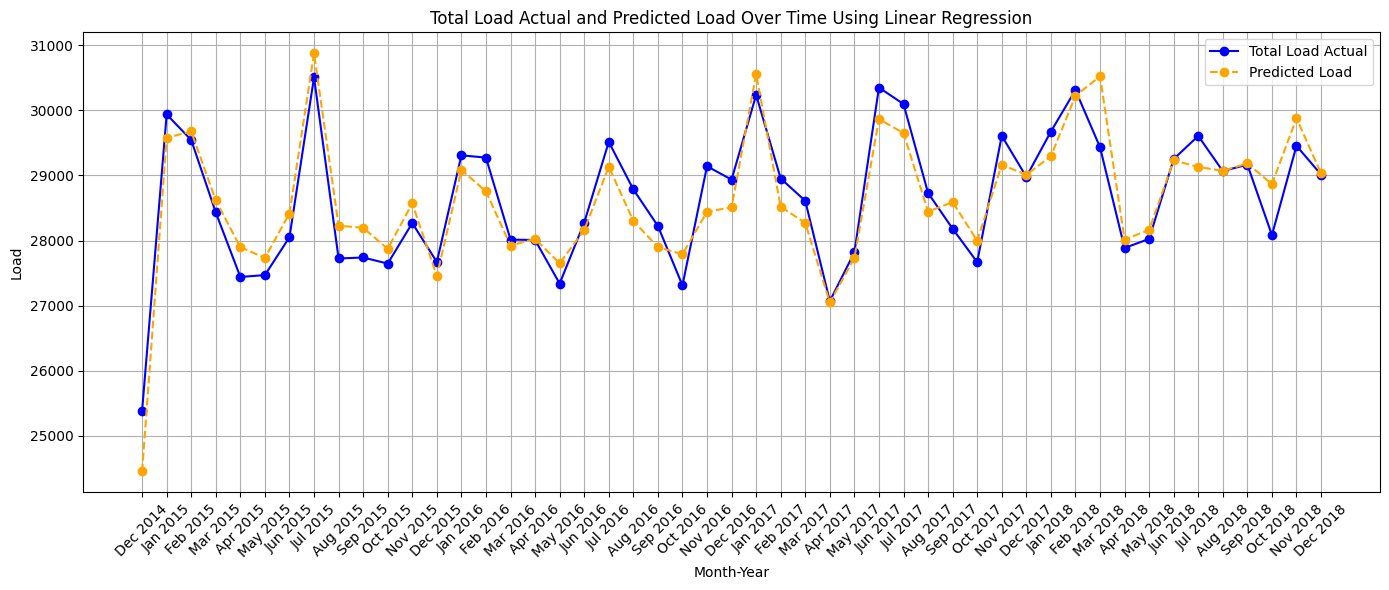

In [80]:
y_pred_train = model.predict(X_train_scaled)
y_pred_validation = model.predict(X_validation_scaled)
y_pred_test = model.predict(X_test_scaled)

# Combine train, validation, and test datasets for plotting
df_train = pd.DataFrame({'datetime': train['datetime'], 'total load actual': y_train, 'predicted_load': y_pred_train})
df_validation = pd.DataFrame({'datetime': validation['datetime'], 'total load actual': y_validation, 'predicted_load': y_pred_validation})
df_test = pd.DataFrame({'datetime': test['datetime'], 'total load actual': y_test, 'predicted_load': y_pred_test})

df_combined = pd.concat([df_train, df_validation, df_test])

# Ensure datetime column is in datetime format
df_combined['datetime'] = pd.to_datetime(df_combined['datetime'])

# Define the desired time range
start_date = '2014-12-31'
end_date = '2018-12-31'

# Filter the data to include only the specified time range
df_combined_filtered = df_combined[(df_combined['datetime'] >= start_date) & (df_combined['datetime'] <= end_date)]

# Group by year and month, and aggregate
df_combined_filtered = df_combined_filtered.groupby(df_combined_filtered['datetime'].dt.to_period('M')).agg({
    'total load actual': 'mean',
    'predicted_load': 'mean'
}).reset_index()

# Format month-year column for x-axis labels
df_combined_filtered['month_year'] = df_combined_filtered['datetime'].dt.strftime('%b %Y')

# Plotting
plt.figure(figsize=(14, 6))  # Adjusted figure size

plt.plot(df_combined_filtered['month_year'], df_combined_filtered['total load actual'], label='Total Load Actual', marker='o', color='blue')
plt.plot(df_combined_filtered['month_year'], df_combined_filtered['predicted_load'], label='Predicted Load', marker='o', linestyle='--', color='orange')

plt.xlabel('Month-Year')
plt.ylabel('Load')
plt.title('Total Load Actual and Predicted Load Over Time Using Linear Regression')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


#### Price actual prediction

In [81]:
price_features = [price_feature for price_feature in price_features if price_feature not in excl_price_features]

# Using previously split train, validation, and test sets
X_train = train[price_features]
X_validation = validation[price_features]
X_test = test[price_features]

y_train = train['price actual']
y_validation = validation['price actual']
y_test = test['price actual']

# Drop rows with missing values
X_train = X_train.dropna()
X_validation = X_validation.dropna()
X_test = X_test.dropna()

# Re-align y to match X after dropping rows with missing values
y_train = y_train.loc[X_train.index]
y_validation = y_validation.loc[X_validation.index]
y_test = y_test.loc[X_test.index]

# Remove non-numeric columns from X
X_train_numeric = X_train.select_dtypes(include=[np.number])
X_validation_numeric = X_validation.select_dtypes(include=[np.number])
X_test_numeric = X_test.select_dtypes(include=[np.number])

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_validation_scaled = scaler.transform(X_validation_numeric)
X_test_scaled = scaler.transform(X_test_numeric)

# Initialize linear regression model
model = LinearRegression()

# Train the model on training data
model.fit(X_train_scaled, y_train)

# Predicting on the validation set
y_pred_validation = model.predict(X_validation_scaled)

# Model evaluation on validation set
mse_validation = mean_squared_error(y_validation, y_pred_validation)
r2_validation = r2_score(y_validation, y_pred_validation)
mape_validation = mean_absolute_percentage_error(y_validation, y_pred_validation)
mae_validation = mean_absolute_error(y_validation, y_pred_validation)

print("\nFor Price Prediction")
# # Print validation results
print("\nValidation Results:")
print(f'Mean Squared Error (MSE): {mse_validation:.2f}')
print(f'R-squared (R2): {r2_validation:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_validation:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_validation:.2f}')
print(f'Mean Absolute Error (MAE): {mae_validation:.2f}')

# Predicting on the test set
y_pred_test = model.predict(X_test_scaled)

# Model evaluation on test set
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

# Calculate adjusted R-squared for test set
n_test = X_test_scaled.shape[0]  # number of observations
k_test = X_test_scaled.shape[1]  # number of predictors
adjusted_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - k_test - 1)

# Print test results
print("\nTest Results:")
print(f'Mean Squared Error (MSE): {mse_test:.2f}')
print(f'R-squared (R2): {r2_test:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_test:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_test:.2f}')
print(f'Mean Absolute Error (MAE): {mae_test:.2f}')



For Price Prediction

Validation Results:
Mean Squared Error (MSE): 92.56
R-squared (R2): 0.53
Adjusted R-squared: 0.92
Mean Absolute Percentage Error (MAPE): 0.15
Mean Absolute Error (MAE): 7.49

Test Results:
Mean Squared Error (MSE): 96.93
R-squared (R2): 0.50
Adjusted R-squared: 0.49
Mean Absolute Percentage Error (MAPE): 0.15
Mean Absolute Error (MAE): 7.65


<ipython-input-82-e3790bbe8bb1>:23: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_combined_filtered = df_combined_filtered.groupby(df_combined_filtered['datetime'].dt.to_period('M')).agg({


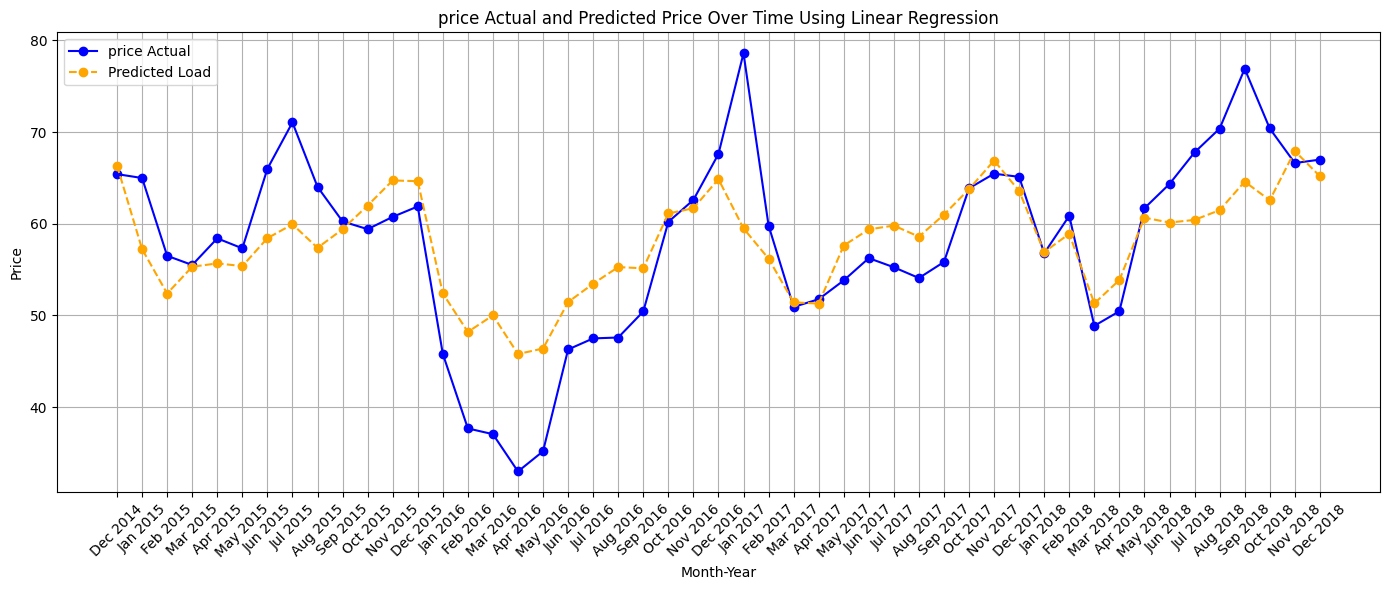

In [82]:
y_pred_train = model.predict(X_train_scaled)
y_pred_validation = model.predict(X_validation_scaled)
y_pred_test = model.predict(X_test_scaled)

# Combine train, validation, and test datasets for plotting
df_train = pd.DataFrame({'datetime': train['datetime'], 'price actual': y_train, 'predicted_price': y_pred_train})
df_validation = pd.DataFrame({'datetime': validation['datetime'], 'price actual': y_validation, 'predicted_price': y_pred_validation})
df_test = pd.DataFrame({'datetime': test['datetime'], 'price actual': y_test, 'predicted_price': y_pred_test})

df_combined = pd.concat([df_train, df_validation, df_test])

# Ensure datetime column is in datetime format
df_combined['datetime'] = pd.to_datetime(df_combined['datetime'])

# Define the desired time range
start_date = '2014-12-31'
end_date = '2018-12-31'

# Filter the data to include only the specified time range
df_combined_filtered = df_combined[(df_combined['datetime'] >= start_date) & (df_combined['datetime'] <= end_date)]

# Group by year and month, and aggregate
df_combined_filtered = df_combined_filtered.groupby(df_combined_filtered['datetime'].dt.to_period('M')).agg({
    'price actual': 'mean',
    'predicted_price': 'mean'
}).reset_index()

# Format month-year column for x-axis labels
df_combined_filtered['month_year'] = df_combined_filtered['datetime'].dt.strftime('%b %Y')

# Plotting
plt.figure(figsize=(14, 6))  # Adjusted figure size

plt.plot(df_combined_filtered['month_year'], df_combined_filtered['price actual'], label='price Actual', marker='o', color='blue')
plt.plot(df_combined_filtered['month_year'], df_combined_filtered['predicted_price'], label='Predicted Load', marker='o', linestyle='--', color='orange')

plt.xlabel('Month-Year')
plt.ylabel('Price')
plt.title('price Actual and Predicted Price Over Time Using Linear Regression')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


### Random Forest Model

#### For Load Prediction

Without Hyperparameter tunning

In [83]:
load_features = [load_feature for load_feature in load_features if load_feature not in excl_load_features]

# Using previously split train, validation, and test sets
X_train = train[load_features]
X_validation = validation[load_features]
X_test = test[load_features]

y_train = train['total load actual']
y_validation = validation['total load actual']
y_test = test['total load actual']

# Drop rows with missing values
X_train = X_train.dropna()
X_validation = X_validation.dropna()
X_test = X_test.dropna()

# Re-align y to match X after dropping rows with missing values
y_train = y_train.loc[X_train.index]
y_validation = y_validation.loc[X_validation.index]
y_test = y_test.loc[X_test.index]

# Remove non-numeric columns from X
X_train_numeric = X_train.select_dtypes(include=[np.number])
X_validation_numeric = X_validation.select_dtypes(include=[np.number])
X_test_numeric = X_test.select_dtypes(include=[np.number])

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_validation_scaled = scaler.transform(X_validation_numeric)
X_test_scaled = scaler.transform(X_test_numeric)

# Initialize Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on training data
rf_model.fit(X_train_scaled, y_train)

# Predicting on the validation set
y_pred_validation = rf_model.predict(X_validation_scaled)

# Model evaluation on validation set
mse_validation = mean_squared_error(y_validation, y_pred_validation)
r2_validation = r2_score(y_validation, y_pred_validation)
mape_validation = mean_absolute_percentage_error(y_validation, y_pred_validation)
mae_validation = mean_absolute_error(y_validation, y_pred_validation)

# Calculate adjusted R-squared for validation set
n_val = X_validation_scaled.shape[0]  # number of observations
k_val = X_validation_scaled.shape[1]  # number of predictors
adjusted_r2_validation = 1 - (1 - r2_validation) * (n_val - 1) / (n_val - k_val - 1)

# Print validation results
print("\nValidation Results For Total Load Actual(Without Hyperparameter tunning):")
print(f'Mean Squared Error (MSE): {mse_validation:.2f}')
print(f'R-squared (R2): {r2_validation:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_validation:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_validation:.2f}%')
print(f'Mean Absolute Error (MAE): {mae_validation:.2f}')

# Predicting on the test set
y_pred_test = rf_model.predict(X_test_scaled)

# Model evaluation on test set
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

# Calculate adjusted R-squared for test set
n_test = X_test_scaled.shape[0]  # number of observations
k_test = X_test_scaled.shape[1]  # number of predictors
adjusted_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - k_test - 1)

# Print test results
print("\nTest Results for Total Load actual")
print(f'Mean Squared Error (MSE): {mse_test:.2f}')
print(f'R-squared (R2): {r2_test:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_test:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_test:.2f}%')
print(f'Mean Absolute Error (MAE): {mae_test:.2f}')



Validation Results For Total Load Actual(Without Hyperparameter tunning):
Mean Squared Error (MSE): 1357365.60
R-squared (R2): 0.94
Adjusted R-squared: 0.94
Mean Absolute Percentage Error (MAPE): 0.03%
Mean Absolute Error (MAE): 884.09

Test Results for Total Load actual
Mean Squared Error (MSE): 1369580.05
R-squared (R2): 0.93
Adjusted R-squared: 0.93
Mean Absolute Percentage Error (MAPE): 0.03%
Mean Absolute Error (MAE): 884.83


<ipython-input-84-ef0ea02b2a51>:28: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_combined_filtered = df_combined_filtered.groupby(df_combined_filtered['datetime'].dt.to_period('M')).agg({


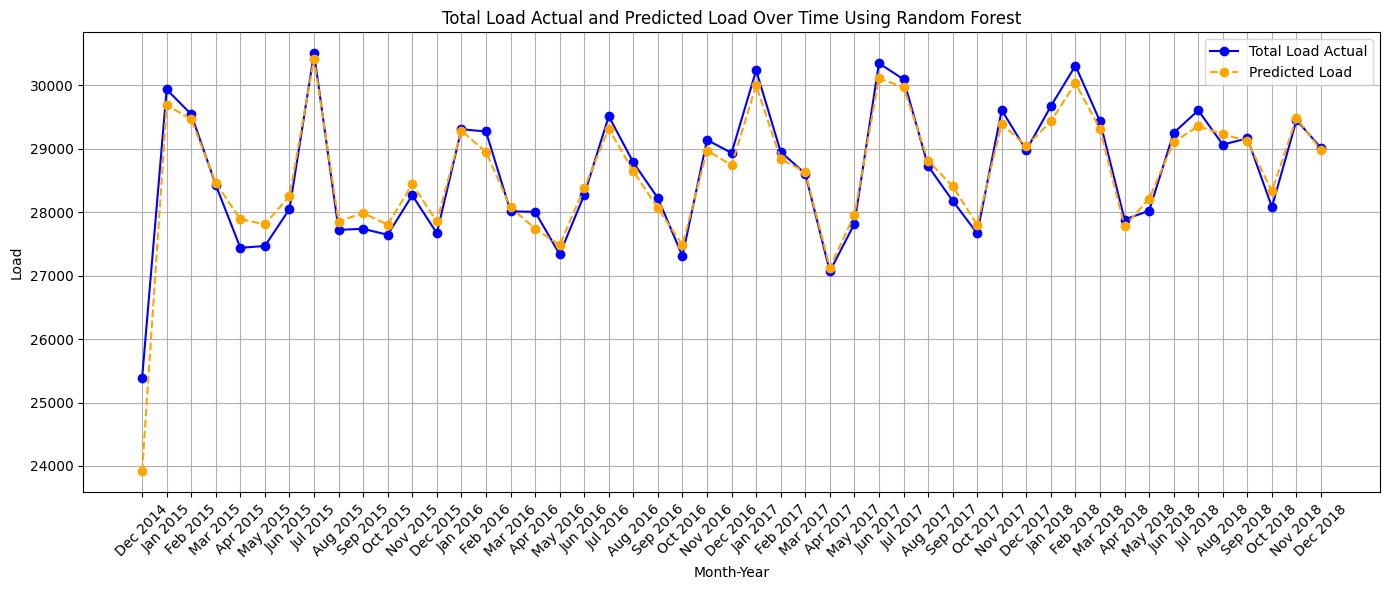

In [84]:
# Initialize and fit the RandomForestRegressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predicting on the train, validation, and test sets
y_pred_train = rf_model.predict(X_train_scaled)
y_pred_validation = rf_model.predict(X_validation_scaled)
y_pred_test = rf_model.predict(X_test_scaled)

# Combine train, validation, and test datasets for plotting
df_train = pd.DataFrame({'datetime': train['datetime'], 'total load actual': y_train, 'predicted_load': y_pred_train})
df_validation = pd.DataFrame({'datetime': validation['datetime'], 'total load actual': y_validation, 'predicted_load': y_pred_validation})
df_test = pd.DataFrame({'datetime': test['datetime'], 'total load actual': y_test, 'predicted_load': y_pred_test})

df_combined = pd.concat([df_train, df_validation, df_test])

# Ensure datetime column is in datetime format
df_combined['datetime'] = pd.to_datetime(df_combined['datetime'])

# Define the desired time range
start_date = '2014-12-31'
end_date = '2018-12-31'

# Filter the data to include only the specified time range
df_combined_filtered = df_combined[(df_combined['datetime'] >= start_date) & (df_combined['datetime'] <= end_date)]

# Group by year and month, and aggregate
df_combined_filtered = df_combined_filtered.groupby(df_combined_filtered['datetime'].dt.to_period('M')).agg({
    'total load actual': 'mean',
    'predicted_load': 'mean'
}).reset_index()

# Format month-year column for x-axis labels
df_combined_filtered['month_year'] = df_combined_filtered['datetime'].dt.strftime('%b %Y')

# Plotting
plt.figure(figsize=(14, 6))  # Adjusted figure size

plt.plot(df_combined_filtered['month_year'], df_combined_filtered['total load actual'], label='Total Load Actual', marker='o', color='blue')
plt.plot(df_combined_filtered['month_year'], df_combined_filtered['predicted_load'], label='Predicted Load', marker='o', linestyle='--', color='orange')

plt.xlabel('Month-Year')
plt.ylabel('Load')
plt.title('Total Load Actual and Predicted Load Over Time Using Random Forest')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Energy Demand Prediction With Hyperparameter tunning using Random Forest Model implementing GridSearchCV

In [85]:
# Function to create sequences of data
def create_sequences(data, target, sequence_length=10):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(target[i+sequence_length])
    return np.array(X), np.array(y)

# Adjusted feature selection
load_features = [load_feature for load_feature in load_features if load_feature not in excl_load_features]

# Using previously split train, validation, and test sets
X_train = train[load_features]
X_validation = validation[load_features]
X_test = test[load_features]

y_train = train['total load actual']
y_validation = validation['total load actual']
y_test = test['total load actual']

# Drop rows with missing values
X_train = X_train.dropna()
X_validation = X_validation.dropna()
X_test = X_test.dropna()

# Re-align y to match X after dropping rows with missing values
y_train = y_train.loc[X_train.index]
y_validation = y_validation.loc[X_validation.index]
y_test = y_test.loc[X_test.index]

# Remove non-numeric columns from X
X_train_numeric = X_train.select_dtypes(include=[np.number])
X_validation_numeric = X_validation.select_dtypes(include=[np.number])
X_test_numeric = X_test.select_dtypes(include=[np.number])

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_validation_scaled = scaler.transform(X_validation_numeric)
X_test_scaled = scaler.transform(X_test_numeric)

# Ensure y_train, y_validation, y_test have matching lengths with X_train_scaled, X_validation_scaled, X_test_scaled
if len(y_train) != len(X_train_scaled):
    raise ValueError(f"Length mismatch: y_train ({len(y_train)}) vs X_train_scaled ({len(X_train_scaled)})")
if len(y_validation) != len(X_validation_scaled):
    raise ValueError(f"Length mismatch: y_validation ({len(y_validation)}) vs X_validation_scaled ({len(X_validation_scaled)})")
if len(y_test) != len(X_test_scaled):
    raise ValueError(f"Length mismatch: y_test ({len(y_test)}) vs X_test_scaled ({len(X_test_scaled)})")

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100,150],
    'max_features': [ 'log2'],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Initialize Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Train the model on training data with hyperparameter tuning
grid_search.fit(X_train_scaled, y_train)

# Get the best model from GridSearchCV
best_rf_model = grid_search.best_estimator_

# Predicting on the validation set
y_pred_validation = best_rf_model.predict(X_validation_scaled)

# Model evaluation on validation set
mse_validation = mean_squared_error(y_validation, y_pred_validation)
r2_validation = r2_score(y_validation, y_pred_validation)
mape_validation = mean_absolute_percentage_error(y_validation, y_pred_validation)
mae_validation = mean_absolute_error(y_validation, y_pred_validation)

# Calculate adjusted R-squared for validation set
n_val = X_validation_scaled.shape[0]  # number of observations
k_val = X_validation_scaled.shape[1]  # number of predictors
adjusted_r2_validation = 1 - (1 - r2_validation) * (n_val - 1) / (n_val - k_val - 1)

# Print validation results
print("\nValidation Results For Total Load Actual:")
print(f'Mean Squared Error (MSE): {mse_validation:.2f}')
print(f'R-squared (R2): {r2_validation:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_validation:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_validation:.2f}')
print(f'Mean Absolute Error (MAE): {mae_validation:.2f}')

# Predicting on the test set
y_pred_test = best_rf_model.predict(X_test_scaled)

# Model evaluation on test set
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

# Calculate adjusted R-squared for test set
n_test = X_test_scaled.shape[0]  # number of observations
k_test = X_test_scaled.shape[1]  # number of predictors
adjusted_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - k_test - 1)

# Print test results
print("\nTest Results for Total Load Actual:")
print(f'Mean Squared Error (MSE): {mse_test:.2f}')
print(f'R-squared (R2): {r2_test:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_test:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_test:.2f}')
print(f'Mean Absolute Error (MAE): {mae_test:.2f}')

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()



Validation Results For Total Load Actual:
Mean Squared Error (MSE): 1141377.93
R-squared (R2): 0.95
Adjusted R-squared: 0.95
Mean Absolute Percentage Error (MAPE): 0.03
Mean Absolute Error (MAE): 816.16

Test Results for Total Load Actual:
Mean Squared Error (MSE): 1160731.21
R-squared (R2): 0.94
Adjusted R-squared: 0.94
Mean Absolute Percentage Error (MAPE): 0.03
Mean Absolute Error (MAE): 822.75


<ipython-input-86-1c83006e0080>:28: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_combined_filtered = df_combined_filtered.groupby(df_combined_filtered['datetime'].dt.to_period('M')).agg({


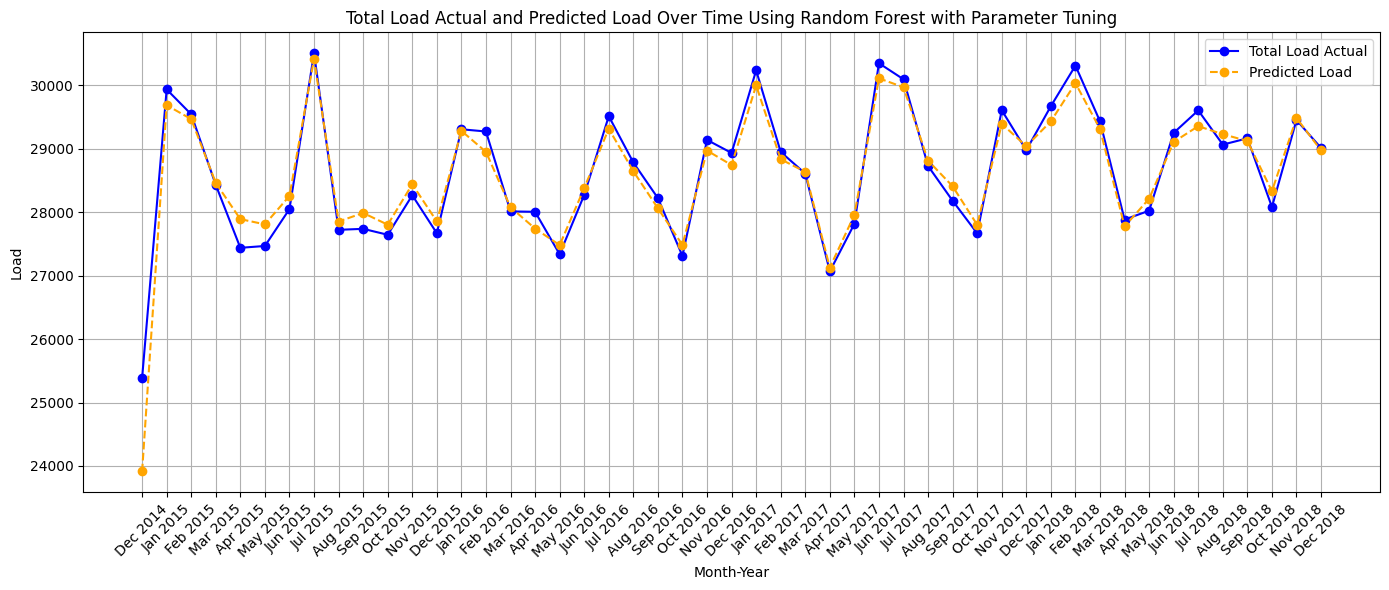

In [86]:
# Initialize and fit the RandomForestRegressor model
best_rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
best_rf_model.fit(X_train_scaled, y_train)

# Predicting on the train, validation, and test sets
y_pred_train = best_rf_model.predict(X_train_scaled)
y_pred_validation = best_rf_model.predict(X_validation_scaled)
y_pred_test = best_rf_model.predict(X_test_scaled)

# Combine train, validation, and test datasets for plotting
df_train = pd.DataFrame({'datetime': train['datetime'], 'total load actual': y_train, 'predicted_load': y_pred_train})
df_validation = pd.DataFrame({'datetime': validation['datetime'], 'total load actual': y_validation, 'predicted_load': y_pred_validation})
df_test = pd.DataFrame({'datetime': test['datetime'], 'total load actual': y_test, 'predicted_load': y_pred_test})

df_combined = pd.concat([df_train, df_validation, df_test])

# Ensure datetime column is in datetime format
df_combined['datetime'] = pd.to_datetime(df_combined['datetime'])

# Define the desired time range
start_date = '2014-12-31'
end_date = '2018-12-31'

# Filter the data to include only the specified time range
df_combined_filtered = df_combined[(df_combined['datetime'] >= start_date) & (df_combined['datetime'] <= end_date)]

# Group by year and month, and aggregate
df_combined_filtered = df_combined_filtered.groupby(df_combined_filtered['datetime'].dt.to_period('M')).agg({
    'total load actual': 'mean',
    'predicted_load': 'mean'
}).reset_index()

# Format month-year column for x-axis labels
df_combined_filtered['month_year'] = df_combined_filtered['datetime'].dt.strftime('%b %Y')

# Plotting
plt.figure(figsize=(14, 6))  # Adjusted figure size

plt.plot(df_combined_filtered['month_year'], df_combined_filtered['total load actual'], label='Total Load Actual', marker='o', color='blue')
plt.plot(df_combined_filtered['month_year'], df_combined_filtered['predicted_load'], label='Predicted Load', marker='o', linestyle='--', color='orange')

plt.xlabel('Month-Year')
plt.ylabel('Load')
plt.title('Total Load Actual and Predicted Load Over Time Using Random Forest with Parameter Tuning')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

#### For Price Predicition

Without Hyperparameter tunning

In [87]:
price_features = [price_feature for price_feature in price_features if price_feature not in excl_price_features]


# Using previously split train, validation, and test sets
X_train = train[price_features]
X_validation = validation[price_features]
X_test = test[price_features]

y_train = train['price actual']
y_validation = validation['price actual']
y_test = test['price actual']

# Drop rows with missing values
X_train = X_train.dropna()
X_validation = X_validation.dropna()
X_test = X_test.dropna()

# Re-align y to match X after dropping rows with missing values
y_train = y_train.loc[X_train.index]
y_validation = y_validation.loc[X_validation.index]
y_test = y_test.loc[X_test.index]

# Remove non-numeric columns from X
X_train_numeric = X_train.select_dtypes(include=[np.number])
X_validation_numeric = X_validation.select_dtypes(include=[np.number])
X_test_numeric = X_test.select_dtypes(include=[np.number])

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_validation_scaled = scaler.transform(X_validation_numeric)
X_test_scaled = scaler.transform(X_test_numeric)

# Initialize Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on training data
rf_model.fit(X_train_scaled, y_train)

# Predicting on the validation set
y_pred_validation = rf_model.predict(X_validation_scaled)

# Model evaluation on validation set
mse_validation = mean_squared_error(y_validation, y_pred_validation)
r2_validation = r2_score(y_validation, y_pred_validation)
mape_validation = mean_absolute_percentage_error(y_validation, y_pred_validation)
mae_validation = mean_absolute_error(y_validation, y_pred_validation)

# Calculate adjusted R-squared for validation set
n_val = X_validation_scaled.shape[0]  # number of observations
k_val = X_validation_scaled.shape[1]  # number of predictors
adjusted_r2_validation = 1 - (1 - r2_validation) * (n_val - 1) / (n_val - k_val - 1)

# Print validation results
print("\nValidation Results For Price Actual:")
print(f'Mean Squared Error (MSE): {mse_validation:.2f}')
print(f'R-squared (R2): {r2_validation:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_validation:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_validation:.2f}')
print(f'Mean Absolute Error (MAE): {mae_validation:.2f}')

# Predicting on the test set
y_pred_test = rf_model.predict(X_test_scaled)

# Model evaluation on test set
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

# Calculate adjusted R-squared for test set
n_test = X_test_scaled.shape[0]  # number of observations
k_test = X_test_scaled.shape[1]  # number of predictors
adjusted_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - k_test - 1)

# Print test results
print("\nTest Results for Price Actual:")
print(f'Mean Squared Error (MSE): {mse_test:.2f}')
print(f'R-squared (R2): {r2_test:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_test:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_test:.2f}')
print(f'Mean Absolute Error (MAE): {mae_test:.2f}')


Validation Results For Price Actual:
Mean Squared Error (MSE): 27.14
R-squared (R2): 0.86
Adjusted R-squared: 0.86
Mean Absolute Percentage Error (MAPE): 0.07
Mean Absolute Error (MAE): 3.70

Test Results for Price Actual:
Mean Squared Error (MSE): 27.62
R-squared (R2): 0.86
Adjusted R-squared: 0.86
Mean Absolute Percentage Error (MAPE): 0.07
Mean Absolute Error (MAE): 3.75


<ipython-input-88-e694e480a88d>:28: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_combined_filtered = df_combined_filtered.groupby(df_combined_filtered['datetime'].dt.to_period('M')).agg({


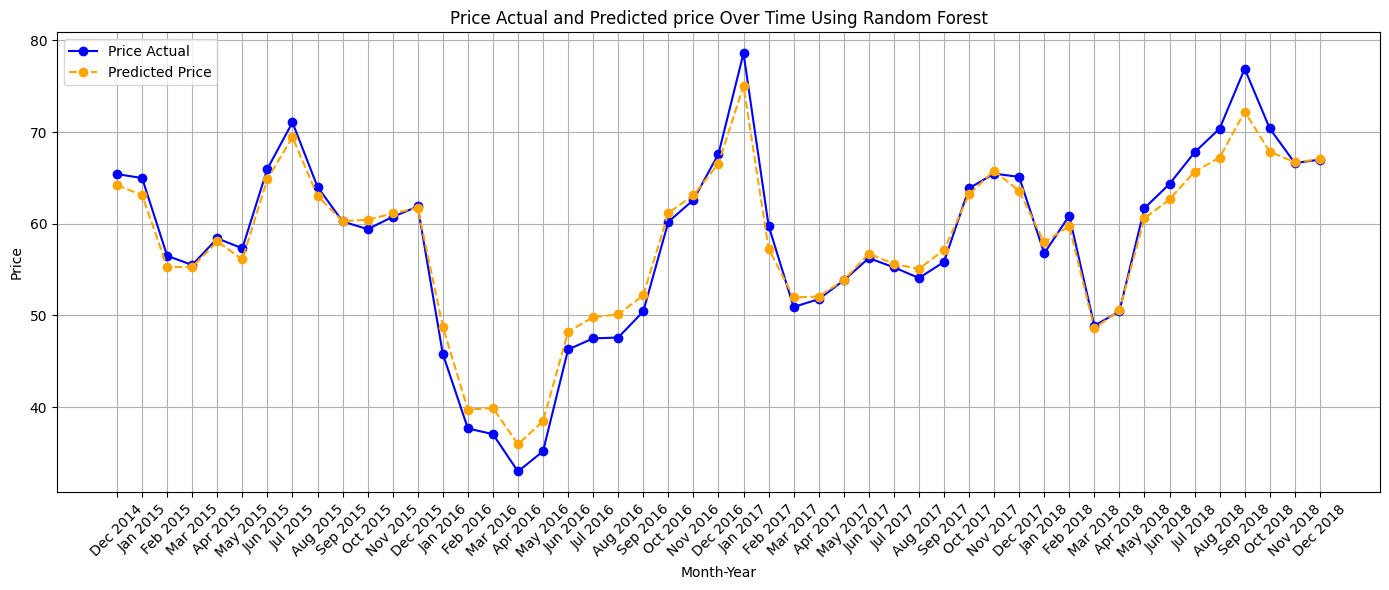

In [88]:
# Initialize and fit the RandomForestRegressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predicting on the train, validation, and test sets
y_pred_train = rf_model.predict(X_train_scaled)
y_pred_validation = rf_model.predict(X_validation_scaled)
y_pred_test = rf_model.predict(X_test_scaled)

# Combine train, validation, and test datasets for plotting
df_train = pd.DataFrame({'datetime': train['datetime'], 'price actual': y_train, 'predicted_price': y_pred_train})
df_validation = pd.DataFrame({'datetime': validation['datetime'], 'price actual': y_validation, 'predicted_price': y_pred_validation})
df_test = pd.DataFrame({'datetime': test['datetime'], 'price actual': y_test, 'predicted_price': y_pred_test})

df_combined = pd.concat([df_train, df_validation, df_test])

# Ensure datetime column is in datetime format
df_combined['datetime'] = pd.to_datetime(df_combined['datetime'])

# Define the desired time range
start_date = '2014-12-31'
end_date = '2018-12-31'

# Filter the data to include only the specified time range
df_combined_filtered = df_combined[(df_combined['datetime'] >= start_date) & (df_combined['datetime'] <= end_date)]

# Group by year and month, and aggregate
df_combined_filtered = df_combined_filtered.groupby(df_combined_filtered['datetime'].dt.to_period('M')).agg({
    'price actual': 'mean',
    'predicted_price': 'mean'
}).reset_index()

# Format month-year column for x-axis labels
df_combined_filtered['month_year'] = df_combined_filtered['datetime'].dt.strftime('%b %Y')

# Plotting
plt.figure(figsize=(14, 6))  # Adjusted figure size

plt.plot(df_combined_filtered['month_year'], df_combined_filtered['price actual'], label='Price Actual', marker='o', color='blue')
plt.plot(df_combined_filtered['month_year'], df_combined_filtered['predicted_price'], label='Predicted Price', marker='o', linestyle='--', color='orange')

plt.xlabel('Month-Year')
plt.ylabel('Price')
plt.title('Price Actual and Predicted price Over Time Using Random Forest')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Price Prediction With Hyperparameter tunning using Random Forest Model implementing GridSearchCV

In [89]:
# Adjust feature selection
price_features = [price_feature for price_feature in price_features if price_feature not in excl_price_features]

# Using previously split train, validation, and test sets
X_train = train[price_features]
X_validation = validation[price_features]
X_test = test[price_features]

y_train = train['price actual']
y_validation = validation['price actual']
y_test = test['price actual']

# Drop rows with missing values
X_train = X_train.dropna()
X_validation = X_validation.dropna()
X_test = X_test.dropna()

# Re-align y to match X after dropping rows with missing values
y_train = y_train.loc[X_train.index]
y_validation = y_validation.loc[X_validation.index]
y_test = y_test.loc[X_test.index]

# Remove non-numeric columns from X
X_train_numeric = X_train.select_dtypes(include=[np.number])
X_validation_numeric = X_validation.select_dtypes(include=[np.number])
X_test_numeric = X_test.select_dtypes(include=[np.number])

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_validation_scaled = scaler.transform(X_validation_numeric)
X_test_scaled = scaler.transform(X_test_numeric)

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100,150],
    'max_features': [ 'log2'],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Initialize Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Train the model on training data with hyperparameter tuning
grid_search.fit(X_train_scaled, y_train)

# Get the best model from GridSearchCV
best_rf_model = grid_search.best_estimator_

# Predicting on the validation set
y_pred_validation = best_rf_model.predict(X_validation_scaled)

# Model evaluation on validation set
mse_validation = mean_squared_error(y_validation, y_pred_validation)
r2_validation = r2_score(y_validation, y_pred_validation)
mape_validation = mean_absolute_percentage_error(y_validation, y_pred_validation)
mae_validation = mean_absolute_error(y_validation, y_pred_validation)

# Calculate adjusted R-squared for validation set
n_val = X_validation_scaled.shape[0]  # number of observations
k_val = X_validation_scaled.shape[1]  # number of predictors
adjusted_r2_validation = 1 - (1 - r2_validation) * (n_val - 1) / (n_val - k_val - 1)

# Print validation results
print("\nValidation Results For Price Actual:")
print(f'Mean Squared Error (MSE): {mse_validation:.2f}')
print(f'R-squared (R2): {r2_validation:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_validation:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_validation:.2f}')
print(f'Mean Absolute Error (MAE): {mae_validation:.2f}')

# Predicting on the test set
y_pred_test = best_rf_model.predict(X_test_scaled)

# Model evaluation on test set
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

# Calculate adjusted R-squared for test set
n_test = X_test_scaled.shape[0]  # number of observations
k_test = X_test_scaled.shape[1]  # number of predictors
adjusted_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - k_test - 1)

# Print test results
print("\nTest Results for Price Actual:")
print(f'Mean Squared Error (MSE): {mse_test:.2f}')
print(f'R-squared (R2): {r2_test:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_test:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_test:.2f}')
print(f'Mean Absolute Error (MAE): {mae_test:.2f}')


Validation Results For Price Actual:
Mean Squared Error (MSE): 27.14
R-squared (R2): 0.86
Adjusted R-squared: 0.86
Mean Absolute Percentage Error (MAPE): 0.07
Mean Absolute Error (MAE): 3.74

Test Results for Price Actual:
Mean Squared Error (MSE): 27.03
R-squared (R2): 0.86
Adjusted R-squared: 0.86
Mean Absolute Percentage Error (MAPE): 0.07
Mean Absolute Error (MAE): 3.76


<ipython-input-90-306c92a144ec>:28: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_combined_filtered = df_combined_filtered.groupby(df_combined_filtered['datetime'].dt.to_period('M')).agg({


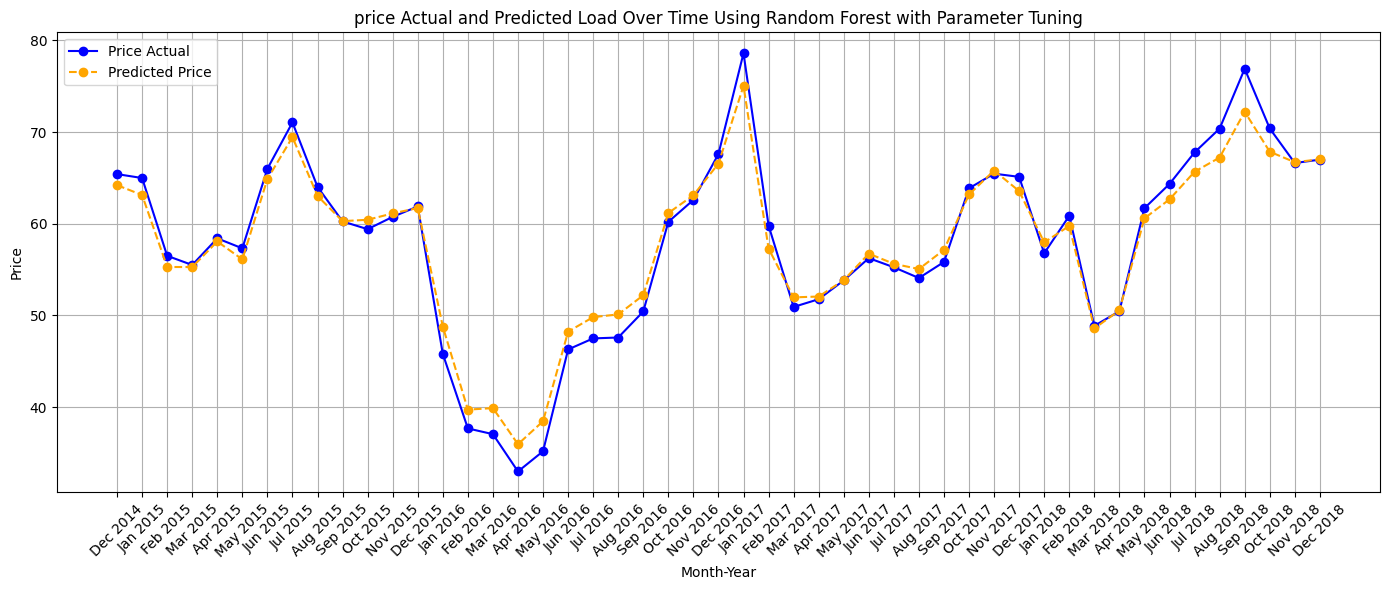

In [90]:
# Initialize and fit the RandomForestRegressor model
best_rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
best_rf_model.fit(X_train_scaled, y_train)

# Predicting on the train, validation, and test sets
y_pred_train = best_rf_model.predict(X_train_scaled)
y_pred_validation = best_rf_model.predict(X_validation_scaled)
y_pred_test = best_rf_model.predict(X_test_scaled)

# Combine train, validation, and test datasets for plotting
df_train = pd.DataFrame({'datetime': train['datetime'], 'price actual': y_train, 'predicted_price': y_pred_train})
df_validation = pd.DataFrame({'datetime': validation['datetime'], 'price actual': y_validation, 'predicted_price': y_pred_validation})
df_test = pd.DataFrame({'datetime': test['datetime'], 'price actual': y_test, 'predicted_price': y_pred_test})

df_combined = pd.concat([df_train, df_validation, df_test])

# Ensure datetime column is in datetime format
df_combined['datetime'] = pd.to_datetime(df_combined['datetime'])

# Define the desired time range
start_date = '2014-12-31'
end_date = '2018-12-31'

# Filter the data to include only the specified time range
df_combined_filtered = df_combined[(df_combined['datetime'] >= start_date) & (df_combined['datetime'] <= end_date)]

# Group by year and month, and aggregate
df_combined_filtered = df_combined_filtered.groupby(df_combined_filtered['datetime'].dt.to_period('M')).agg({
    'price actual': 'mean',
    'predicted_price': 'mean'
}).reset_index()

# Format month-year column for x-axis labels
df_combined_filtered['month_year'] = df_combined_filtered['datetime'].dt.strftime('%b %Y')

# Plotting
plt.figure(figsize=(14, 6))  # Adjusted figure size

plt.plot(df_combined_filtered['month_year'], df_combined_filtered['price actual'], label='Price Actual', marker='o', color='blue')
plt.plot(df_combined_filtered['month_year'], df_combined_filtered['predicted_price'], label='Predicted Price', marker='o', linestyle='--', color='orange')

plt.xlabel('Month-Year')
plt.ylabel('Price')
plt.title('price Actual and Predicted Load Over Time Using Random Forest with Parameter Tuning')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### Gradient Boosting Model

#### For Load Consumption Prediction

Without Hyperparameter tunning

In [91]:
load_features = [load_feature for load_feature in load_features if load_feature not in excl_load_features]

# Using previously split train, validation, and test sets
X_train = train[load_features]
X_validation = validation[load_features]
X_test = test[load_features]

y_train = train['total load actual']
y_validation = validation['total load actual']
y_test = test['total load actual']

# Drop rows with missing values
X_train = X_train.dropna()
X_validation = X_validation.dropna()
X_test = X_test.dropna()

# Re-align y to match X after dropping rows with missing values
y_train = y_train.loc[X_train.index]
y_validation = y_validation.loc[X_validation.index]
y_test = y_test.loc[X_test.index]

# Remove non-numeric columns from X
X_train_numeric = X_train.select_dtypes(include=[np.number])
X_validation_numeric = X_validation.select_dtypes(include=[np.number])
X_test_numeric = X_test.select_dtypes(include=[np.number])

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_validation_scaled = scaler.transform(X_validation_numeric)
X_test_scaled = scaler.transform(X_test_numeric)

# Initialize Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Train the model on training data
gb_model.fit(X_train_scaled, y_train)

# Predicting on the validation set
y_pred_validation = gb_model.predict(X_validation_scaled)

# Model evaluation on validation set
mse_validation = mean_squared_error(y_validation, y_pred_validation)
r2_validation = r2_score(y_validation, y_pred_validation)
mape_validation = mean_absolute_percentage_error(y_validation, y_pred_validation)
mae_validation = mean_absolute_error(y_validation, y_pred_validation)

# Calculate adjusted R-squared for validation set
n_val = X_validation_scaled.shape[0]  # number of observations
k_val = X_validation_scaled.shape[1]  # number of predictors
adjusted_r2_validation = 1 - (1 - r2_validation) * (n_val - 1) / (n_val - k_val - 1)

# Print validation results
print("\nFor Load Prediction")
print("\nValidation Results:")
print(f'Mean Squared Error (MSE): {mse_validation:.2f}')
print(f'R-squared (R2): {r2_validation:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_validation:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_validation:.2f}')
print(f'Mean Absolute Error (MAE): {mae_validation:.2f}')

# Predicting on the test set
y_pred_test = gb_model.predict(X_test_scaled)

# Model evaluation on test set
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

# Calculate adjusted R-squared for test set
n_test = X_test_scaled.shape[0]  # number of observations
k_test = X_test_scaled.shape[1]  # number of predictors
adjusted_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - k_test - 1)

# Print test results
print("\nTest Results for Total Load Actual:")
print(f'Mean Squared Error (MSE): {mse_test:.2f}')
print(f'R-squared (R2): {r2_test:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_test:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_test:.2f}')
print(f'Mean Absolute Error (MAE): {mae_test:.2f}')


For Load Prediction

Validation Results:
Mean Squared Error (MSE): 1503683.74
R-squared (R2): 0.93
Adjusted R-squared: 0.93
Mean Absolute Percentage Error (MAPE): 0.03
Mean Absolute Error (MAE): 958.29

Test Results for Total Load Actual:
Mean Squared Error (MSE): 1514348.70
R-squared (R2): 0.93
Adjusted R-squared: 0.93
Mean Absolute Percentage Error (MAPE): 0.03
Mean Absolute Error (MAE): 961.76


<ipython-input-92-f1519c6d78f5>:28: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_combined_filtered = df_combined_filtered.groupby(df_combined_filtered['datetime'].dt.to_period('M')).agg({


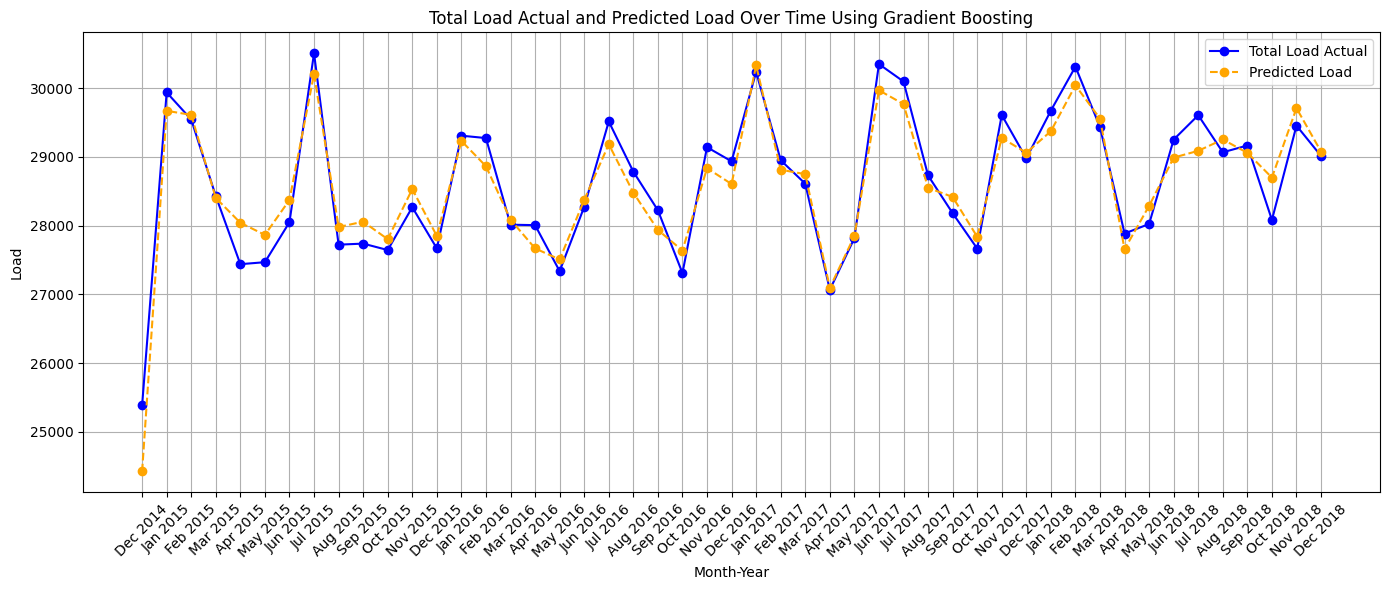

In [92]:
# Initialize and fit the GradientBoostingRegressor model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)

# Predicting on the train, validation, and test sets
y_pred_train = gb_model.predict(X_train_scaled)
y_pred_validation = gb_model.predict(X_validation_scaled)
y_pred_test = gb_model.predict(X_test_scaled)

# Combine train, validation, and test datasets for plotting
df_train = pd.DataFrame({'datetime': train['datetime'], 'total load actual': y_train, 'predicted_load': y_pred_train})
df_validation = pd.DataFrame({'datetime': validation['datetime'], 'total load actual': y_validation, 'predicted_load': y_pred_validation})
df_test = pd.DataFrame({'datetime': test['datetime'], 'total load actual': y_test, 'predicted_load': y_pred_test})

df_combined = pd.concat([df_train, df_validation, df_test])

# Ensure datetime column is in datetime format
df_combined['datetime'] = pd.to_datetime(df_combined['datetime'])

# Define the desired time range
start_date = '2014-12-31'
end_date = '2018-12-31'

# Filter the data to include only the specified time range
df_combined_filtered = df_combined[(df_combined['datetime'] >= start_date) & (df_combined['datetime'] <= end_date)]

# Group by year and month, and aggregate
df_combined_filtered = df_combined_filtered.groupby(df_combined_filtered['datetime'].dt.to_period('M')).agg({
    'total load actual': 'mean',
    'predicted_load': 'mean'
}).reset_index()

# Format month-year column for x-axis labels
df_combined_filtered['month_year'] = df_combined_filtered['datetime'].dt.strftime('%b %Y')

# Plotting
plt.figure(figsize=(14, 6))  # Adjusted figure size

plt.plot(df_combined_filtered['month_year'], df_combined_filtered['total load actual'], label='Total Load Actual', marker='o', color='blue')
plt.plot(df_combined_filtered['month_year'], df_combined_filtered['predicted_load'], label='Predicted Load', marker='o', linestyle='--', color='orange')

plt.xlabel('Month-Year')
plt.ylabel('Load')
plt.title('Total Load Actual and Predicted Load Over Time Using Gradient Boosting')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Load Prediction With Hyperparameter tunning using Gradient Boosting Model implementing GridSearchCV

In [93]:
load_features = [load_feature for load_feature in load_features if load_feature not in excl_load_features]

# Using previously split train, validation, and test sets
X_train = train[load_features]
X_validation = validation[load_features]
X_test = test[load_features]

y_train = train['total load actual']
y_validation = validation['total load actual']
y_test = test['total load actual']

# Drop rows with missing values
X_train = X_train.dropna()
X_validation = X_validation.dropna()
X_test = X_test.dropna()

# Re-align y to match X after dropping rows with missing values
y_train = y_train.loc[X_train.index]
y_validation = y_validation.loc[X_validation.index]
y_test = y_test.loc[X_test.index]

# Remove non-numeric columns from X
X_train_numeric = X_train.select_dtypes(include=[np.number])
X_validation_numeric = X_validation.select_dtypes(include=[np.number])
X_test_numeric = X_test.select_dtypes(include=[np.number])

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_validation_scaled = scaler.transform(X_validation_numeric)
X_test_scaled = scaler.transform(X_test_numeric)
# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of boosting stages
    'learning_rate': [0.01, 0.1],  # Step size shrinkage to prevent overfitting
    'max_depth': [3, 5],  # Maximum depth of each tree
    'min_samples_split': [2, 5],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2],  # Minimum samples required to be at a leaf node
    'max_features': [ 'sqrt']  # Number of features to consider at every split
}

# Initialize Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)

# Initialize Grid Search with cross-validation
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit Grid Search on training data
grid_search.fit(X_train_scaled, y_train)

# Best parameters and best score found during Grid Search
print("Best parameters found:", grid_search.best_params_)
print("Lowest MSE found:", grid_search.best_score_)

# Predict using the best model from Grid Search on validation set
y_pred_validation = grid_search.best_estimator_.predict(X_validation_scaled)

# Model evaluation on validation set with best model
mse_validation = mean_squared_error(y_validation, y_pred_validation)
r2_validation = r2_score(y_validation, y_pred_validation)
mape_validation = mean_absolute_percentage_error(y_validation, y_pred_validation)
mae_validation = mean_absolute_error(y_validation, y_pred_validation)

# Calculate adjusted R-squared for validation set
n_val = X_validation_scaled.shape[0]
k_val = X_validation_scaled.shape[1]
adjusted_r2_validation = 1 - (1 - r2_validation) * (n_val - 1) / (n_val - k_val - 1)

# Print validation results with best model
print("\nFor Load Prediction:")
print("\nValidation Results with Best Model:")
print(f'Mean Squared Error (MSE): {mse_validation:.2f}')
print(f'R-squared (R2): {r2_validation:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_validation:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_validation:.2f}')
print(f'Mean Absolute Error (MAE): {mae_validation:.2f}')

# Predicting on the test set using the best model found
y_pred_test = grid_search.best_estimator_.predict(X_test_scaled)

# Model evaluation on test set with best model
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

# Calculate adjusted R-squared for test set
n_test = X_test_scaled.shape[0]
k_test = X_test_scaled.shape[1]
adjusted_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - k_test - 1)

# Print test results with best model
print("\nTest Results with Best Model:")
print(f'Mean Squared Error (MSE): {mse_test:.2f}')
print(f'R-squared (R2): {r2_test:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_test:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_test:.2f}')
print(f'Mean Absolute Error (MAE): {mae_test:.2f}')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters found: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}
Lowest MSE found: -1043910.6943627034

For Load Prediction:

Validation Results with Best Model:
Mean Squared Error (MSE): 971312.04
R-squared (R2): 0.95
Adjusted R-squared: 0.95
Mean Absolute Percentage Error (MAPE): 0.03
Mean Absolute Error (MAE): 764.65

Test Results with Best Model:
Mean Squared Error (MSE): 967143.57
R-squared (R2): 0.95
Adjusted R-squared: 0.95
Mean Absolute Percentage Error (MAPE): 0.03
Mean Absolute Error (MAE): 766.58


<ipython-input-94-9b94f8fb2b84>:28: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_combined_filtered = df_combined_filtered.groupby(df_combined_filtered['datetime'].dt.to_period('M')).agg({


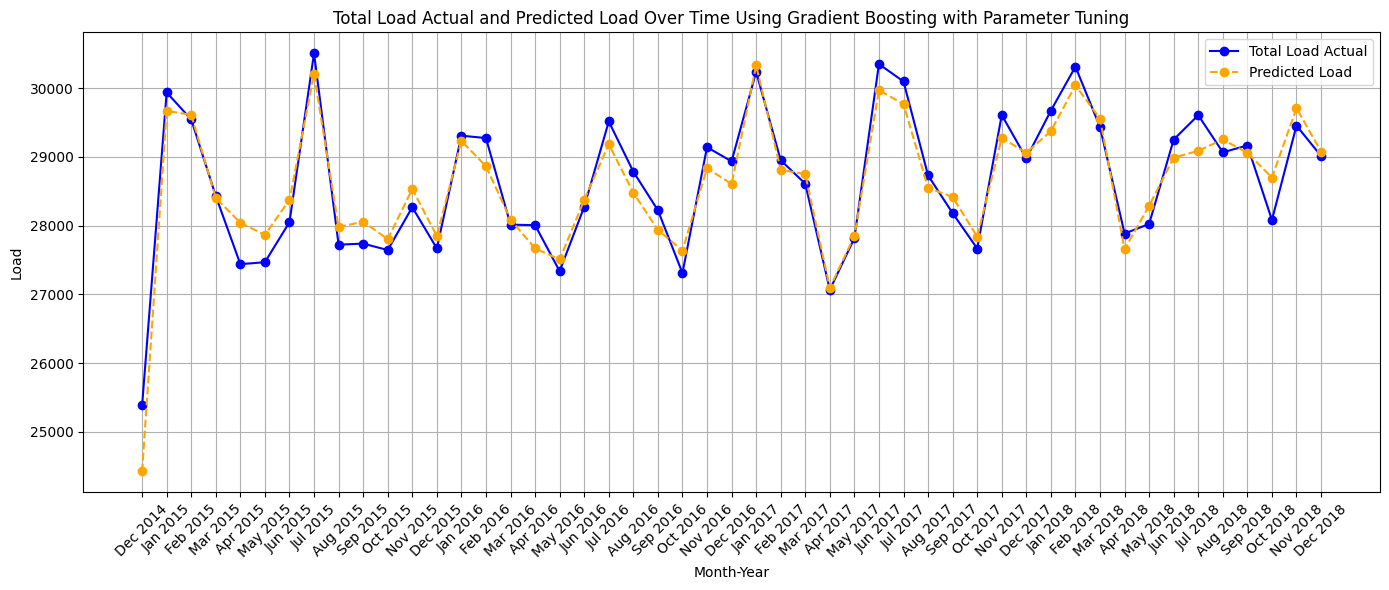

In [94]:
# Initialize and fit the GradientBoostingRegressor model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)

# Predicting on the train, validation, and test sets
y_pred_train = gb_model.predict(X_train_scaled)
y_pred_validation = gb_model.predict(X_validation_scaled)
y_pred_test = gb_model.predict(X_test_scaled)

# Combine train, validation, and test datasets for plotting
df_train = pd.DataFrame({'datetime': train['datetime'], 'total load actual': y_train, 'predicted_load': y_pred_train})
df_validation = pd.DataFrame({'datetime': validation['datetime'], 'total load actual': y_validation, 'predicted_load': y_pred_validation})
df_test = pd.DataFrame({'datetime': test['datetime'], 'total load actual': y_test, 'predicted_load': y_pred_test})

df_combined = pd.concat([df_train, df_validation, df_test])

# Ensure datetime column is in datetime format
df_combined['datetime'] = pd.to_datetime(df_combined['datetime'])

# Define the desired time range
start_date = '2014-12-31'
end_date = '2018-12-31'

# Filter the data to include only the specified time range
df_combined_filtered = df_combined[(df_combined['datetime'] >= start_date) & (df_combined['datetime'] <= end_date)]

# Group by year and month, and aggregate
df_combined_filtered = df_combined_filtered.groupby(df_combined_filtered['datetime'].dt.to_period('M')).agg({
    'total load actual': 'mean',
    'predicted_load': 'mean'
}).reset_index()

# Format month-year column for x-axis labels
df_combined_filtered['month_year'] = df_combined_filtered['datetime'].dt.strftime('%b %Y')

# Plotting
plt.figure(figsize=(14, 6))  # Adjusted figure size

plt.plot(df_combined_filtered['month_year'], df_combined_filtered['total load actual'], label='Total Load Actual', marker='o', color='blue')
plt.plot(df_combined_filtered['month_year'], df_combined_filtered['predicted_load'], label='Predicted Load', marker='o', linestyle='--', color='orange')

plt.xlabel('Month-Year')
plt.ylabel('Load')
plt.title('Total Load Actual and Predicted Load Over Time Using Gradient Boosting with Parameter Tuning')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

#### For Price Prediction

Without Hyperparameter tunning

In [95]:
price_features = [price_feature for price_feature in price_features if price_feature not in excl_price_features]

# Using previously split train, validation, and test sets
X_train = train[price_features]
X_validation = validation[price_features]
X_test = test[price_features]

y_train = train['price actual']
y_validation = validation['price actual']
y_test = test['price actual']

# Drop rows with missing values
X_train = X_train.dropna()
X_validation = X_validation.dropna()
X_test = X_test.dropna()

# Re-align y to match X after dropping rows with missing values
y_train = y_train.loc[X_train.index]
y_validation = y_validation.loc[X_validation.index]
y_test = y_test.loc[X_test.index]

# Remove non-numeric columns from X
X_train_numeric = X_train.select_dtypes(include=[np.number])
X_validation_numeric = X_validation.select_dtypes(include=[np.number])
X_test_numeric = X_test.select_dtypes(include=[np.number])

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_validation_scaled = scaler.transform(X_validation_numeric)
X_test_scaled = scaler.transform(X_test_numeric)

# Initialize Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Train the model on training data
gb_model.fit(X_train_scaled, y_train)

# Predicting on the validation set
y_pred_validation = gb_model.predict(X_validation_scaled)

# Model evaluation on validation set
mse_validation = mean_squared_error(y_validation, y_pred_validation)
r2_validation = r2_score(y_validation, y_pred_validation)
mape_validation = mean_absolute_percentage_error(y_validation, y_pred_validation)
mae_validation = mean_absolute_error(y_validation, y_pred_validation)

# Calculate adjusted R-squared for validation set
n_val = X_validation_scaled.shape[0]  # number of observations
k_val = X_validation_scaled.shape[1]  # number of predictors
adjusted_r2_validation = 1 - (1 - r2_validation) * (n_val - 1) / (n_val - k_val - 1)

# Print validation results
print("\nFor Price Prediction")
print("\nValidation Results:")
print(f'Mean Squared Error (MSE): {mse_validation:.2f}')
print(f'R-squared (R2): {r2_validation:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_validation:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_validation:.2f}%')
print(f'Mean Absolute Error (MAE): {mae_validation:.2f}')

# Predicting on the test set
y_pred_test = gb_model.predict(X_test_scaled)

# Model evaluation on test set
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

# Calculate adjusted R-squared for test set
n_test = X_test_scaled.shape[0]  # number of observations
k_test = X_test_scaled.shape[1]  # number of predictors
adjusted_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - k_test - 1)

# Print test results
print("\nTest Results for Price Actual:")
print(f'Mean Squared Error (MSE): {mse_test:.2f}')
print(f'R-squared (R2): {r2_test:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_test:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_test:.2f}%')
print(f'Mean Absolute Error (MAE): {mae_test:.2f}')


For Price Prediction

Validation Results:
Mean Squared Error (MSE): 50.67
R-squared (R2): 0.74
Adjusted R-squared: 0.74
Mean Absolute Percentage Error (MAPE): 0.11%
Mean Absolute Error (MAE): 5.45

Test Results for Price Actual:
Mean Squared Error (MSE): 51.36
R-squared (R2): 0.73
Adjusted R-squared: 0.73
Mean Absolute Percentage Error (MAPE): 0.11%
Mean Absolute Error (MAE): 5.52


<ipython-input-96-c2435f309d53>:28: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_combined_filtered = df_combined_filtered.groupby(df_combined_filtered['datetime'].dt.to_period('M')).agg({


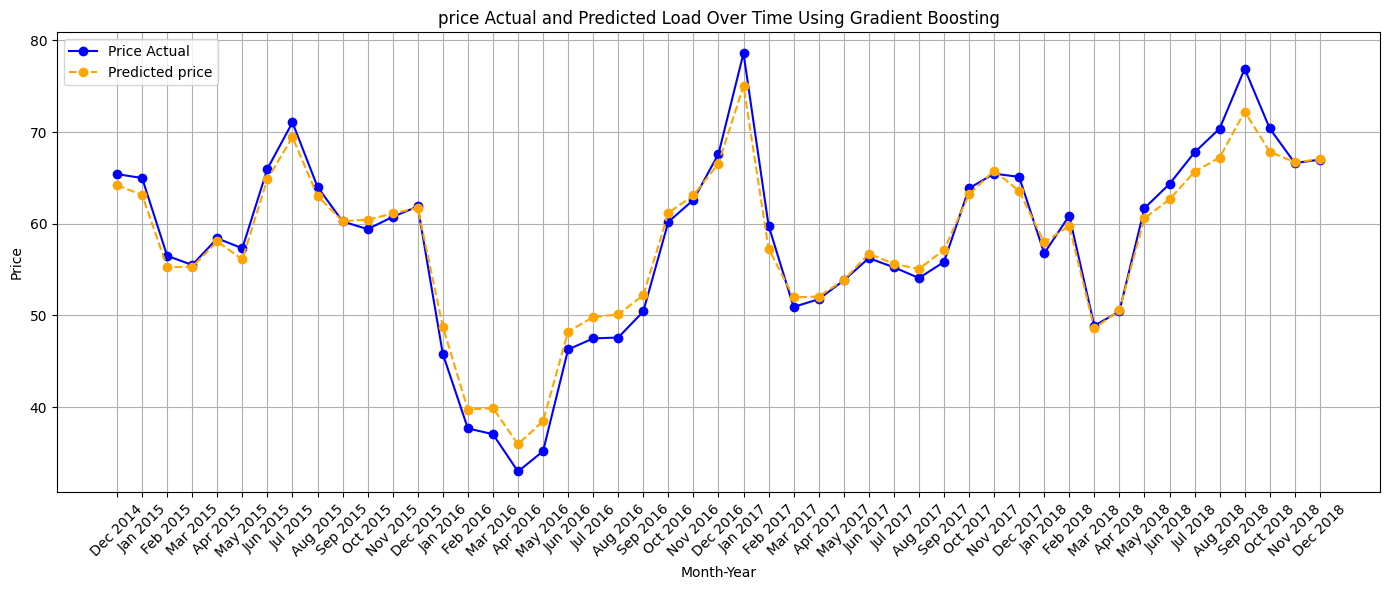

In [96]:
# Initialize and fit the RandomForestRegressor model
gb_model = RandomForestRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)

# Predicting on the train, validation, and test sets
y_pred_train = gb_model.predict(X_train_scaled)
y_pred_validation = gb_model.predict(X_validation_scaled)
y_pred_test = gb_model.predict(X_test_scaled)

# Combine train, validation, and test datasets for plotting
df_train = pd.DataFrame({'datetime': train['datetime'], 'price actual': y_train, 'predicted_price': y_pred_train})
df_validation = pd.DataFrame({'datetime': validation['datetime'], 'price actual': y_validation, 'predicted_price': y_pred_validation})
df_test = pd.DataFrame({'datetime': test['datetime'], 'price actual': y_test, 'predicted_price': y_pred_test})

df_combined = pd.concat([df_train, df_validation, df_test])

# Ensure datetime column is in datetime format
df_combined['datetime'] = pd.to_datetime(df_combined['datetime'])

# Define the desired time range
start_date = '2014-12-31'
end_date = '2018-12-31'

# Filter the data to include only the specified time range
df_combined_filtered = df_combined[(df_combined['datetime'] >= start_date) & (df_combined['datetime'] <= end_date)]

# Group by year and month, and aggregate
df_combined_filtered = df_combined_filtered.groupby(df_combined_filtered['datetime'].dt.to_period('M')).agg({
    'price actual': 'mean',
    'predicted_price': 'mean'
}).reset_index()

# Format month-year column for x-axis labels
df_combined_filtered['month_year'] = df_combined_filtered['datetime'].dt.strftime('%b %Y')

# Plotting
plt.figure(figsize=(14, 6))  # Adjusted figure size

plt.plot(df_combined_filtered['month_year'], df_combined_filtered['price actual'], label='Price Actual', marker='o', color='blue')
plt.plot(df_combined_filtered['month_year'], df_combined_filtered['predicted_price'], label='Predicted price', marker='o', linestyle='--', color='orange')

plt.xlabel('Month-Year')
plt.ylabel('Price')
plt.title('price Actual and Predicted Load Over Time Using Gradient Boosting')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Price Prediction With Hyperparameter tunning using Gradient Boosting Model implementing GridSearchCV

In [97]:
price_features = [price_feature for price_feature in price_features if price_feature not in excl_price_features]

# Using previously split train, validation, and test sets
X_train = train[price_features]
X_validation = validation[price_features]
X_test = test[price_features]

y_train = train['price actual']
y_validation = validation['price actual']
y_test = test['price actual']

# Drop rows with missing values
X_train = X_train.dropna()
X_validation = X_validation.dropna()
X_test = X_test.dropna()

# Re-align y to match X after dropping rows with missing values
y_train = y_train.loc[X_train.index]
y_validation = y_validation.loc[X_validation.index]
y_test = y_test.loc[X_test.index]

# Remove non-numeric columns from X
X_train_numeric = X_train.select_dtypes(include=[np.number])
X_validation_numeric = X_validation.select_dtypes(include=[np.number])
X_test_numeric = X_test.select_dtypes(include=[np.number])

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_validation_scaled = scaler.transform(X_validation_numeric)
X_test_scaled = scaler.transform(X_test_numeric)

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of boosting stages
    'learning_rate': [0.01, 0.1],  # Step size shrinkage to prevent overfitting
    'max_depth': [3, 5],  # Maximum depth of each tree
    'min_samples_split': [2, 5],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2],  # Minimum samples required to be at a leaf node
    'max_features': [ 'sqrt']  # Number of features to consider at every split
}

# Initialize Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)

# Initialize Grid Search with cross-validation
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit Grid Search on training data
grid_search.fit(X_train_scaled, y_train)

# Best parameters and best score found during Grid Search
print("Best parameters found:", grid_search.best_params_)
print("Lowest MSE found:", grid_search.best_score_)

# Predict using the best model from Grid Search on validation set
y_pred_validation = grid_search.best_estimator_.predict(X_validation_scaled)

# Model evaluation on validation set with best model
mse_validation = mean_squared_error(y_validation, y_pred_validation)
r2_validation = r2_score(y_validation, y_pred_validation)
mape_validation = mean_absolute_percentage_error(y_validation, y_pred_validation)
mae_validation = mean_absolute_error(y_validation, y_pred_validation)

# Calculate adjusted R-squared for validation set
n_val = X_validation_scaled.shape[0]
k_val = X_validation_scaled.shape[1]
adjusted_r2_validation = 1 - (1 - r2_validation) * (n_val - 1) / (n_val - k_val - 1)

# Print validation results with best model
print("\nFor Price Prediction:")
print("\nValidation Results with Best Model:")
print(f'Mean Squared Error (MSE): {mse_validation:.2f}')
print(f'R-squared (R2): {r2_validation:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_validation:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_validation:.2f}')
print(f'Mean Absolute Error (MAE): {mae_validation:.2f}')

# Predicting on the test set using the best model found
y_pred_test = grid_search.best_estimator_.predict(X_test_scaled)

# Model evaluation on test set with best model
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

# Calculate adjusted R-squared for test set
n_test = X_test_scaled.shape[0]
k_test = X_test_scaled.shape[1]
adjusted_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - k_test - 1)

# Print test results with best model
print("\nTest Results with Best Model:")
print(f'Mean Squared Error (MSE): {mse_test:.2f}')
print(f'R-squared (R2): {r2_test:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_test:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_test:.2f}')
print(f'Mean Absolute Error (MAE): {mae_test:.2f}')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters found: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}
Lowest MSE found: -33.302837515725365

For Price Prediction:

Validation Results with Best Model:
Mean Squared Error (MSE): 32.38
R-squared (R2): 0.83
Adjusted R-squared: 0.83
Mean Absolute Percentage Error (MAPE): 0.08
Mean Absolute Error (MAE): 4.32

Test Results with Best Model:
Mean Squared Error (MSE): 32.66
R-squared (R2): 0.83
Adjusted R-squared: 0.83
Mean Absolute Percentage Error (MAPE): 0.08
Mean Absolute Error (MAE): 4.37


<ipython-input-98-601abf2e4933>:28: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_combined_filtered = df_combined_filtered.groupby(df_combined_filtered['datetime'].dt.to_period('M')).agg({


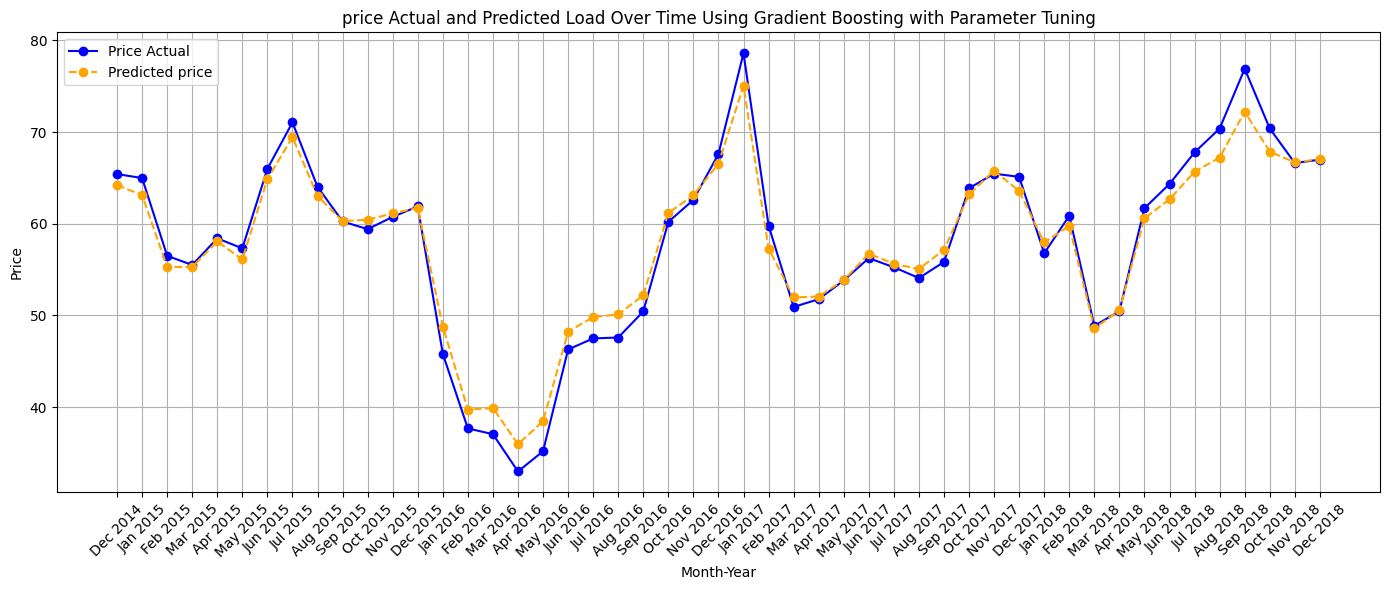

In [98]:
# Initialize and fit the RandomForestRegressor model
gb_model = RandomForestRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)

# Predicting on the train, validation, and test sets
y_pred_train = gb_model.predict(X_train_scaled)
y_pred_validation = gb_model.predict(X_validation_scaled)
y_pred_test = gb_model.predict(X_test_scaled)

# Combine train, validation, and test datasets for plotting
df_train = pd.DataFrame({'datetime': train['datetime'], 'price actual': y_train, 'predicted_price': y_pred_train})
df_validation = pd.DataFrame({'datetime': validation['datetime'], 'price actual': y_validation, 'predicted_price': y_pred_validation})
df_test = pd.DataFrame({'datetime': test['datetime'], 'price actual': y_test, 'predicted_price': y_pred_test})

df_combined = pd.concat([df_train, df_validation, df_test])

# Ensure datetime column is in datetime format
df_combined['datetime'] = pd.to_datetime(df_combined['datetime'])

# Define the desired time range
start_date = '2014-12-31'
end_date = '2018-12-31'

# Filter the data to include only the specified time range
df_combined_filtered = df_combined[(df_combined['datetime'] >= start_date) & (df_combined['datetime'] <= end_date)]

# Group by year and month, and aggregate
df_combined_filtered = df_combined_filtered.groupby(df_combined_filtered['datetime'].dt.to_period('M')).agg({
    'price actual': 'mean',
    'predicted_price': 'mean'
}).reset_index()

# Format month-year column for x-axis labels
df_combined_filtered['month_year'] = df_combined_filtered['datetime'].dt.strftime('%b %Y')

# Plotting
plt.figure(figsize=(14, 6))  # Adjusted figure size

plt.plot(df_combined_filtered['month_year'], df_combined_filtered['price actual'], label='Price Actual', marker='o', color='blue')
plt.plot(df_combined_filtered['month_year'], df_combined_filtered['predicted_price'], label='Predicted price', marker='o', linestyle='--', color='orange')

plt.xlabel('Month-Year')
plt.ylabel('Price')
plt.title('price Actual and Predicted Load Over Time Using Gradient Boosting with Parameter Tuning')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### Long Short-Term Memory (LSTM) Model

#### For Load Consumption Prediction

In [99]:
from tensorflow.keras.regularizers import l2

# Adjusted feature selection
load_features = [load_feature for load_feature in load_features if load_feature not in excl_load_features]

# Using previously split train, validation, and test sets
X_train = train[load_features]
X_validation = validation[load_features]
X_test = test[load_features]

y_train = train['total load actual']
y_validation = validation['total load actual']
y_test = test['total load actual']

# Drop rows with missing values
X_train = X_train.dropna()
X_validation = X_validation.dropna()
X_test = X_test.dropna()

# Re-align y to match X after dropping rows with missing values
y_train = y_train.loc[X_train.index].reset_index(drop=True)
y_validation = y_validation.loc[X_validation.index].reset_index(drop=True)
y_test = y_test.loc[X_test.index].reset_index(drop=True)

X_train = X_train.reset_index(drop=True)
X_validation = X_validation.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

# Remove non-numeric columns from X
X_train_numeric = X_train.select_dtypes(include=[np.number])
X_validation_numeric = X_validation.select_dtypes(include=[np.number])
X_test_numeric = X_test.select_dtypes(include=[np.number])

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_validation_scaled = scaler.transform(X_validation_numeric)
X_test_scaled = scaler.transform(X_test_numeric)

# Reshape input to be 3D for LSTM [samples, time steps, features]
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_validation_scaled = X_validation_scaled.reshape((X_validation_scaled.shape[0], 1, X_validation_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(128, input_shape=(1, X_train_scaled.shape[2]), return_sequences=True))
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(32, kernel_regularizer=l2(0.01)))
lstm_model.add(Dense(1))

# Compile the model
lstm_model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Train the model
history = lstm_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_validation_scaled, y_validation))

# Predicting on the validation set
y_pred_validation = lstm_model.predict(X_validation_scaled)

# Model evaluation on validation set
mse_validation = mean_squared_error(y_validation, y_pred_validation)
r2_validation = r2_score(y_validation, y_pred_validation)
mape_validation = mean_absolute_percentage_error(y_validation, y_pred_validation)
mae_validation = mean_absolute_error(y_validation, y_pred_validation)

# Calculate adjusted R-squared for validation set
n_val = X_validation_scaled.shape[0]  # number of observations
k_val = X_validation_scaled.shape[2]  # number of predictors
adjusted_r2_validation = 1 - (1 - r2_validation) * (n_val - 1) / (n_val - k_val - 1)

# Print validation results
print("\nValidation Results:")
print(f'Mean Squared Error (MSE): {mse_validation:.2f}')
print(f'R-squared (R2): {r2_validation:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_validation:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_validation:.2f}')
print(f'Mean Absolute Error (MAE): {mae_validation:.2f}')

# Predicting on the test set
y_pred_test = lstm_model.predict(X_test_scaled)

# Model evaluation on test set
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

# Calculate adjusted R-squared for test set
n_test = X_test_scaled.shape[0]  # number of observations
k_test = X_test_scaled.shape[2]  # number of predictors
adjusted_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - k_test - 1)

# Print test results
print("\nTest Results for Total Load Actual:")
print(f'Mean Squared Error (MSE): {mse_test:.2f}')
print(f'R-squared (R2): {r2_test:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_test:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_test:.2f}')
print(f'Mean Absolute Error (MAE): {mae_test:.2f}')

Epoch 1/100
329/329 [==============================] - 11s 19ms/step - loss: 424991072.0000 - val_loss: 30200372.0000
Epoch 2/100
329/329 [==============================] - 5s 15ms/step - loss: 14059299.0000 - val_loss: 3961942.2500
Epoch 3/100
329/329 [==============================] - 4s 12ms/step - loss: 3299687.2500 - val_loss: 2163487.5000
Epoch 4/100
329/329 [==============================] - 6s 20ms/step - loss: 2385501.2500 - val_loss: 1760949.5000
Epoch 5/100
329/329 [==============================] - 5s 14ms/step - loss: 2036939.3750 - val_loss: 1596388.0000
Epoch 6/100
329/329 [==============================] - 4s 11ms/step - loss: 1850191.7500 - val_loss: 1413506.0000
Epoch 7/100
329/329 [==============================] - 5s 15ms/step - loss: 1684493.8750 - val_loss: 1341258.6250
Epoch 8/100
329/329 [==============================] - 5s 16ms/step - loss: 1658491.7500 - val_loss: 1303989.7500
Epoch 9/100
329/329 [==============================] - 5s 15ms/step - loss: 1549237

274/274 [==============================] - 2s 8ms/step


<ipython-input-105-c0202156c92b>:38: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_combined_filtered = df_combined_filtered.groupby(df_combined_filtered['datetime'].dt.to_period('M')).agg({


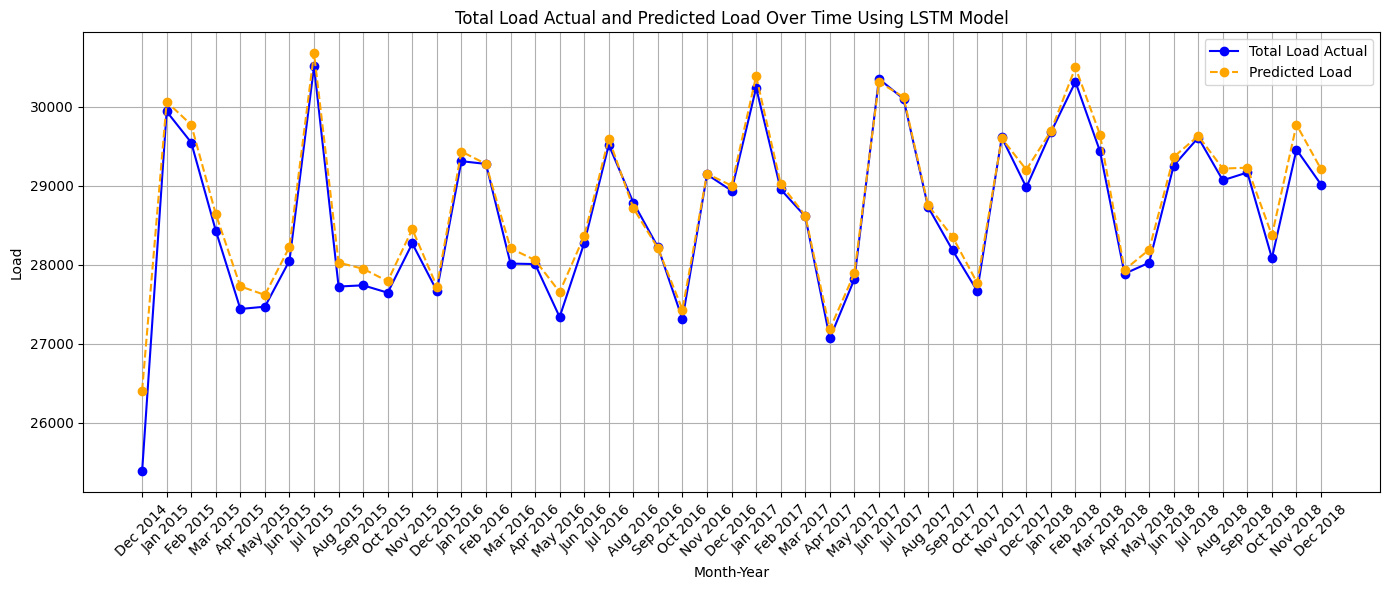

In [105]:
# Predicting on the train, validation, and test sets
y_pred_train = lstm_model.predict(X_train_scaled).flatten()
y_pred_validation = lstm_model.predict(X_validation_scaled).flatten()
y_pred_test = lstm_model.predict(X_test_scaled).flatten()

# Combine train, validation, and test datasets for plotting
df_train = pd.DataFrame({
    'datetime': train.reset_index(drop=True)['datetime'],
    'total load actual': y_train.reset_index(drop=True),
    'predicted_load': y_pred_train
})

df_validation = pd.DataFrame({
    'datetime': validation.reset_index(drop=True)['datetime'],
    'total load actual': y_validation.reset_index(drop=True),
    'predicted_load': y_pred_validation
})

df_test = pd.DataFrame({
    'datetime': test.reset_index(drop=True)['datetime'],
    'total load actual': y_test.reset_index(drop=True),
    'predicted_load': y_pred_test
})

df_combined = pd.concat([df_train, df_validation, df_test])

# Ensure datetime column is in datetime format
df_combined['datetime'] = pd.to_datetime(df_combined['datetime'])

# Define the desired time range
start_date = '2014-12-31'
end_date = '2018-12-31'

# Filter the data to include only the specified time range
df_combined_filtered = df_combined[(df_combined['datetime'] >= start_date) & (df_combined['datetime'] <= end_date)]

# Group by year and month, and aggregate
df_combined_filtered = df_combined_filtered.groupby(df_combined_filtered['datetime'].dt.to_period('M')).agg({
    'total load actual': 'mean',
    'predicted_load': 'mean'
}).reset_index()

# Format month-year column for x-axis labels
df_combined_filtered['month_year'] = df_combined_filtered['datetime'].dt.strftime('%b %Y')

# Plotting
plt.figure(figsize=(14, 6))  # Adjusted figure size

plt.plot(df_combined_filtered['month_year'], df_combined_filtered['total load actual'], label='Total Load Actual', marker='o', color='blue')
plt.plot(df_combined_filtered['month_year'], df_combined_filtered['predicted_load'], label='Predicted Load', marker='o', linestyle='--', color='orange')

plt.xlabel('Month-Year')
plt.ylabel('Load')
plt.title('Total Load Actual and Predicted Load Over Time Using LSTM Model')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

#### For Price Prediction

In [106]:
# Adjusted feature selection
price_features = [price_feature for price_feature in price_features if price_feature not in excl_price_features]

# Using previously split train, validation, and test sets
X_train = train[price_features]
X_validation = validation[price_features]
X_test = test[price_features]

y_train = train['price actual']
y_validation = validation['price actual']
y_test = test['price actual']

# Drop rows with missing values
X_train = X_train.dropna()
X_validation = X_validation.dropna()
X_test = X_test.dropna()

# Re-align y to match X after dropping rows with missing values
y_train = y_train.loc[X_train.index].reset_index(drop=True)
y_validation = y_validation.loc[X_validation.index].reset_index(drop=True)
y_test = y_test.loc[X_test.index].reset_index(drop=True)

X_train = X_train.reset_index(drop=True)
X_validation = X_validation.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

# Remove non-numeric columns from X
X_train_numeric = X_train.select_dtypes(include=[np.number])
X_validation_numeric = X_validation.select_dtypes(include=[np.number])
X_test_numeric = X_test.select_dtypes(include=[np.number])

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_validation_scaled = scaler.transform(X_validation_numeric)
X_test_scaled = scaler.transform(X_test_numeric)

# Reshape input to be 3D for LSTM [samples, time steps, features]
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_validation_scaled = X_validation_scaled.reshape((X_validation_scaled.shape[0], 1, X_validation_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))



In [107]:
from tensorflow.keras.callbacks import EarlyStopping

# Adjusting LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(64, return_sequences=True, input_shape=(1, X_train_scaled.shape[2])))
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(32))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1))

# Compile the model with a lower learning rate
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with more epochs
history = lstm_model.fit(X_train_scaled, y_train, epochs=200, batch_size=32, validation_data=(X_validation_scaled, y_validation), callbacks=[early_stopping])

# Predicting on the validation set
y_pred_validation = lstm_model.predict(X_validation_scaled)

# Model evaluation on validation set
mse_validation = mean_squared_error(y_validation, y_pred_validation)
r2_validation = r2_score(y_validation, y_pred_validation)
mape_validation = mean_absolute_percentage_error(y_validation, y_pred_validation)
mae_validation = mean_absolute_error(y_validation, y_pred_validation)

# Calculate adjusted R-squared for validation set
n_val = X_validation_scaled.shape[0]  # number of observations
k_val = X_validation_scaled.shape[2]  # number of predictors
adjusted_r2_validation = 1 - (1 - r2_validation) * (n_val - 1) / (n_val - k_val - 1)

# Print validation results
print("\nValidation Results:")
print(f'Mean Squared Error (MSE): {mse_validation:.2f}')
print(f'R-squared (R2): {r2_validation:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_validation:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_validation:.2f}')
print(f'Mean Absolute Error (MAE): {mae_validation:.2f}')

# Predicting on the test set
y_pred_test = lstm_model.predict(X_test_scaled)

# Model evaluation on test set
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

# Calculate adjusted R-squared for test set
n_test = X_test_scaled.shape[0]  # number of observations
k_test = X_test_scaled.shape[2]  # number of predictors
adjusted_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - k_test - 1)

# Print test results
print("\nTest Results for Total Load Actual:")
print(f'Mean Squared Error (MSE): {mse_test:.2f}')
print(f'R-squared (R2): {r2_test:.2f}')
print(f'Adjusted R-squared: {adjusted_r2_test:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_test:.2f}')
print(f'Mean Absolute Error (MAE): {mae_test:.2f}')


Epoch 1/200
329/329 [==============================] - 14s 20ms/step - loss: 2735.0525 - val_loss: 1880.9708
Epoch 2/200
329/329 [==============================] - 4s 11ms/step - loss: 1558.0897 - val_loss: 1238.4025
Epoch 3/200
329/329 [==============================] - 3s 9ms/step - loss: 1056.0548 - val_loss: 837.0712
Epoch 4/200
329/329 [==============================] - 4s 13ms/step - loss: 737.6931 - val_loss: 574.1898
Epoch 5/200
329/329 [==============================] - 3s 9ms/step - loss: 542.5856 - val_loss: 405.8369
Epoch 6/200
329/329 [==============================] - 3s 9ms/step - loss: 412.6353 - val_loss: 304.4919
Epoch 7/200
329/329 [==============================] - 3s 9ms/step - loss: 344.1029 - val_loss: 233.9200
Epoch 8/200
329/329 [==============================] - 4s 13ms/step - loss: 293.1713 - val_loss: 187.9895
Epoch 9/200
329/329 [==============================] - 3s 9ms/step - loss: 262.3235 - val_loss: 156.7285
Epoch 10/200
329/329 [=======================

274/274 [==============================] - 1s 4ms/step


<ipython-input-108-ab4970b1c99f>:38: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_combined_filtered = df_combined_filtered.groupby(df_combined_filtered['datetime'].dt.to_period('M')).agg({


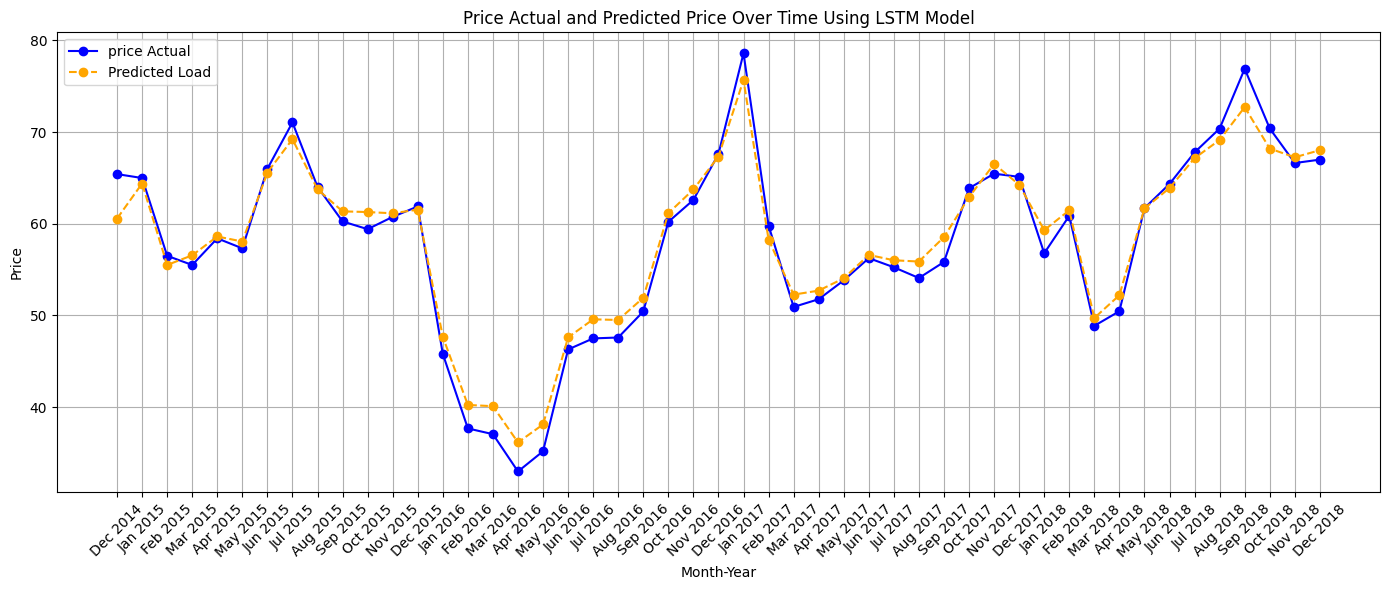

In [108]:
# Predicting on the train, validation, and test sets
y_pred_train = lstm_model.predict(X_train_scaled).flatten()
y_pred_validation = lstm_model.predict(X_validation_scaled).flatten()
y_pred_test = lstm_model.predict(X_test_scaled).flatten()

# Combine train, validation, and test datasets for plotting
df_train = pd.DataFrame({
    'datetime': train.reset_index(drop=True)['datetime'],
    'price actual': y_train.reset_index(drop=True),
    'predicted_price': y_pred_train
})

df_validation = pd.DataFrame({
    'datetime': validation.reset_index(drop=True)['datetime'],
    'price actual': y_validation.reset_index(drop=True),
    'predicted_price': y_pred_validation
})

df_test = pd.DataFrame({
    'datetime': test.reset_index(drop=True)['datetime'],
    'price actual': y_test.reset_index(drop=True),
    'predicted_price': y_pred_test
})

df_combined = pd.concat([df_train, df_validation, df_test])

# Ensure datetime column is in datetime format
df_combined['datetime'] = pd.to_datetime(df_combined['datetime'])

# Define the desired time range
start_date = '2014-12-31'
end_date = '2018-12-31'

# Filter the data to include only the specified time range
df_combined_filtered = df_combined[(df_combined['datetime'] >= start_date) & (df_combined['datetime'] <= end_date)]

# Group by year and month, and aggregate
df_combined_filtered = df_combined_filtered.groupby(df_combined_filtered['datetime'].dt.to_period('M')).agg({
    'price actual': 'mean',
    'predicted_price': 'mean'
}).reset_index()

# Format month-year column for x-axis labels
df_combined_filtered['month_year'] = df_combined_filtered['datetime'].dt.strftime('%b %Y')

# Plotting
plt.figure(figsize=(14, 6))  # Adjusted figure size

plt.plot(df_combined_filtered['month_year'], df_combined_filtered['price actual'], label='price Actual', marker='o', color='blue')
plt.plot(df_combined_filtered['month_year'], df_combined_filtered['predicted_price'], label='Predicted Load', marker='o', linestyle='--', color='orange')

plt.xlabel('Month-Year')
plt.ylabel('Price')
plt.title('Price Actual and Predicted Price Over Time Using LSTM Model')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [110]:

# Data for Load Prediction
load_test_data = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "Random Forest with HP", "Gradient Boosting", "Gradient Boosting with HP", "LSTM"],
    "Mean Squared Error (MSE)": [1595417.25, 1369580.05, 1160731.21, 1514348.70, 967143.57, 871004.26],
    "R-squared (R2)": [0.92, 0.93, 0.94, 0.93, 0.95, 0.96],
    "Adjusted R-squared": [0.92, 0.93, 0.94, 0.93, 0.95, 0.96],
    "Mean Absolute Percentage Error (MAPE)": [0.04, 0.03, 0.03, 0.03, 0.03, 0.03],
    "Mean Absolute Error (MAE)": [987.65, 884.83, 822.75, 961.76, 766.58, 717.43]
})

# Data for Price Prediction
price_test_data = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "Random Forest with HP", "Gradient Boosting", "Gradient Boosting with HP", "LSTM"],
    "Mean Squared Error (MSE)": [96.93, 27.61, 27.03, 51.36, 32.66, 25.24],
    "R-squared (R2)": [0.50, 0.86, 0.86, 0.73, 0.83,0.87],
    "Adjusted R-squared": [0.49, 0.86, 0.86, 0.73, 0.83,0.87],
    "Mean Absolute Percentage Error (MAPE)": [0.15, 0.07, 0.07, 0.11, 0.08, 0.07],
    "Mean Absolute Error (MAE)": [7.65, 3.75, 3.76, 5.52, 4.37, 3.78]
})

# Define a function to style the DataFrame
def style_dataframe(df):
    return df.style.format({
        "Mean Squared Error (MSE)": "{:,.2f}",
        "R-squared (R2)": "{:.2f}",
        "Adjusted R-squared": "{:.2f}",
        "Mean Absolute Percentage Error (MAPE)": "{:.2f}",
        "Mean Absolute Error (MAE)": "{:,.2f}"
    }).format_index(str.upper, axis=1)

# Display the tables with styling
print("Load Prediction Test Results:")
display(style_dataframe(load_test_data))

print("\nPrice Prediction Test Results:")
display(style_dataframe(price_test_data))


Load Prediction Test Results:



Price Prediction Test Results:


The Best Model for:
Load Prediction is LSTM &
Price Prediction is LSTM

X_train_scaled shape: (10519, 1, 35)
y_train shape: (10519,)
329/329 [==============================] - 1s 2ms/step


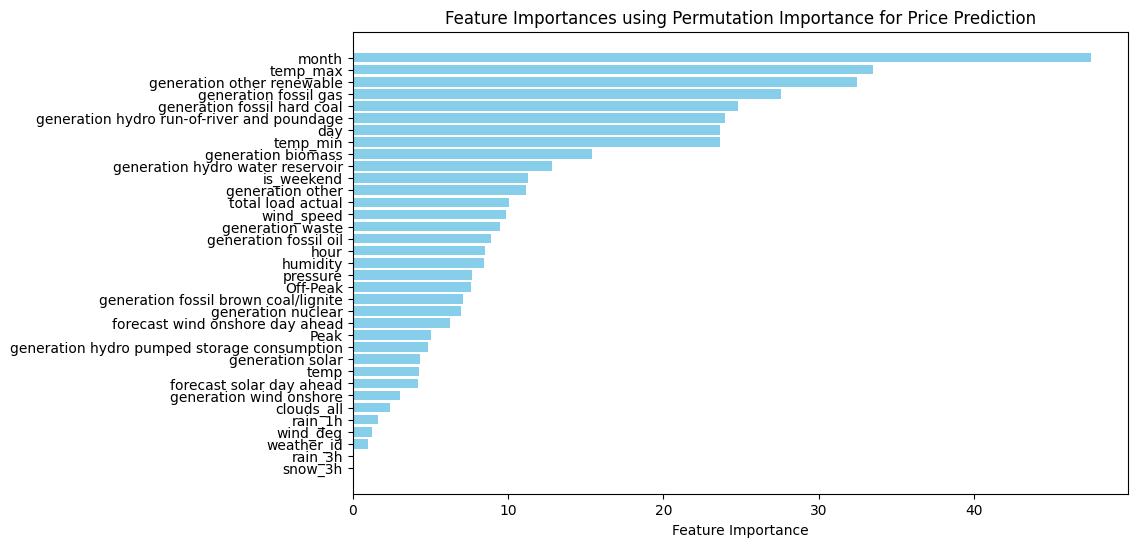

In [116]:
# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)

# Reshape input to be 3D for LSTM [samples, time steps, features]
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))

# Ensure y_train is 1D
y_train = y_train.values if hasattr(y_train, 'values') else y_train
y_train = y_train.flatten()

# Check the shapes
print(f'X_train_scaled shape: {X_train_scaled.shape}')
print(f'y_train shape: {y_train.shape}')

# Define a function to measure performance change
def compute_feature_importance(model, X, y, metric, baseline_performance):
    feature_importance = []
    for i in range(X.shape[2]):
        X_permuted = X.copy()
        np.random.shuffle(X_permuted[:, 0, i])
        permuted_performance = metric(y, model.predict(X_permuted).flatten())
        importance = baseline_performance - permuted_performance
        feature_importance.append(abs(importance))  # Take absolute value
    return feature_importance

# Define the metric
def mse_metric(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Calculate baseline performance
baseline_performance = mse_metric(y_train, lstm_model.predict(X_train_scaled).flatten())

# Compute feature importances
importances = compute_feature_importance(lstm_model, X_train_scaled, y_train, mse_metric, baseline_performance)

# Create a DataFrame to hold the feature importances
feature_importances = pd.DataFrame({
    'feature': X_train_numeric.columns,
    'importance': importances
})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importances using Permutation Importance for Price Prediction')
plt.gca().invert_yaxis()
plt.show()

Epoch 1/100
329/329 [==============================] - 10s 15ms/step - loss: 425924576.0000 - val_loss: 30730022.0000
Epoch 2/100
329/329 [==============================] - 5s 15ms/step - loss: 12658479.0000 - val_loss: 3688176.7500
Epoch 3/100
329/329 [==============================] - 6s 17ms/step - loss: 3038037.2500 - val_loss: 2083540.7500
Epoch 4/100
329/329 [==============================] - 5s 15ms/step - loss: 2195886.0000 - val_loss: 1694551.5000
Epoch 5/100
329/329 [==============================] - 4s 11ms/step - loss: 1999971.6250 - val_loss: 1560742.6250
Epoch 6/100
329/329 [==============================] - 5s 15ms/step - loss: 1781667.1250 - val_loss: 1386666.8750
Epoch 7/100
329/329 [==============================] - 6s 19ms/step - loss: 1637836.5000 - val_loss: 1318524.8750
Epoch 8/100
329/329 [==============================] - 4s 11ms/step - loss: 1541825.1250 - val_loss: 1245715.0000
Epoch 9/100
329/329 [==============================] - 5s 17ms/step - loss: 1487894

<ipython-input-119-db41228e07ec>:139: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_combined_filtered = df_combined_filtered.groupby(df_combined_filtered['datetime'].dt.to_period('M')).agg({


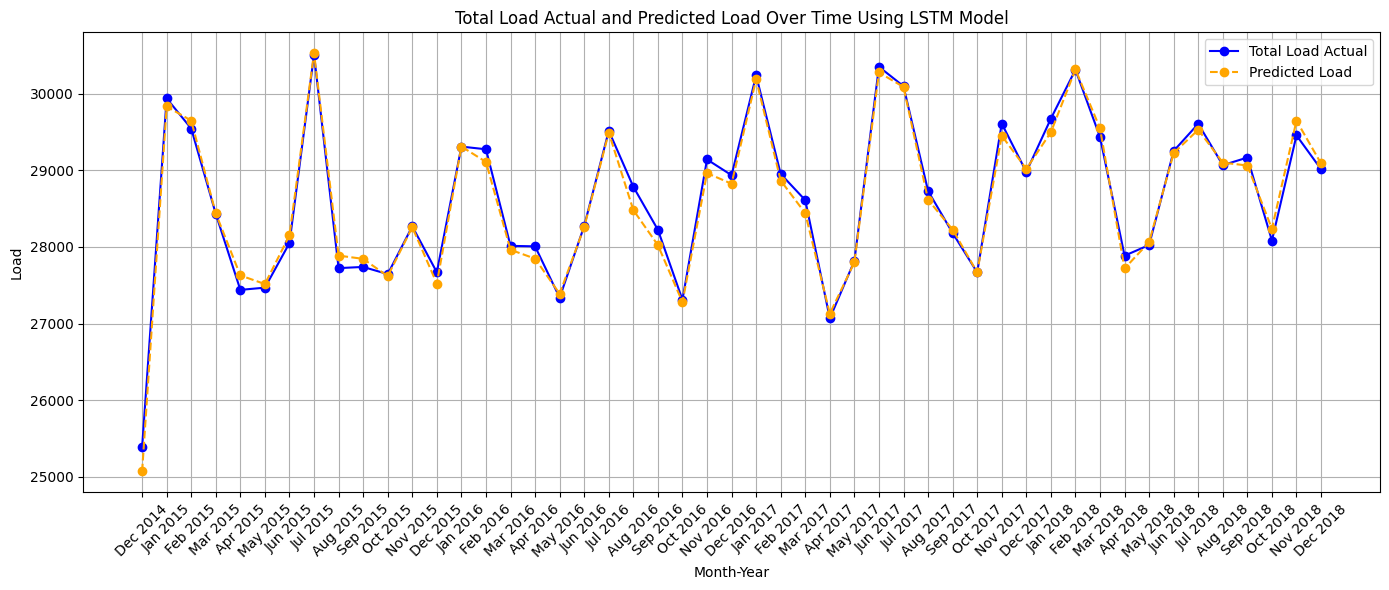

In [119]:
from tensorflow.keras.regularizers import l2

# Adjusted feature selection
load_features = [load_feature for load_feature in load_features if load_feature not in excl_load_features]

# Using previously split train, validation, and test sets
X_train = train[load_features]
X_validation = validation[load_features]
X_test = test[load_features]

y_train = train['total load actual']
y_validation = validation['total load actual']
y_test = test['total load actual']

# Drop rows with missing values
X_train = X_train.dropna()
X_validation = X_validation.dropna()
X_test = X_test.dropna()

# Re-align y to match X after dropping rows with missing values
y_train = y_train.loc[X_train.index].reset_index(drop=True)
y_validation = y_validation.loc[X_validation.index].reset_index(drop=True)
y_test = y_test.loc[X_test.index].reset_index(drop=True)

X_train = X_train.reset_index(drop=True)
X_validation = X_validation.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

# Remove non-numeric columns from X
X_train_numeric = X_train.select_dtypes(include=[np.number])
X_validation_numeric = X_validation.select_dtypes(include=[np.number])
X_test_numeric = X_test.select_dtypes(include=[np.number])

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_validation_scaled = scaler.transform(X_validation_numeric)
X_test_scaled = scaler.transform(X_test_numeric)

# Reshape input to be 3D for LSTM [samples, time steps, features]
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_validation_scaled = X_validation_scaled.reshape((X_validation_scaled.shape[0], 1, X_validation_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(128, input_shape=(1, X_train_scaled.shape[2]), return_sequences=True))
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(32, kernel_regularizer=l2(0.01)))
lstm_model.add(Dense(1))

# Compile the model
lstm_model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Train the model
history = lstm_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_validation_scaled, y_validation))

# Predicting on the validation set
y_pred_validation = lstm_model.predict(X_validation_scaled)

# Model evaluation on validation set
mse_validation = mean_squared_error(y_validation, y_pred_validation)
r2_validation = r2_score(y_validation, y_pred_validation)
mape_validation = mean_absolute_percentage_error(y_validation, y_pred_validation)
mae_validation = mean_absolute_error(y_validation, y_pred_validation)

# Calculate adjusted R-squared for validation set
n_val = X_validation_scaled.shape[0]  # number of observations
k_val = X_validation_scaled.shape[2]  # number of predictors
adjusted_r2_validation = 1 - (1 - r2_validation) * (n_val - 1) / (n_val - k_val - 1)

# Print validation results
# print("\nValidation Results:")
# print(f'Mean Squared Error (MSE): {mse_validation:.2f}')
# print(f'R-squared (R2): {r2_validation:.2f}')
# print(f'Adjusted R-squared: {adjusted_r2_validation:.2f}')
# print(f'Mean Absolute Percentage Error (MAPE): {mape_validation:.2f}')
# print(f'Mean Absolute Error (MAE): {mae_validation:.2f}')

# Predicting on the test set
y_pred_test = lstm_model.predict(X_test_scaled)

# Model evaluation on test set
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

# Calculate adjusted R-squared for test set
n_test = X_test_scaled.shape[0]  # number of observations
k_test = X_test_scaled.shape[2]  # number of predictors
adjusted_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - k_test - 1)

# # Print test results
# print("\nTest Results for Total Load Actual:")
# print(f'Mean Squared Error (MSE): {mse_test:.2f}')
# print(f'R-squared (R2): {r2_test:.2f}')
# print(f'Adjusted R-squared: {adjusted_r2_test:.2f}')
# print(f'Mean Absolute Percentage Error (MAPE): {mape_test:.2f}')
# print(f'Mean Absolute Error (MAE): {mae_test:.2f}')
# Predicting on the train, validation, and test sets
y_pred_train = lstm_model.predict(X_train_scaled).flatten()
y_pred_validation = lstm_model.predict(X_validation_scaled).flatten()
y_pred_test = lstm_model.predict(X_test_scaled).flatten()

# Combine train, validation, and test datasets for plotting
df_train = pd.DataFrame({
    'datetime': train.reset_index(drop=True)['datetime'],
    'total load actual': y_train.reset_index(drop=True),
    'predicted_load': y_pred_train
})

df_validation = pd.DataFrame({
    'datetime': validation.reset_index(drop=True)['datetime'],
    'total load actual': y_validation.reset_index(drop=True),
    'predicted_load': y_pred_validation
})

df_test = pd.DataFrame({
    'datetime': test.reset_index(drop=True)['datetime'],
    'total load actual': y_test.reset_index(drop=True),
    'predicted_load': y_pred_test
})

df_combined = pd.concat([df_train, df_validation, df_test])

# Ensure datetime column is in datetime format
df_combined['datetime'] = pd.to_datetime(df_combined['datetime'])

# Define the desired time range
start_date = '2014-12-31'
end_date = '2018-12-31'

# Filter the data to include only the specified time range
df_combined_filtered = df_combined[(df_combined['datetime'] >= start_date) & (df_combined['datetime'] <= end_date)]

# Group by year and month, and aggregate
df_combined_filtered = df_combined_filtered.groupby(df_combined_filtered['datetime'].dt.to_period('M')).agg({
    'total load actual': 'mean',
    'predicted_load': 'mean'
}).reset_index()

# Format month-year column for x-axis labels
df_combined_filtered['month_year'] = df_combined_filtered['datetime'].dt.strftime('%b %Y')

# Plotting
plt.figure(figsize=(14, 6))  # Adjusted figure size

plt.plot(df_combined_filtered['month_year'], df_combined_filtered['total load actual'], label='Total Load Actual', marker='o', color='blue')
plt.plot(df_combined_filtered['month_year'], df_combined_filtered['predicted_load'], label='Predicted Load', marker='o', linestyle='--', color='orange')

plt.xlabel('Month-Year')
plt.ylabel('Load')
plt.title('Total Load Actual and Predicted Load Over Time Using LSTM Model')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

X_train_scaled shape: (10519, 1, 35)
y_train shape: (10519,)
329/329 [==============================] - 2s 5ms/step


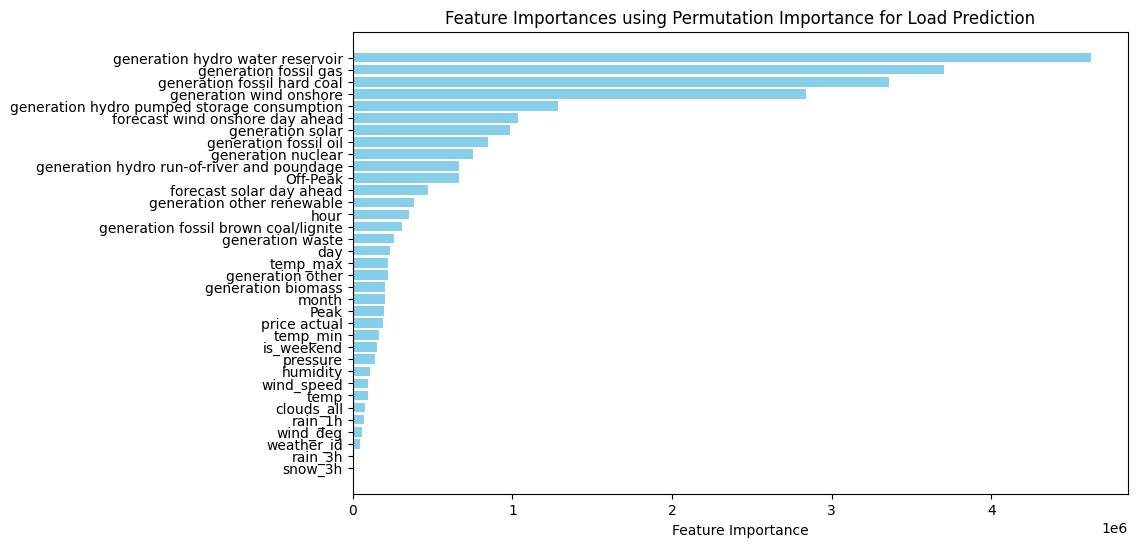

In [120]:
# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)

# Reshape input to be 3D for LSTM [samples, time steps, features]
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))

# Ensure y_train is 1D
y_train = y_train.values if hasattr(y_train, 'values') else y_train
y_train = y_train.flatten()

# Check the shapes
print(f'X_train_scaled shape: {X_train_scaled.shape}')
print(f'y_train shape: {y_train.shape}')

# Define a function to measure performance change
def compute_feature_importance(model, X, y, metric, baseline_performance):
    feature_importance = []
    for i in range(X.shape[2]):
        X_permuted = X.copy()
        np.random.shuffle(X_permuted[:, 0, i])
        permuted_performance = metric(y, model.predict(X_permuted).flatten())
        importance = baseline_performance - permuted_performance
        feature_importance.append(abs(importance))  # Take absolute value
    return feature_importance

# Define the metric
def mse_metric(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Calculate baseline performance
baseline_performance = mse_metric(y_train, lstm_model.predict(X_train_scaled).flatten())

# Compute feature importances
importances = compute_feature_importance(lstm_model, X_train_scaled, y_train, mse_metric, baseline_performance)

# Create a DataFrame to hold the feature importances
feature_importances = pd.DataFrame({
    'feature': X_train_numeric.columns,
    'importance': importances
})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importances using Permutation Importance for Load Prediction')
plt.gca().invert_yaxis()
plt.show()